In [11]:
mname = 'hill_g100'
fold = 0

In [12]:
# hillclimbing on oofs from pytorch models with folds

glist = ['air_g68','air_h68',
         'airx_h67',
         'cbam_h67',
         'iv3_g11','iv3_h11',
         'preresnet_g67','preresnet_h67',
         'se_resnext_g30','se_resnext_h30']

mnames = glist 

# special = 'airnext50_gwap_ch_030'
special = 'air_h68'

clist = []
dlist = []
flist = []
olist = []
slist = []

gpct = 90.
gscale = 1.
# gscale = 10.
nfold = 2

In [13]:
import numpy as np
import pandas as pd
import pickle
import os
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Reshape, Lambda, Activation
from keras.layers import UpSampling2D, Dropout, BatchNormalization, MaxPooling2D
from keras.losses import binary_crossentropy
from keras import backend as K
from keras.applications import MobileNet

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.morphology import opening, closing

from scipy.special import logit, expit
import scipy.optimize as opt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.isotonic import IsotonicRegression

import gc
import cv2
from tqdm import tqdm_notebook

from sklearn.metrics import jaccard_similarity_score, f1_score, precision_score, recall_score

# from metrics import iou_metric, iou_metric_batch
# from metric import mean_iou

In [14]:
PATH_TO_TRAIN = './train/'
PATH_TO_TEST = './test/'
PATH_TO_TARGET = './train.csv'
PATH_TO_SUB = './sample_submission.csv'

LABEL_MAP = {
0: "Nucleoplasm" ,
1: "Nuclear membrane"   ,
2: "Nucleoli"   ,
3: "Nucleoli fibrillar center",   
4: "Nuclear speckles"   ,
5: "Nuclear bodies"   ,
6: "Endoplasmic reticulum"   ,
7: "Golgi apparatus"  ,
8: "Peroxisomes"   ,
9:  "Endosomes"   ,
10: "Lysosomes"   ,
11: "Intermediate filaments"  , 
12: "Actin filaments"   ,
13: "Focal adhesion sites"  ,
14: "Microtubules"   ,
15: "Microtubule ends"   ,
16: "Cytokinetic bridge"   ,
17: "Mitotic spindle"  ,
18: "Microtubule organizing center",  
19: "Centrosome",
20: "Lipid droplets"   ,
21: "Plasma membrane"  ,
22: "Cell junctions"   ,
23: "Mitochondria"   ,
24: "Aggresome"   ,
25: "Cytosol" ,
26: "Cytoplasmic bodies",
27: "Rods & rings"}

In [15]:
df = pd.read_csv(PATH_TO_TARGET)
df.set_index('Id',inplace=True)
print(df.head())
print(df.shape)

                                       Target
Id                                           
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18
(31072, 1)


In [16]:
file_list = list(df.index.values)

ss = pd.read_csv(PATH_TO_SUB)
ss.set_index('Id',inplace=True)
print(ss.head())
print(ss.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [17]:
# train_df["images"] = [np.array(load_img("images/{}.png".format(idx), color_mode = "grayscale")) / 255 \
#                       for idx in tqdm_notebook(train_df.index)]

# train_df["masks"] = [np.array(load_img("masks/{}.png".format(idx), color_mode = "grayscale")) / 255 \
#                      for idx in tqdm_notebook(train_df.index)]

In [18]:
df.columns

Index(['Target'], dtype='object')

In [19]:
# estimate thresholds by line search
def F1_hard(preds, targs, th=0.5):
    return -f1_score(targs,  (preds>th).astype(int))

def fit_val1(x, y, start=0.5):
    params = np.array([start])
    wd = 1e-5
#     error = lambda p: np.array(F1_hard(x,y,p), wd*(p - 0.5))
    error = lambda p: np.array(F1_hard(x,y,p))
#     p = opt.minimize_scalar(error, bounds=[0.3,0.7], method='bounded').x
#     p = opt.minimize_scalar(error, bounds=[0.1,0.9], method='bounded').x
    p = opt.minimize_scalar(error, bounds=[0.01,0.99], method='bounded').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='brent').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='golden').x
    return p

In [20]:
oof = df.copy()
# print(oof.head())
# print(oof.shape)
eps = 1e-6
num_classes = 28
np.set_printoptions(precision=3,linewidth=80,suppress=True)

c = 0
d = 0

for k,m in enumerate(mnames):
    print(' ')
    print(m)
    first = True
    for f in range(nfold):
        if m in clist:
            fname = str('oof/'+clist0[c]+'_ext_russ4/oof_pred.csv')
            # print(fname)
            o = pd.read_csv(fname)
            o = o[o.fold == f]
            idf = list(o['Id'])
            pooff = o.iloc[:,3:].values
#             print(pooff.shape)
        elif m in dlist:
            if dlist0[d] in dlist0s: s = '_' + dfold
            else: s = '_extra_' + dfold
            o = pd.read_csv('./oof/Dmytro/'+dlist0[d]+s+'__fold_'+
                            str(f)+'_'+dlist1[d]+'_oof.csv')
            # print(o.head(),o.shape)
            idf = list(o['Id'])
            pooff = np.array(o.iloc[:,:num_classes])
        elif m in slist:
            fname = 'oof/'+m+'_'+str(f)+'.pkl'
#             print(fname)
            a = pickle.load(open(fname,'rb'))
            idf = list(a[:,0])
#             pooff = [np.array(a[i,1:]).astype(float).flatten() for i in range(a.shape[0])]
            pooff = a[:,1:].astype(float)
#             print(pooff.shape)
        else:        
            idf, pooff, yooff = pickle.load(open('oof/'+m+'_'+str(f)+'.pkl','rb'))
        
        # change to probability scale
        # reduce map to single number
        if m in dlist: 
            pooff = expit(pooff)
        elif m in clist+slist:
            pass
        else: 
            pooff = np.percentile(pooff, gpct, axis=(2,3))
            pooff = 1./(1. + np.exp(-pooff/gscale))
#             for i in range(num_classes):
#                 ir = IsotonicRegression()
#                 pooff[:,i] = ir.fit_transform(pooff[:,i],yooff[:,i])
         
#         print(pooff.shape)
        if first:
            id = idf
            folds = np.zeros(len(idf)).astype(int) + f
            poof = pooff.copy()
            yoof = yooff.copy()
            first = False
        else:
            id = id + idf
            folds = np.concatenate((folds, np.zeros(len(idf)).astype(int) + f))
            poof = np.concatenate((poof,pooff))
            yoof = np.concatenate((yoof,yooff))
    
#     # determine class-specific thresholds and convert predictions to binary
#     th = np.zeros(num_classes)
#     for i in range(num_classes):
#         th[i] = fit_val1(poof[:,i],yoof[:,i])
#     print('Thresholds: ',th)
#     poof = poof > th
#     print('F1 macro: ',f1_score(yoof, poof, average='macro'))

    mdf = pd.DataFrame({'Id':id})
    print(poof.shape, poof.min(), poof.mean(), poof.max())
    if k==0: 
        mdf['fold'] = folds
        mdf['y'] = [yoof[i] for i in range(yoof.shape[0])]
    mdf[m] = [poof[i] for i in range(poof.shape[0])]
    mdf.set_index('Id',inplace=True)
    oof = oof.join(mdf)
#     print(oof.shape)
      
    if m in clist: c += 1
    elif m in dlist: d += 1

 
air_g68
(31072, 28) 5.199339475012162e-10 0.10856166392899642 0.9999999200061678
 
air_h68
(31072, 28) 9.017364594412242e-11 0.13291015708227766 0.9999999943362174
 
airx_h67
(31072, 28) 8.785416845878402e-07 0.15794095011510392 0.9999476969311245
 
cbam_h67
(31072, 28) 1.490742170761279e-06 0.14490588687198672 0.9999638433132007
 
iv3_g11
(31072, 28) 1.890722579368819e-15 0.18436057236015854 0.9999999870846621
 
iv3_h11
(31072, 28) 2.41603052774414e-13 0.18299899477567702 0.9999997216177055
 
preresnet_g67
(31072, 28) 5.15687356979823e-09 0.11409260331704822 0.9999988713299672
 
preresnet_h67
(31072, 28) 1.3114515330332025e-09 0.13314753023669737 0.9999965263197891
 
se_resnext_g30
(31072, 28) 4.998406239369011e-08 0.10705229990052367 0.9999747502237741
 
se_resnext_h30
(31072, 28) 1.1202183529134713e-07 0.12729151282084192 0.9999303639699844


In [21]:
# # replace 3 missing values due to dropping bad images in slist models
# nav = oof['shai_res18'].isna()
# # nav = oof.isna()
# print(nav.sum())

In [22]:
# num_classes = 28
# for i in range(oof.shape[0]):
#     if nav[i]:
#         for s in slist:
#             oof[s][i] = np.zeros(num_classes) 

In [23]:
# print(oof.head())
print(oof.shape)

(31072, 13)


In [24]:
oof.columns

Index(['Target', 'fold', 'y', 'air_g68', 'air_h68', 'airx_h67', 'cbam_h67',
       'iv3_g11', 'iv3_h11', 'preresnet_g67', 'preresnet_h67',
       'se_resnext_g30', 'se_resnext_h30'],
      dtype='object')

In [25]:
vp = oof.loc[oof['y'].notnull()]
print(vp.shape)

(31072, 13)


In [26]:
# # compute rank transform separately for every column
# from scipy.stats import rankdata
# n = vp.shape[0] * 28
# for m in mnames:
#     a = rankdata(np.array(list(vp[m])).flatten()).reshape((vp.shape[0],28))/n
#     vp[m] = [i for i in a]
# print(vp.shape)

In [27]:
vp.head()

Target  fold  \
Id                                                    
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0     0   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0     1   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5     1   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1     1   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18     0   

                                                                                      y  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                                air_g68  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.9938142046510011, 0.0037916844887311307, 0....   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.9271292091812569, 0.9984812691958725, 0.097...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.8719980781234266, 0.008140209451856626, 0.3...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.9585714848369201, 0.9944451332457828, 0.051...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.7084975848106435, 5.112335699132039e-05, 0....   

                                                                                air_h68  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.9835724695027714, 0.008632446082215098, 0.0...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.9436852760526215, 0.9998462239647582, 0.168...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.9614538788526873, 0.02156667464916855, 0.31...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.8337132020420748, 0.9995023747283224, 0.010...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.9609791184646658, 0.0005009156579273469, 0....   

                                                                               airx_h67  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.9934669401661846, 0.006963515153203707, 0.0...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.9901062579191326, 0.9989106680249538, 0.178...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.977937452507024, 0.030957779346692832, 0.30...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.9106319916666994, 0.9987898744577565, 0.060...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.7681555904276774, 0.00281168217801685, 0.24...   

                                                                               cbam_h67  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.9723048627239375, 0.006949169927073222, 0.0...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.8885783897992546, 0.9956250263370134, 0.652...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.8977109247885934, 0.04155724538466728, 0.46...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.798920745332107, 0.9866330973221051, 0.0571...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.5882571001000663, 0.0022788295230577013, 0....   

                                                                                iv3_g11  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.9987159988761126, 0.00698739714781295, 0.07...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.8641792694358255, 0.9992822883547582, 0.997...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.9743035937189628, 0.0764655144301097, 0.900...   
000c99ba

In [28]:
offset = 3
nm = vp.shape[1] - offset
folds = oof['fold'].values.astype(int)
print(offset, nm, folds.shape)

3 10 (31072,)


In [29]:
y = np.array([a for a in vp.y])
y.shape

(31072, 28)

In [30]:
ys = np.sum(y,axis=1)
print(ys.shape)
print(ys.min(),ys.mean(),ys.max())

(31072,)
1.0 1.6343331 5.0


In [31]:
c_val = np.sum(y,axis=0)
for k,v in LABEL_MAP.items():
    print(k,v, 'count', c_val[k],
             'prop', '%6.4f' % (c_val[k]/y.shape[0]))

0 Nucleoplasm count 12885.0 prop 0.4147
1 Nuclear membrane count 1254.0 prop 0.0404
2 Nucleoli count 3621.0 prop 0.1165
3 Nucleoli fibrillar center count 1561.0 prop 0.0502
4 Nuclear speckles count 1858.0 prop 0.0598
5 Nuclear bodies count 2513.0 prop 0.0809
6 Endoplasmic reticulum count 1008.0 prop 0.0324
7 Golgi apparatus count 2822.0 prop 0.0908
8 Peroxisomes count 53.0 prop 0.0017
9 Endosomes count 45.0 prop 0.0014
10 Lysosomes count 28.0 prop 0.0009
11 Intermediate filaments count 1093.0 prop 0.0352
12 Actin filaments count 688.0 prop 0.0221
13 Focal adhesion sites count 537.0 prop 0.0173
14 Microtubules count 1066.0 prop 0.0343
15 Microtubule ends count 21.0 prop 0.0007
16 Cytokinetic bridge count 530.0 prop 0.0171
17 Mitotic spindle count 210.0 prop 0.0068
18 Microtubule organizing center count 902.0 prop 0.0290
19 Centrosome count 1482.0 prop 0.0477
20 Lipid droplets count 172.0 prop 0.0055
21 Plasma membrane count 3777.0 prop 0.1216
22 Cell junctions count 802.0 prop 0.0258
23

In [32]:
# idx = range(28)
# loc = [LABEL_MAP[j] for j in idx]
# lb = [c_val[j]/y.shape[0] for j in idx]

# df = pd.DataFrame({'idx':idx, 'loc':loc, 'training':lb})
# fname = 'train_props.csv'
# df.to_csv(fname,index=False)
# print(fname)

In [33]:
# train_sum_vec = np.sum(np.stack(subm['target_vec'].values, 0), 0)
# _ = plt.bar(n_keys, [train_sum_vec[k] for k in n_keys])

In [34]:
ymean = np.mean(y,axis=0)
print(ymean)

[0.415 0.04  0.117 0.05  0.06  0.081 0.032 0.091 0.002 0.001 0.001 0.035 0.022
 0.017 0.034 0.001 0.017 0.007 0.029 0.048 0.006 0.122 0.026 0.095 0.01  0.265
 0.011 0.   ]


In [35]:
ysum = np.sum(y,axis=0)
print(ysum)

[12885.  1254.  3621.  1561.  1858.  2513.  1008.  2822.    53.    45.    28.
  1093.   688.   537.  1066.    21.   530.   210.   902.  1482.   172.  3777.
   802.  2965.   322.  8228.   328.    11.]


(-0.03034705803458428, 0.4436122904074585)

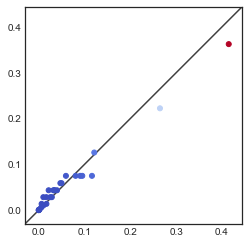

In [36]:
# plot training class frequencies versus those from leaderboard probing by iafoss
lb_prob = np.array([
0.36239782, 0.043841336, 0.075268817, 0.059322034, 0.075268817,
0.075268817, 0.043841336, 0.075268817, 0.0018, 0.0014,
0.0009, 0.043841336, 0.043841336, 0.014198783, 0.043841336,
0.0007, 0.028806584, 0.014198783, 0.028806584, 0.059322034,
0.0056, 0.126126126, 0.028806584, 0.075268817, 0.0104,
0.222493888, 0.028806584, 0.0004
])
   
# sns.regplot(ymean, lb_prob)

c = ymean**2 + lb_prob**2

fig, ax = plt.subplots()
ax.scatter(ymean, lb_prob, s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
# fig.savefig('/Users/paul/Desktop/so.png', dpi=300)

In [37]:
# lb probing resuluts from iafoss
# print lower and upper bound on frequencies
probe = {
0 : 0.019,
1 : 0.003,
2 : 0.005,
3 : 0.004,
4 : 0.005,
5 : 0.005,
6 : 0.003,
7 : 0.005,
8 : 0.000,
9 : 0.000,
10 : 0.000,
11 : 0.003,
12 : 0.003,
13 : 0.001,
14 : 0.003,
15 : 0.000,
16 : 0.002,
17 : 0.001,
18 : 0.002,
19 : 0.004,
20 : 0.000,
21 : 0.008,
22 : 0.002,
23 : 0.005,
24 : 0.000,
25 : 0.013,
26 : 0.002,
27 : 0.000
}

r = 0.000499
for k in range(28):

    # si = 0.019*28
    si = probe[k]*28
    fi = si/(2-si)
    si0 = max(0,(probe[k] - r)*28)
    fi0 = si0/(2-si0)
    si1 = (probe[k] + r)*28
    fi1 = si1/(2-si1)
    ci = np.round(fi*11702)
    print(k,'%6.4f %6.4f %6.4f %6.4f %d %d' % (fi0,fi,fi1,ymean[k],ci,ysum[k]),LABEL_MAP[k])

0 0.3496 0.3624 0.3755 0.4147 4241 12885 Nucleoplasm
1 0.0363 0.0438 0.0515 0.0404 513 1254 Nuclear membrane
2 0.0673 0.0753 0.0834 0.1165 881 3621 Nucleoli
3 0.0515 0.0593 0.0672 0.0502 694 1561 Nucleoli fibrillar center
4 0.0673 0.0753 0.0834 0.0598 881 1858 Nuclear speckles
5 0.0673 0.0753 0.0834 0.0809 881 2513 Nuclear bodies
6 0.0363 0.0438 0.0515 0.0324 513 1008 Endoplasmic reticulum
7 0.0673 0.0753 0.0834 0.0908 881 2822 Golgi apparatus
8 0.0000 0.0000 0.0070 0.0017 0 53 Peroxisomes
9 0.0000 0.0000 0.0070 0.0014 0 45 Endosomes
10 0.0000 0.0000 0.0070 0.0009 0 28 Lysosomes
11 0.0363 0.0438 0.0515 0.0352 513 1093 Intermediate filaments
12 0.0363 0.0438 0.0515 0.0221 513 688 Actin filaments
13 0.0071 0.0142 0.0214 0.0173 166 537 Focal adhesion sites
14 0.0363 0.0438 0.0515 0.0343 513 1066 Microtubules
15 0.0000 0.0000 0.0070 0.0007 0 21 Microtubule ends
16 0.0215 0.0288 0.0363 0.0171 337 530 Cytokinetic bridge
17 0.0071 0.0142 0.0214 0.0068 166 210 Mitotic spindle
18 0.0215 0.0288 

In [38]:
order = np.argsort(ymean)
order

array([27, 15, 10,  9,  8, 20, 17, 24, 26, 16, 13, 12, 22, 18,  6, 14, 11,  1,
       19,  3,  4,  5,  7, 23,  2, 21, 25,  0])

In [39]:
# sort by training frequency
for j in range(28):
    k = order[j]
    # si = 0.019*28
    si = probe[k]*28
    fi = si/(2-si)
    si0 = max(0,(probe[k] - r)*28)
    fi0 = si0/(2-si0)
    si1 = (probe[k] + r)*28
    fi1 = si1/(2-si1)
    ci = np.round(fi*11702)
    print(k,'%6.4f %6.4f %6.4f %6.4f %d %d' % (fi0,fi,fi1,ymean[k],ci,ysum[k]),LABEL_MAP[k])

27 0.0000 0.0000 0.0070 0.0004 0 11 Rods & rings
15 0.0000 0.0000 0.0070 0.0007 0 21 Microtubule ends
10 0.0000 0.0000 0.0070 0.0009 0 28 Lysosomes
9 0.0000 0.0000 0.0070 0.0014 0 45 Endosomes
8 0.0000 0.0000 0.0070 0.0017 0 53 Peroxisomes
20 0.0000 0.0000 0.0070 0.0055 0 172 Lipid droplets
17 0.0071 0.0142 0.0214 0.0068 166 210 Mitotic spindle
24 0.0000 0.0000 0.0070 0.0104 0 322 Aggresome
26 0.0215 0.0288 0.0363 0.0106 337 328 Cytoplasmic bodies
16 0.0215 0.0288 0.0363 0.0171 337 530 Cytokinetic bridge
13 0.0071 0.0142 0.0214 0.0173 166 537 Focal adhesion sites
12 0.0363 0.0438 0.0515 0.0221 513 688 Actin filaments
22 0.0215 0.0288 0.0363 0.0258 337 802 Cell junctions
18 0.0215 0.0288 0.0363 0.0290 337 902 Microtubule organizing center
6 0.0363 0.0438 0.0515 0.0324 513 1008 Endoplasmic reticulum
14 0.0363 0.0438 0.0515 0.0343 513 1066 Microtubules
11 0.0363 0.0438 0.0515 0.0352 513 1093 Intermediate filaments
1 0.0363 0.0438 0.0515 0.0404 513 1254 Nuclear membrane
19 0.0515 0.0593 0.

In [40]:
# save
ka = []
fi0a = []
fia = []
fi1a = []
yma = []
ca = []
for j in range(28):
    k = order[j]
    # si = 0.019*28
    si = probe[k]*28
    fi = si/(2-si)
    si0 = max(0,(probe[k] - r)*28)
    fi0 = si0/(2-si0)
    si1 = (probe[k] + r)*28
    fi1 = si1/(2-si1)
    ci = fi*11702.
    ka.append(k)
    fi0a.append(fi0)
    fia.append(fi)
    fi1a.append(fi1)
    yma.append(ymean[k])
    ca.append(LABEL_MAP[k])
    print(k,'%6.4f %6.4f %6.4f %6.4f %d %d' % (fi0,fi,fi1,ymean[k],ci,
                                               ysum[k]),LABEL_MAP[k])
              
tf = pd.DataFrame({'class':ka,'name':ca,'dataset':'test',
                   'fi0':fi0a,'freq':fia,'fi1':fi1a,'ym':yma})
fname = 'test_freq.csv'
tf.to_csv(fname,index=False)
print(fname)

27 0.0000 0.0000 0.0070 0.0004 0 11 Rods & rings
15 0.0000 0.0000 0.0070 0.0007 0 21 Microtubule ends
10 0.0000 0.0000 0.0070 0.0009 0 28 Lysosomes
9 0.0000 0.0000 0.0070 0.0014 0 45 Endosomes
8 0.0000 0.0000 0.0070 0.0017 0 53 Peroxisomes
20 0.0000 0.0000 0.0070 0.0055 0 172 Lipid droplets
17 0.0071 0.0142 0.0214 0.0068 166 210 Mitotic spindle
24 0.0000 0.0000 0.0070 0.0104 0 322 Aggresome
26 0.0215 0.0288 0.0363 0.0106 337 328 Cytoplasmic bodies
16 0.0215 0.0288 0.0363 0.0171 337 530 Cytokinetic bridge
13 0.0071 0.0142 0.0214 0.0173 166 537 Focal adhesion sites
12 0.0363 0.0438 0.0515 0.0221 513 688 Actin filaments
22 0.0215 0.0288 0.0363 0.0258 337 802 Cell junctions
18 0.0215 0.0288 0.0363 0.0290 337 902 Microtubule organizing center
6 0.0363 0.0438 0.0515 0.0324 513 1008 Endoplasmic reticulum
14 0.0363 0.0438 0.0515 0.0343 513 1066 Microtubules
11 0.0363 0.0438 0.0515 0.0352 513 1093 Intermediate filaments
1 0.0363 0.0438 0.0515 0.0404 513 1254 Nuclear membrane
19 0.0515 0.0593 0.

In [41]:
w = 1.0/np.mean(y,axis=0)
np.set_printoptions(precision=4,linewidth=80,suppress=True)
print(w)
print(w/sum(w))

[   2.4115   24.7783    8.5811   19.9052   16.7234   12.3645   30.8254
   11.0106  586.2642  690.4889 1109.7142   28.4282   45.1628   57.8622
   29.1482 1479.6191   58.6264  147.9619   34.4479   20.9663  180.6512
    8.2266   38.7431   10.4796   96.4969    3.7764   94.7317 2824.727 ]
[0.0003 0.0032 0.0011 0.0026 0.0022 0.0016 0.004  0.0014 0.0764 0.09   0.1446
 0.0037 0.0059 0.0075 0.0038 0.1928 0.0076 0.0193 0.0045 0.0027 0.0235 0.0011
 0.005  0.0014 0.0126 0.0005 0.0123 0.3681]


In [42]:
wc = np.clip(w,0.,1000.)
print(wc)
print(wc/sum(wc))

[   2.4115   24.7783    8.5811   19.9052   16.7234   12.3645   30.8254
   11.0106  586.2642  690.4889 1000.       28.4282   45.1628   57.8622
   29.1482 1000.       58.6264  147.9619   34.4479   20.9663  180.6512
    8.2266   38.7431   10.4796   96.4969    3.7764   94.7317 1000.    ]
[0.0005 0.0047 0.0016 0.0038 0.0032 0.0024 0.0059 0.0021 0.1115 0.1313 0.1901
 0.0054 0.0086 0.011  0.0055 0.1901 0.0111 0.0281 0.0066 0.004  0.0344 0.0016
 0.0074 0.002  0.0183 0.0007 0.018  0.1901]


In [43]:
# https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/74065 

import math

# mu in "create_class_weight" is a dampening parameter that could be tuned
def create_class_weight(labels_dict, mu=0.5):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    class_weight_log = dict()

    for key in keys:
        score = total / float(labels_dict[key])
        score_log = math.log(mu * total / float(labels_dict[key]))
        class_weight[key] = round(score, 2) if score > 1.0 else round(1.0, 2)
        class_weight_log[key] = round(score_log, 2) if score_log > 1.0 else round(1.0, 2)

    return class_weight, class_weight_log

# Class abundance for protein dataset
labels_dict = {
    0: 12885,
    1: 1254,
    2: 3621,
    3: 1561,
    4: 1858,
    5: 2513,
    6: 1008,
    7: 2822,
    8: 53,
    9: 45,
    10: 28,
    11: 1093,
    12: 688,
    13: 537,
    14: 1066,
    15: 21,
    16: 530,
    17: 210,
    18: 902,
    19: 1482,
    20: 172,
    21: 3777,
    22: 802,
    23: 2965,
    24: 322,
    25: 8228,
    26: 328,
    27: 11
}

ccw = create_class_weight(labels_dict, mu=1.0)
# print('\nTrue class weights:')
# print(create_class_weight(labels_dict)[0])
# print('\nLog-dampened class weights:')
# print(create_class_weight(labels_dict)[1])
for i in range(num_classes):
    print(i,ccw[0][i],ccw[1][i])

0 3.94 1.37
1 40.5 3.7
2 14.02 2.64
3 32.53 3.48
4 27.33 3.31
5 20.21 3.01
6 50.38 3.92
7 18.0 2.89
8 958.15 6.87
9 1128.49 7.03
10 1813.64 7.5
11 46.46 3.84
12 73.81 4.3
13 94.57 4.55
14 47.64 3.86
15 2418.19 7.79
16 95.82 4.56
17 241.82 5.49
18 56.3 4.03
19 34.27 3.53
20 295.24 5.69
21 13.45 2.6
22 63.32 4.15
23 17.13 2.84
24 157.71 5.06
25 6.17 1.82
26 154.82 5.04
27 4616.55 8.44


In [44]:
# results for single model designated as special
x = np.array([x for x in vp[special]])
x = np.clip(x,-20,20)
print(x.shape, x.min(), x.mean(), x.max())

(31072, 28) 9.017364594412242e-11 0.13291015708227757 0.9999999943362174


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


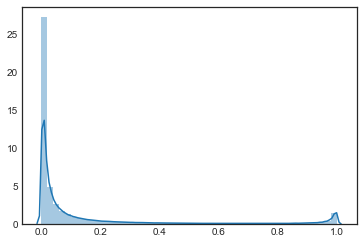

In [45]:
sns.distplot(x.flatten())

In [46]:
# t = -0.12
t = 0.5
xp = np.int32(x > t)
xps = np.sum(xp,axis=1)
print(xps.shape)
print(xps.min(),xps.mean(),xps.max())

(31072,)
0 2.898300720906282 8


In [47]:
print(np.mean(xp,axis=0))

[0.6493 0.0694 0.1469 0.0904 0.096  0.1532 0.0821 0.1211 0.0024 0.0025 0.0018
 0.0484 0.0474 0.0301 0.0466 0.0009 0.0886 0.028  0.0851 0.1628 0.0165 0.1925
 0.0569 0.1217 0.0277 0.4841 0.0451 0.001 ]


In [48]:
# proportion of zero predictions
print(sum(xps==0)/x.shape[0])

0.00035401647785787845


In [49]:
f1_score(y, xp, average='macro')

0.5595538090870308

In [50]:
# make sure every image has at least one prediction
x1 = x.copy()
for i in range(x.shape[0]):
    x1[i,np.argmax(x[i])] = 30

In [51]:
t = 0.53
x1p = np.int32(x1 > t)
x1ps = np.sum(x1p,axis=1)
print(x1ps.shape)
print(x1ps.min(),x1ps.mean(),x1ps.max())

# proportion of zero predictions
print(sum(x1ps==0)/x1.shape[0])

f1_score(y, x1p, average='macro')

(31072,)
1 2.787203913491246 8
0.0


0.570087685441356

In [52]:
# custom thresholds to match observed proportions
thresholds = np.linspace(1.0, 0.0, 1001)
pred = x.copy()
for j in range(pred.shape[1]):
    for t in thresholds:
        pred[:,j] = (x[:,j] > t).astype(int)
        prop = np.mean(pred[:,j])
        if prop >= ymean[j]: break
    print(j,'%6.4f' % t,'%6.4f' % ymean[j],'%6.4f' % prop, LABEL_MAP[j])
print(f1_score(y, pred, average='macro'))

0 0.9380 0.4147 0.4155 Nucleoplasm
1 0.9610 0.0404 0.0404 Nuclear membrane
2 0.7090 0.1165 0.1167 Nucleoli
3 0.8740 0.0502 0.0502 Nucleoli fibrillar center
4 0.9120 0.0598 0.0598 Nuclear speckles
5 0.7860 0.0809 0.0809 Nuclear bodies
6 0.9240 0.0324 0.0324 Endoplasmic reticulum
7 0.7250 0.0908 0.0909 Golgi apparatus
8 0.9190 0.0017 0.0017 Peroxisomes
9 0.8830 0.0014 0.0014 Endosomes
10 0.9060 0.0009 0.0009 Lysosomes
11 0.7270 0.0352 0.0353 Intermediate filaments
12 0.9290 0.0221 0.0222 Actin filaments
13 0.8070 0.0173 0.0173 Focal adhesion sites
14 0.9300 0.0343 0.0344 Microtubules
15 0.6910 0.0007 0.0007 Microtubule ends
16 0.9020 0.0171 0.0173 Cytokinetic bridge
17 0.9410 0.0068 0.0069 Mitotic spindle
18 0.8760 0.0290 0.0292 Microtubule organizing center
19 0.8410 0.0477 0.0479 Centrosome
20 0.9290 0.0055 0.0056 Lipid droplets
21 0.7790 0.1216 0.1219 Plasma membrane
22 0.8930 0.0258 0.0259 Cell junctions
23 0.7700 0.0954 0.0955 Mitochondria
24 0.9380 0.0104 0.0104 Aggresome
25 0.8860

In [53]:
# estimate thresholds by least squares, from iafoss kernel
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.95*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params, maxfev=10000)
    return p

In [54]:
# #  pred = sigmoid_np(x)
# pred = x
# print(pred.min(),pred.mean(),pred.max())
# name_label_dict = LABEL_MAP
# th = fit_val(pred,y)
# # th[th<0.1] = 0.1
# print('Thresholds: ',th)
# print('F1 macro: ',f1_score(y, pred>th, average='macro'))
# # print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
# print('F1 micro: ',f1_score(y, pred>th, average='micro'))

In [55]:
pred = x
num_classes = x.shape[1]
print(pred.min(),pred.mean(),pred.max(),num_classes)
name_label_dict = LABEL_MAP
th = np.zeros(num_classes)
for i in range(num_classes):
    th[i] = fit_val1(pred[:,i],y[:,i])
# th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

9.017364594412242e-11 0.13291015708227757 0.9999999943362174 28
Thresholds:  [0.8984 0.963  0.7587 0.9023 0.9011 0.847  0.913  0.7841 0.9334 0.8686 0.8917
 0.8552 0.932  0.8804 0.9016 0.9343 0.8569 0.9612 0.8316 0.847  0.946  0.7408
 0.8836 0.8022 0.9658 0.8215 0.9606 0.8812]
F1 macro:  0.6863033614512318
F1 micro:  0.7504861530208544


In [56]:
# estimate thresholds by line search on observed proportions
def prop_mse(preds, targs, th=0.5):
    pm = np.mean((preds>th))
    tm = np.mean(targs)
#     print(th,pm,tm)
    return (tm - pm)**2
#     return (np.mean(targs) - np.mean((preds>th)))**2

def fit_val2(x, y, start=0.54):
    params = np.array([start])
    wd = 1e-5
#     error = lambda p: np.array(F1_hard(x,y,p), wd*(p - 0.5))
    error = lambda p: np.array(prop_mse(x,y,p))
#     p = opt.minimize_scalar(error, bounds=[0.,1.0], method='bounded').x
    p = opt.minimize_scalar(error, bounds=[0.4,0.6], method='bounded').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='brent').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='golden').x
    return p

In [57]:
# prop_mse(pred[:,0],y[:,0], 0.618)

In [58]:
# fit_val2(pred[:,0],y[:,0])

In [59]:
pred = x
num_classes = x.shape[1]
print(pred.min(),pred.mean(),pred.max(),num_classes)
name_label_dict = LABEL_MAP
th = np.zeros(num_classes)
for i in range(num_classes):
    th[i] = fit_val2(pred[:,i],y[:,i])
# th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

9.017364594412242e-11 0.13291015708227757 0.9999999943362174 28
Thresholds:  [0.5998 0.5988 0.5983 0.5984 0.5984 0.5996 0.5996 0.5961 0.5528 0.5515 0.5688
 0.5981 0.599  0.5932 0.5973 0.5528 0.5997 0.5988 0.5998 0.5999 0.5942 0.5995
 0.5996 0.5994 0.5967 0.5999 0.5984 0.5901]
F1 macro:  0.5934412912025333
F1 micro:  0.6811934191196264


In [60]:
np.mean(pred[:,0] > 0.618)

0.60923017507724

In [61]:
# model- and class-specific thresholds 
# compute best threshold to maximize f1 score by grid search

thresholds = np.linspace(0, 1.0, 101)

fm = [[f1_score(y[:,j], (x[:,j] > t).astype(int)) \
       for t in thresholds] for j in range(y.shape[1])]

besti = [np.argmax(f) for f in fm]
bestt = [thresholds[b] for b in besti]
bests = [f[b] for f,b in zip(fm,besti)]

# td = {}
# print(special)
# for j in range(y.shape[1]):
#     # print(j, "%4.2f" % bestt[j], "%6.4f" % bests[j], LABEL_MAP[j])
    
#     plt.plot(thresholds, fm[j])
#     plt.plot(bestt[j], bests[j], "xr", label="best")
#     plt.xlabel("threshold")
#     plt.ylabel("f1")
#     plt.title(LABEL_MAP[j] + " f1 vs threshold (%6.4f, %6.4f)" % (bestt[j], bests[j]))
#     plt.legend()
#     plt.show()
#     plt.gcf().clear()
 
print(special)
for j in range(y.shape[1]):
    print(j, "%5.3f" % bestt[j], "%6.4f" % bests[j], LABEL_MAP[j])
    
print(np.mean(bests))   

air_h68
0 0.900 0.8372 Nucleoplasm
1 0.960 0.8353 Nuclear membrane
2 0.760 0.8008 Nucleoli
3 0.900 0.7605 Nucleoli fibrillar center
4 0.910 0.7913 Nuclear speckles
5 0.830 0.6861 Nuclear bodies
6 0.910 0.5888 Endoplasmic reticulum
7 0.780 0.8022 Golgi apparatus
8 0.930 0.8952 Peroxisomes
9 0.860 0.8667 Endosomes
10 0.910 0.8571 Lysosomes
11 0.830 0.7533 Intermediate filaments
12 0.950 0.7305 Actin filaments
13 0.880 0.7156 Focal adhesion sites
14 0.900 0.8709 Microtubules
15 0.930 0.5625 Microtubule ends
16 0.860 0.3454 Cytokinetic bridge
17 0.960 0.3852 Mitotic spindle
18 0.830 0.4921 Microtubule organizing center
19 0.840 0.6053 Centrosome
20 0.970 0.5825 Lipid droplets
21 0.700 0.6895 Plasma membrane
22 0.880 0.6103 Cell junctions
23 0.800 0.8141 Mitochondria
24 0.960 0.6411 Aggresome
25 0.830 0.7028 Cytosol
26 0.960 0.5947 Cytoplasmic bodies
27 0.960 0.5000 Rods & rings
0.6898964848791919


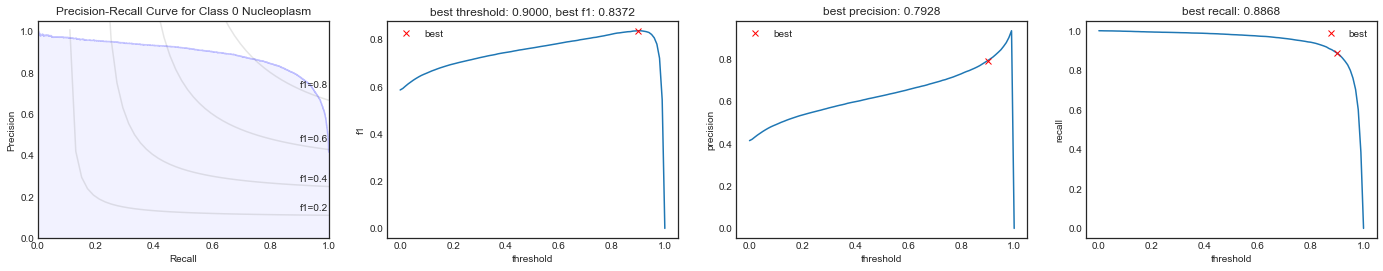

<Figure size 432x288 with 0 Axes>

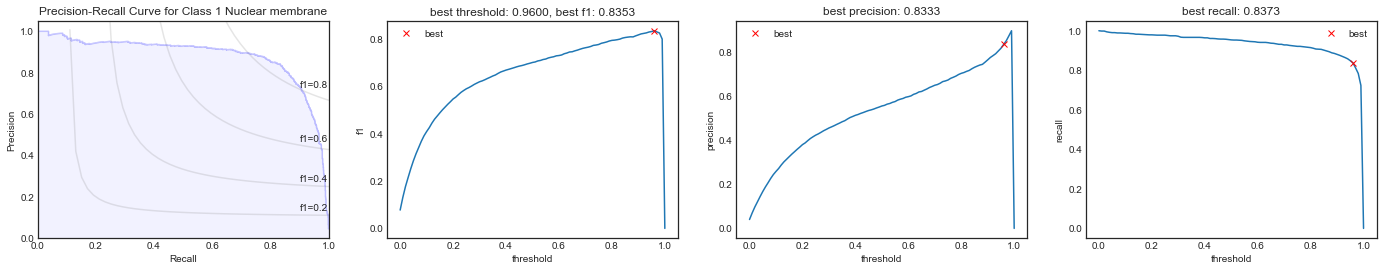

<Figure size 432x288 with 0 Axes>

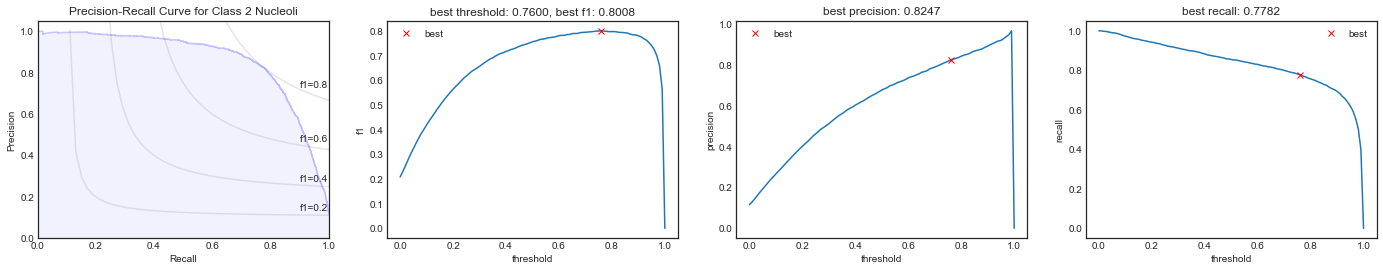

<Figure size 432x288 with 0 Axes>

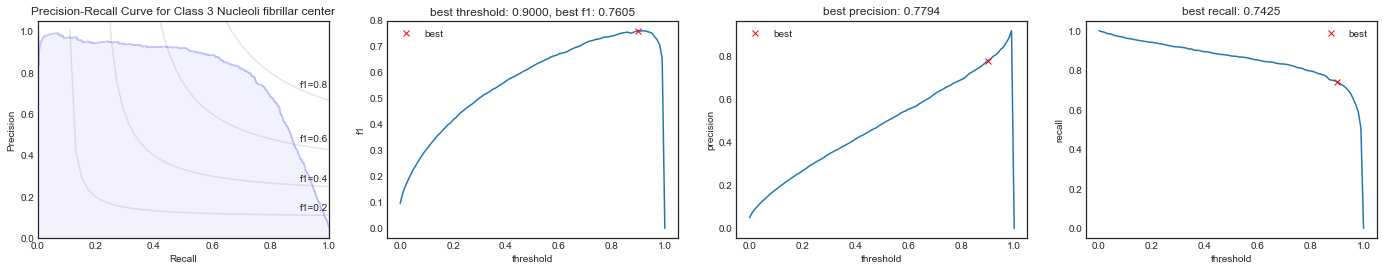

<Figure size 432x288 with 0 Axes>

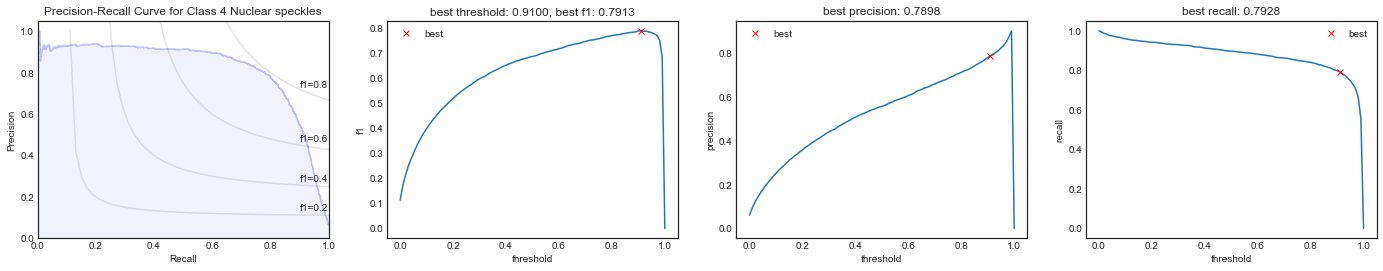

<Figure size 432x288 with 0 Axes>

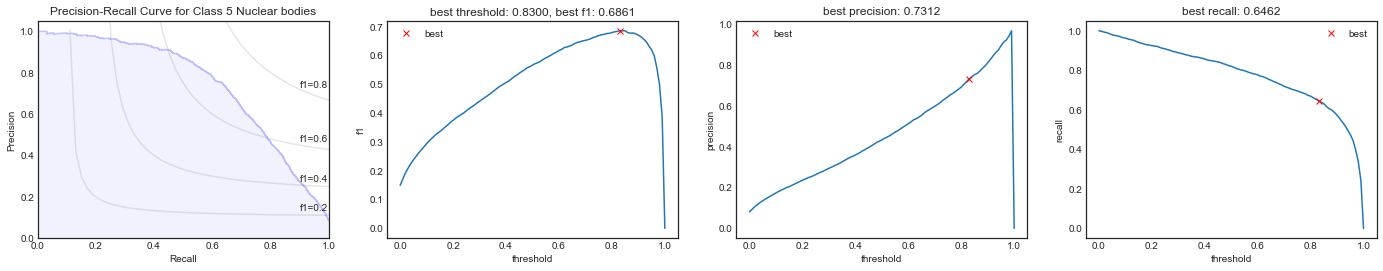

<Figure size 432x288 with 0 Axes>

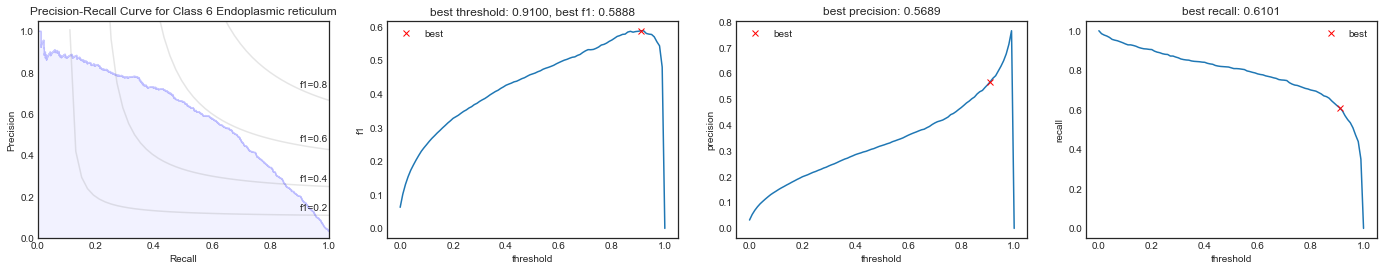

<Figure size 432x288 with 0 Axes>

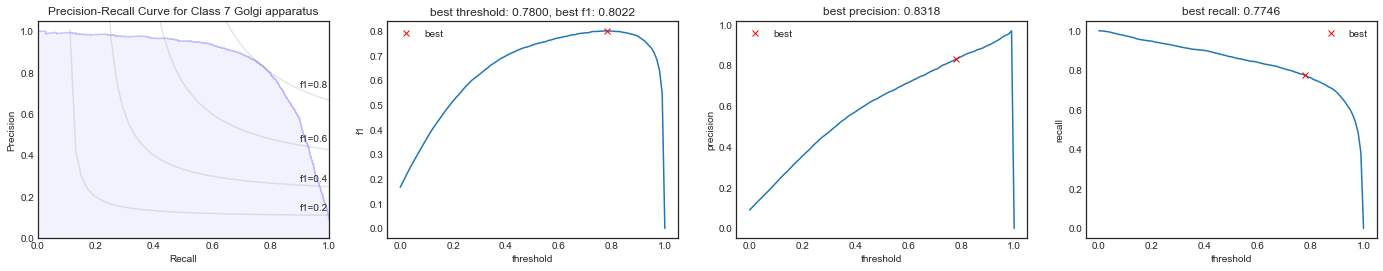

<Figure size 432x288 with 0 Axes>

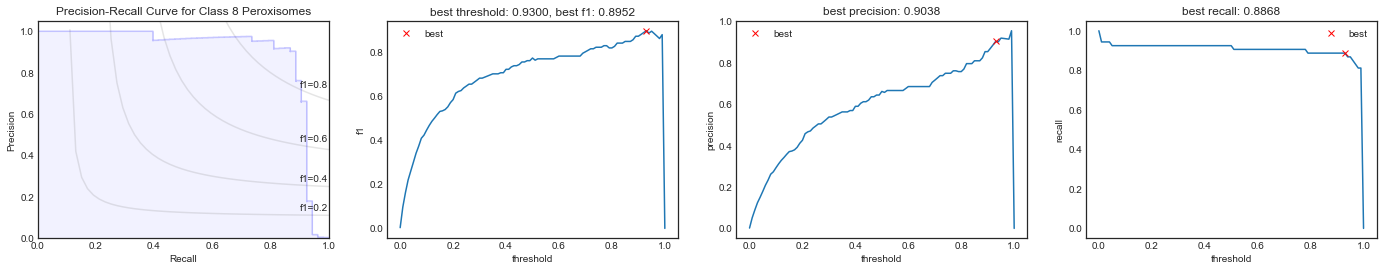

<Figure size 432x288 with 0 Axes>

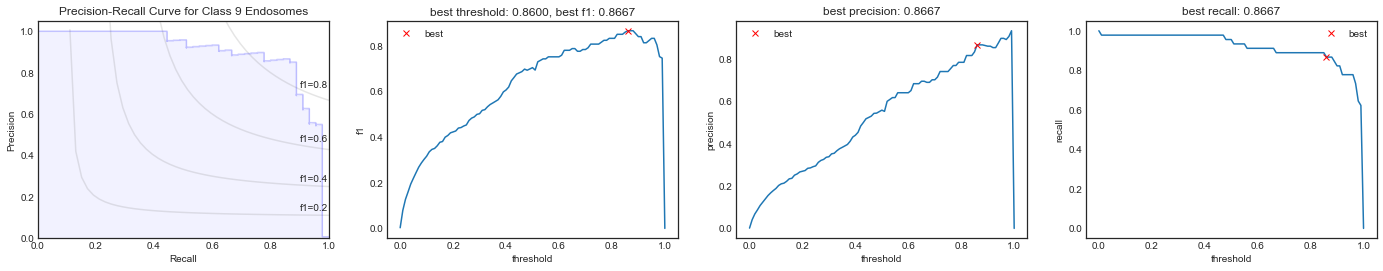

<Figure size 432x288 with 0 Axes>

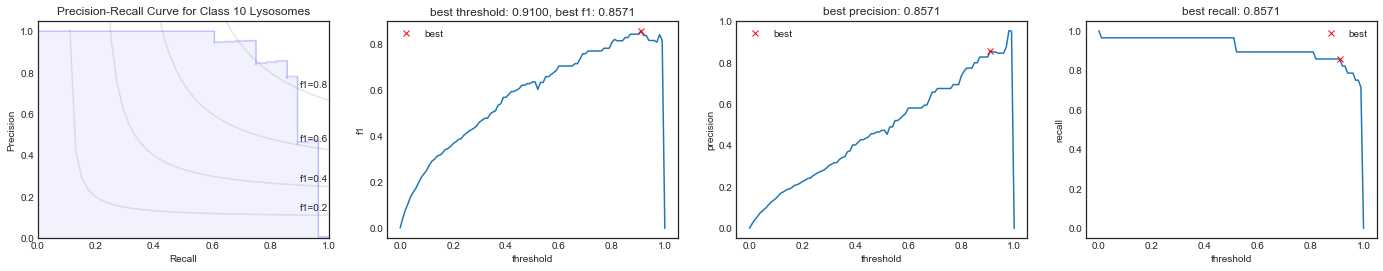

<Figure size 432x288 with 0 Axes>

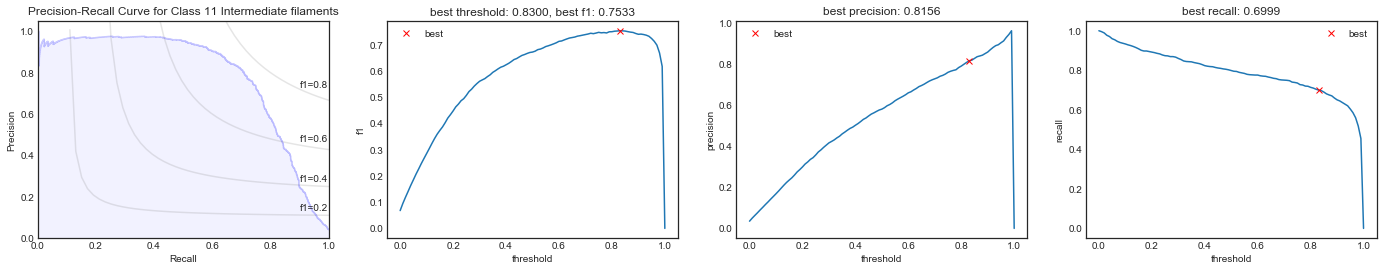

<Figure size 432x288 with 0 Axes>

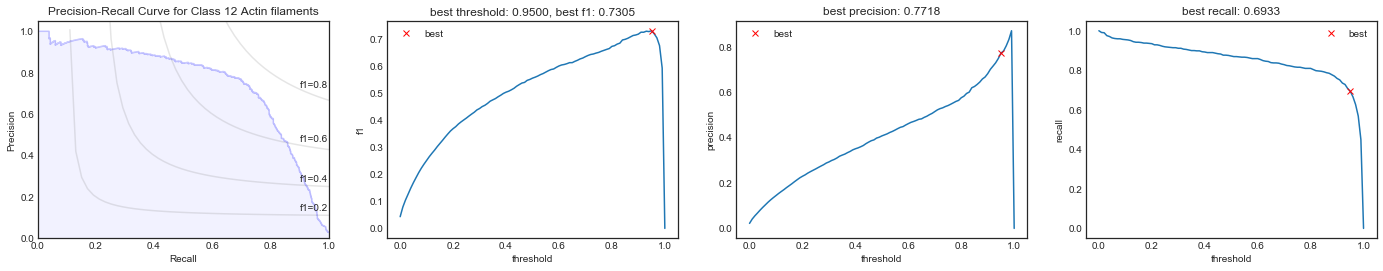

<Figure size 432x288 with 0 Axes>

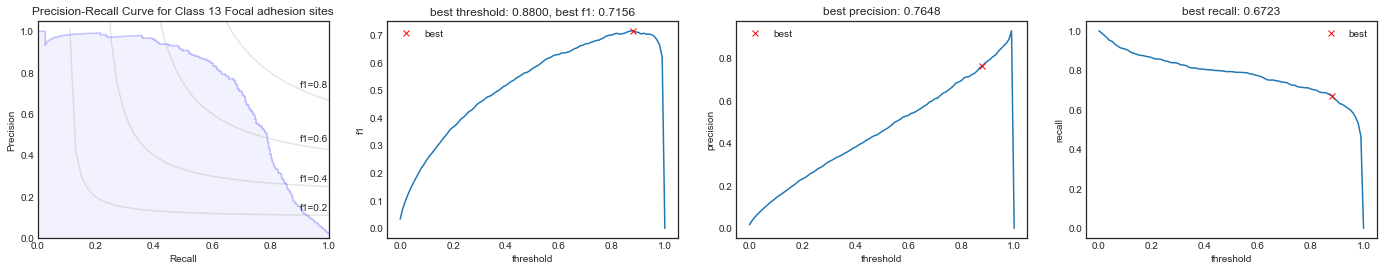

<Figure size 432x288 with 0 Axes>

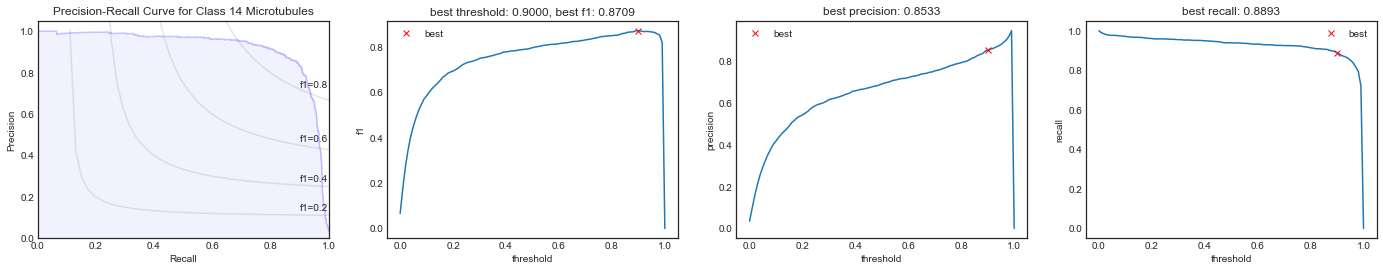

<Figure size 432x288 with 0 Axes>

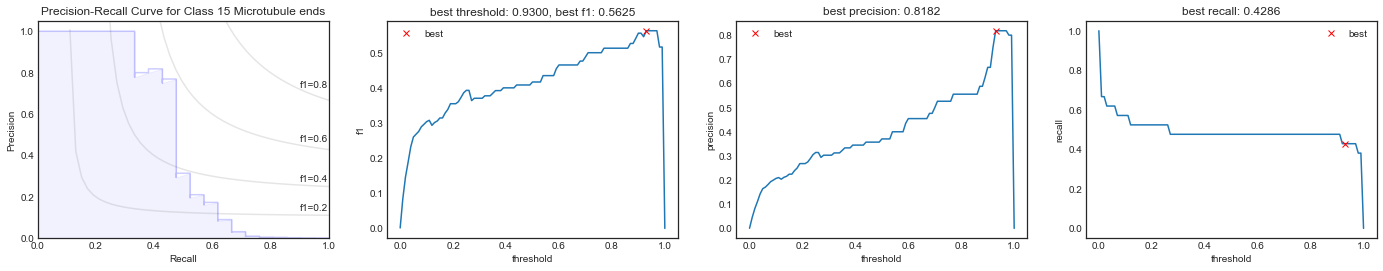

<Figure size 432x288 with 0 Axes>

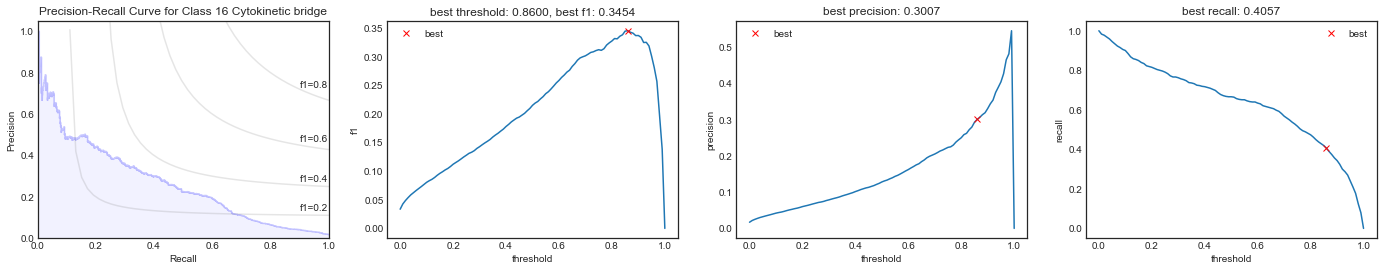

<Figure size 432x288 with 0 Axes>

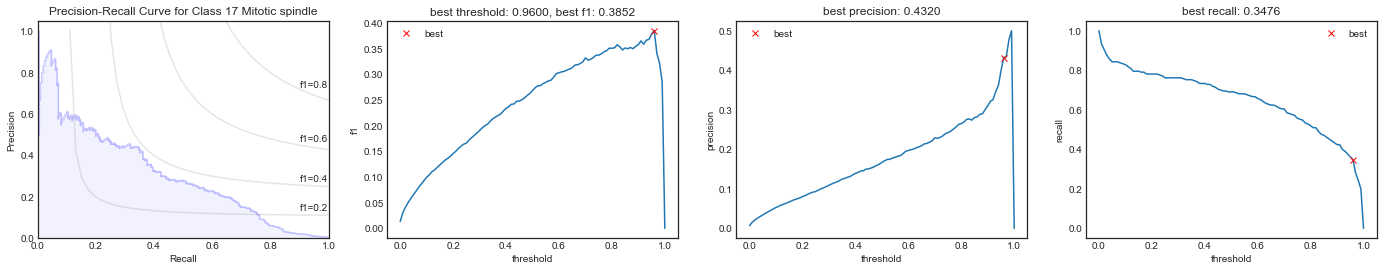

<Figure size 432x288 with 0 Axes>

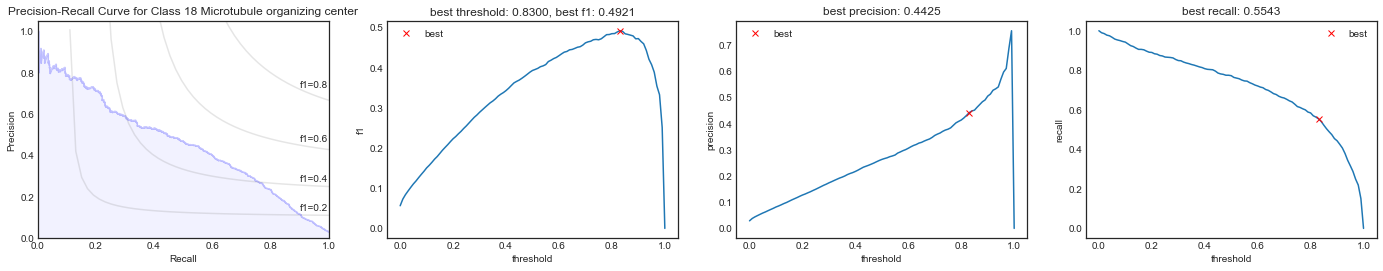

<Figure size 432x288 with 0 Axes>

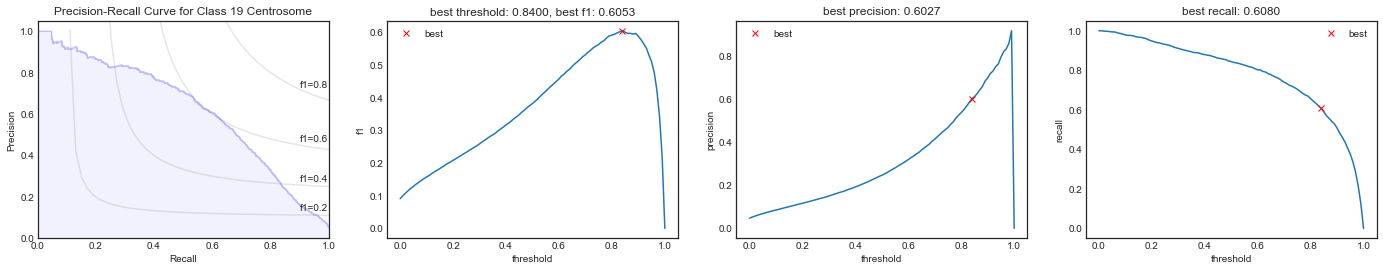

<Figure size 432x288 with 0 Axes>

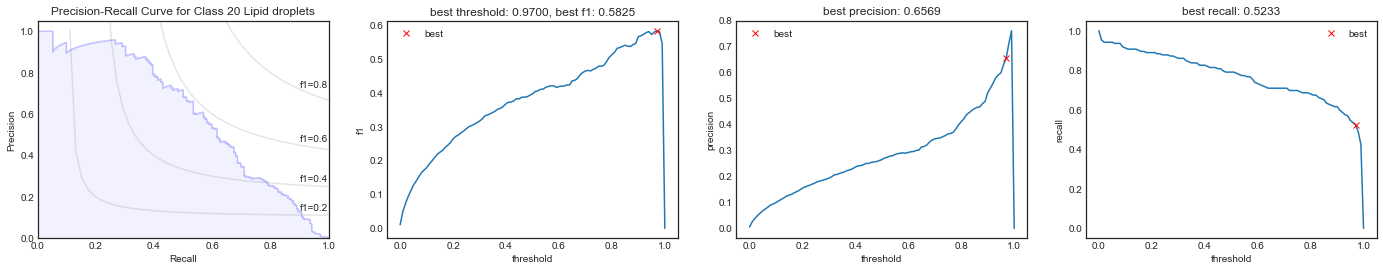

<Figure size 432x288 with 0 Axes>

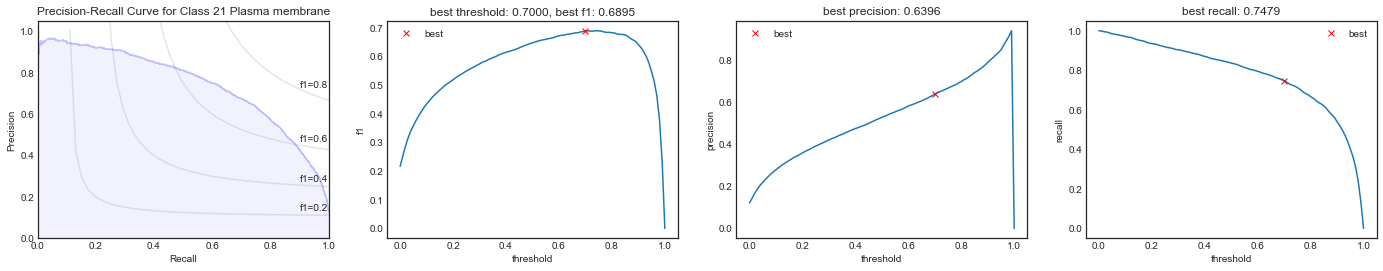

<Figure size 432x288 with 0 Axes>

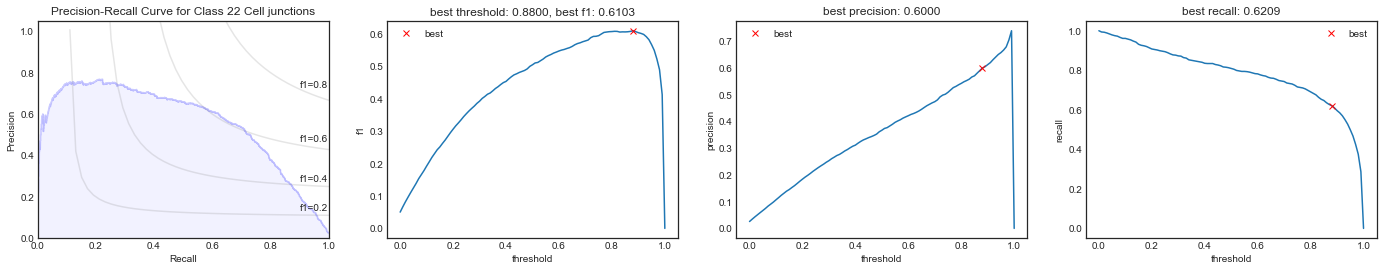

<Figure size 432x288 with 0 Axes>

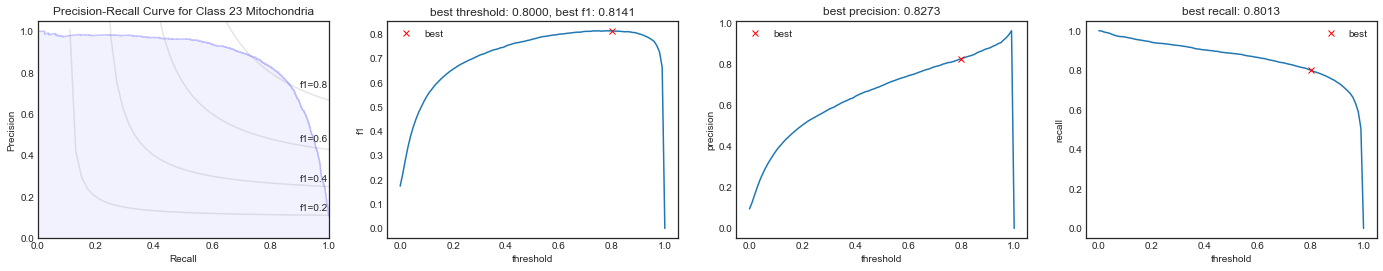

<Figure size 432x288 with 0 Axes>

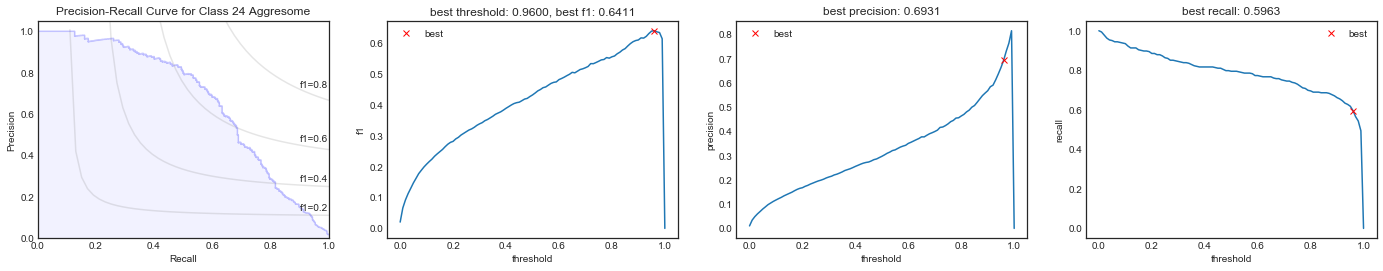

<Figure size 432x288 with 0 Axes>

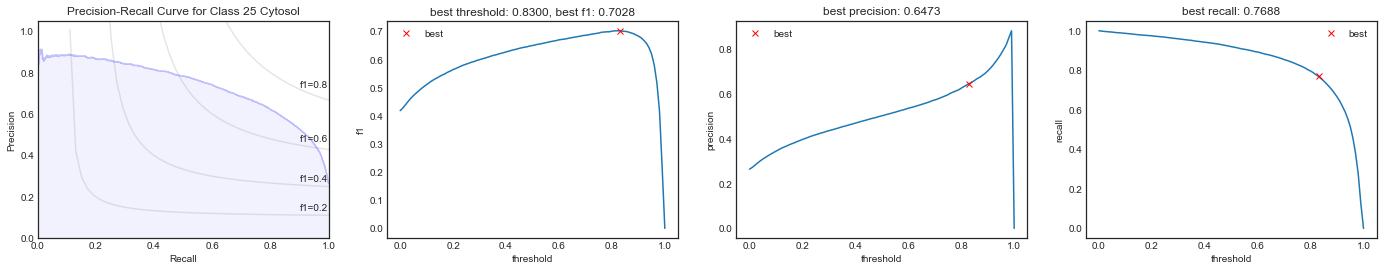

<Figure size 432x288 with 0 Axes>

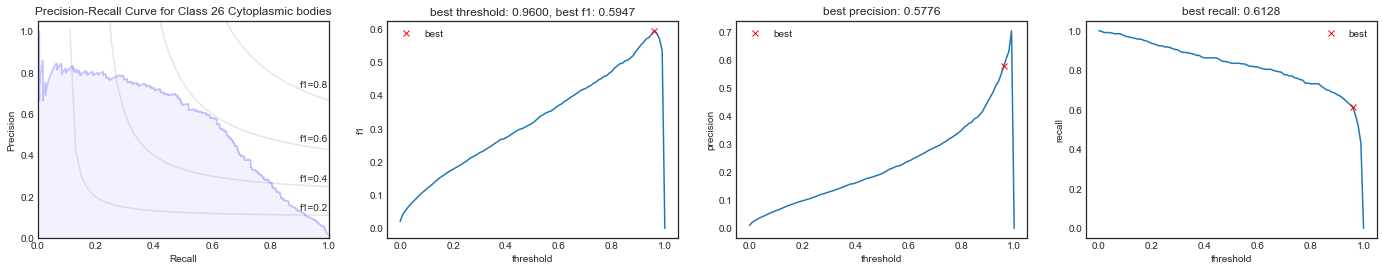

<Figure size 432x288 with 0 Axes>

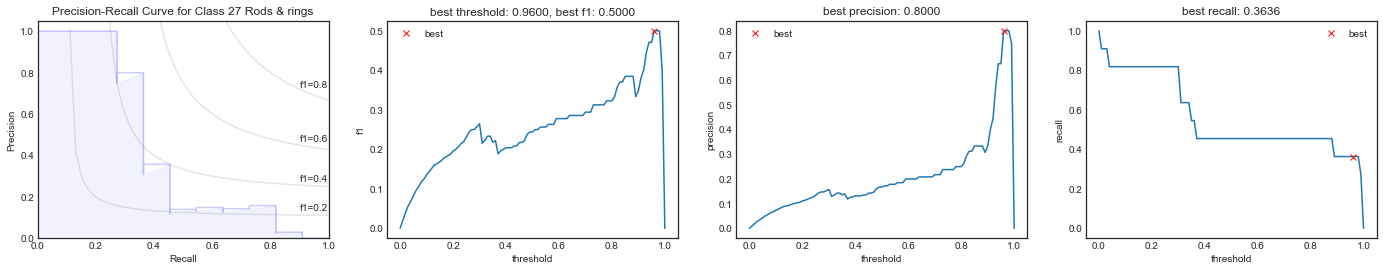

<Figure size 432x288 with 0 Axes>

In [62]:
n_classes = 28

# plot precision-recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()
f_scores = np.linspace(0.2, 0.8, num=4)

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y[:, i], x[:, i])
    average_precision[i] = average_precision_score(y[:, i], x[:, i])
    
#     plt.figure()
    
#     for f_score in f_scores:
#         xf = np.linspace(0.01, 1)
#         yf = f_score * xf / (2 * xf - f_score)
#         l, = plt.plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
#         plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

#     plt.step(recall[i], precision[i], color='b', alpha=0.2, where='post')
#     plt.fill_between(recall[i], precision[i], alpha=0.05, color='b')

#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
#     plt.title(LABEL_MAP[i])
    
    
    fig, axs = plt.subplots(1, 4, figsize=(24, 4))
    
    for f_score in f_scores:
        xf = np.linspace(0.01, 1)
        yf = f_score * xf / (2 * xf - f_score)
        l, = axs[0].plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
        axs[0].annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

    axs[0].step(recall[i], precision[i], color='b', alpha=0.2, where='post')
    axs[0].fill_between(recall[i], precision[i], alpha=0.05, color='b')

    axs[0].set_xlabel('Recall')
    axs[0].set_ylabel('Precision')
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_title('Precision-Recall Curve for Class ' + str(i) + ' ' + LABEL_MAP[i])
    
    
#     thresholds = np.linspace(0.4, 0.6, 101)
    thresholds = np.linspace(0., 1.0, 101)
    # for ranks
    # thresholds = np.linspace(0.8, 1.0, 101)
    fm = [f1_score(y[:,i], (x[:,i] > t).astype(int)) for t in thresholds] 

    besti = np.argmax(fm)
    bestt = thresholds[besti]
    bests = fm[besti] 
        
    axs[1].plot(thresholds, fm)
    axs[1].plot(bestt, bests, "xr", label="best")
    axs[1].set_xlabel("threshold")
    axs[1].set_ylabel("f1")
    axs[1].set_title("best threshold: %6.4f, best f1: %6.4f" % (bestt, bests))
    axs[1].legend()

    pm = [precision_score(y[:,i], (x[:,i] > t).astype(int)) for t in thresholds] 
    bestsp = pm[besti] 
        
    axs[2].plot(thresholds, pm)
    axs[2].plot(bestt, bestsp, "xr", label="best")
    axs[2].set_xlabel("threshold")
    axs[2].set_ylabel("precision")
    axs[2].set_title("best precision: %6.4f" % (bestsp))
    axs[2].legend()
    
    rm = [recall_score(y[:,i], (x[:,i] > t).astype(int)) for t in thresholds] 
    bestsr = rm[besti] 
        
    axs[3].plot(thresholds, rm)
    axs[3].plot(bestt, bestsr, "xr", label="best")
    axs[3].set_xlabel("threshold")
    axs[3].set_ylabel("recall")
    axs[3].set_title("best recall: %6.4f" % (bestsr))
    axs[3].legend()
    
    plt.show()
    plt.gcf().clear()

In [63]:
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y.ravel(), x.ravel())

average_precision["macro"] = average_precision_score(y, x, average="macro")
print('Average precision score, macro-averaged over all classes: {0:0.3f}'
      .format(average_precision["macro"]))

average_precision["micro"] = average_precision_score(y, x, average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.3f}'
      .format(average_precision["micro"]))


Average precision score, macro-averaged over all classes: 0.704
Average precision score, micro-averaged over all classes: 0.795


In [64]:
# for i in range(len(th)):
#     print(i,np.round(th[i],decimals=2))

In [65]:
# print(np.mean(x > th,axis=0))

In [66]:
# f1_score(y, xp, average='samples')

In [67]:
f1_score(y, xp, average='micro')

0.6451525866598503

In [68]:
z = [(y,x) for y,x in zip(y,xp) if np.sum(x) == 0]
print(len(z))

11


In [69]:
# z[:5]

In [70]:
yz = np.array([t[0] for t in z])
xz = np.array([t[1] for t in z])
f1_score(yz,xz,average='macro')

0.0

0.0 0.6607037088740872 1.0


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


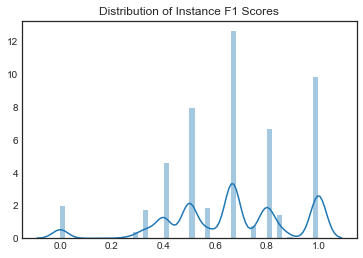

<Figure size 432x288 with 0 Axes>

In [71]:
f1b = np.array([f1_score(yi, xpi, average='binary') \
                 for yi,xpi in zip(y,xp)])
print(f1b.min(),f1b.mean(),f1b.max())
sns.distplot(f1b)
plt.title("Distribution of Instance F1 Scores")
plt.show()
plt.gcf().clear()

In [72]:
np.set_printoptions(precision=3, linewidth=200, suppress=True)
f = []
for m in mnames:
    ff = np.array(list(vp[m])).flatten()
    print(m, ff.shape)
    f.append(ff)
# print(mnames)
r = np.corrcoef(f)
print(r)   

air_g68 (870016,)
air_h68 (870016,)
airx_h67 (870016,)
cbam_h67 (870016,)
iv3_g11 (870016,)
iv3_h11 (870016,)
preresnet_g67 (870016,)
preresnet_h67 (870016,)
se_resnext_g30 (870016,)
se_resnext_h30 (870016,)
[[1.    0.923 0.867 0.884 0.818 0.832 0.93  0.907 0.904 0.901]
 [0.923 1.    0.909 0.929 0.852 0.898 0.909 0.952 0.889 0.931]
 [0.867 0.909 1.    0.915 0.837 0.886 0.873 0.916 0.855 0.897]
 [0.884 0.929 0.915 1.    0.865 0.906 0.893 0.934 0.874 0.917]
 [0.818 0.852 0.837 0.865 1.    0.919 0.828 0.855 0.82  0.856]
 [0.832 0.898 0.886 0.906 0.919 1.    0.843 0.897 0.835 0.897]
 [0.93  0.909 0.873 0.893 0.828 0.843 1.    0.933 0.902 0.903]
 [0.907 0.952 0.916 0.934 0.855 0.897 0.933 1.    0.891 0.933]
 [0.904 0.889 0.855 0.874 0.82  0.835 0.902 0.891 1.    0.943]
 [0.901 0.931 0.897 0.917 0.856 0.897 0.903 0.933 0.943 1.   ]]


In [73]:
loc = [i for i,m in enumerate(mnames) if m == special][0]
rloc = r[:,loc]
print(rloc)
order = np.argsort(rloc)
for i in range(1,min(len(rloc)+1,7)):
    print('%5.3f' % rloc[order[-i]],mnames[order[-i]])

[0.923 1.    0.909 0.929 0.852 0.898 0.909 0.952 0.889 0.931]
1.000 air_h68
0.952 preresnet_h67
0.931 se_resnext_h30
0.929 cbam_h67
0.923 air_g68
0.909 airx_h67


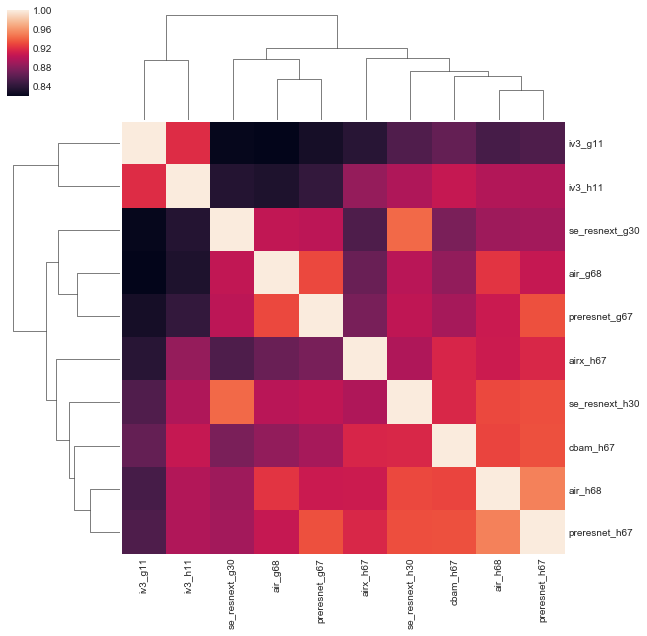

In [74]:
d = pd.DataFrame(r, columns=mnames)
d['id'] = mnames
d.set_index('id',inplace=True)
del d.index.name

sns.clustermap(d)


# import scipy.cluster.hierarchy as hc
# from matplotlib import pyplot
# link = hc.linkage(d.values, method='centroid')
# o1 = hc.leaves_list(link)

# mat = d.iloc[o1,:]
# mat = mat.iloc[:, o1[::-1]]
# pyplot.imshow(mat)

In [75]:
# f = []
# for m in mnames:
#     f.append(np.array(list(vp[m])).flatten())
# print(mnames)
# print(np.corrcoef(f))   

In [76]:
print(f[0].min(),f[0].max())

5.199339475012162e-10 0.9999999200061678


In [77]:
# # model-specific global thresholds
# # compute best single logit threshold for computed ensemble

# # for probabilities
# thresholds = np.linspace(0.1, 0.9, 1001)

# # for logits
# # thresholds = np.linspace(-1, 1, 101)

# # for ranks
# # thresholds = np.linspace(0.9, 1, 101)

# # thresholds = [-0.4]

# fname = 'mthresh.pkl'
# if os.path.isfile(fname): mthresh = pickle.load(open(fname,'rb'))
# else: mthresh = {}
# # mthresh = {}

# for i in range(nm):
# # for i in [3]:

#     mname = vp.columns[i+offset]

#     tv = np.array(list(vp.iloc[:,offset+i].values))
    
#     if mname in mthresh or np.sum(np.isnan(tv)) > 0: continue

#     scores = np.array([f1_score(y, np.int32(tv > threshold),
#                                  average='macro') for threshold in thresholds])

#     besta = np.argmax(scores)
#     threshold_best = thresholds[besta]
#     score_best = scores[besta]
#     print(i, mname, "%4.2f" % threshold_best, "%6.4f" % score_best)
#     mthresh[mname] = threshold_best
    
#     plt.plot(thresholds, scores)
#     plt.plot(threshold_best, score_best, "xr", label="best")
#     plt.xlabel("threshold")
#     plt.ylabel("f1")
# #     plt.title(mname + " f1 vs threshold (%6.4f, %6.4f)" % (threshold_best, score_best))
#     plt.title(mname + " threshold: %6.4f  f1: %6.4f" % (threshold_best, score_best))
#     plt.legend()
#     plt.show()
#     plt.gcf().clear()

# pickle.dump(mthresh,open(fname,'wb'))
# print(mthresh)

In [78]:
print(vp.columns, vp.shape)

Index(['Target', 'fold', 'y', 'air_g68', 'air_h68', 'airx_h67', 'cbam_h67',
       'iv3_g11', 'iv3_h11', 'preresnet_g67', 'preresnet_h67',
       'se_resnext_g30', 'se_resnext_h30'],
      dtype='object') (31072, 13)


In [79]:
# # model- and class-specific thresholds
# # compute best logit threshold for computed ensemble

# # thresholds = np.linspace(-2, 2, 101)

# # thresholds = [-0.4]

# fname = 'cthresh.pkl'
# # if os.path.isfile(fname): cthresh = pickle.load(open(fname,'rb'))
# cthresh = {}

# for i in range(nm):
# # for i in [2]:

#     mname = vp.columns[i+offset]
#     tv = np.array(list(vp.iloc[:,offset+i].values))

#     fm = [[f1_score(y[:,j], (tv[:,j] > t).astype(int)) \
#            for t in thresholds] for j in range(y.shape[1])]
    
#     besti = [np.argmax(f) for f in fm]
#     bestt = [thresholds[b] for b in besti]
#     bests = [f[b] for f,b in zip(fm,besti)]
#     print(mname, np.mean(bests))
    
#     td = {}
#     for j in range(y.shape[1]):
#         # print()
#         # print(j, LABEL_MAP[j], "%4.2f" % bestt[j], "%6.4f" % bests[j])
        
#         # print(j, "%4.2f" % bestt[j], "%6.4f" % bests[j], LABEL_MAP[j])
        
#         # print(cm[j], '%4.2f' % fm[j])
#         # print('')
#         td[j] = np.round(bestt[j],decimals=2)
    
#     cthresh[mname] = td
#     print()
    
# pickle.dump(cthresh,open(fname,'wb'))
# # print(cthresh)
# print(fname)



hillclimbing f1 fold 0 class 0 Nucleoplasm

model 0 f1 0.8658 0.862 0.6988 0.913 air_g68
model 1 f1 0.8639 0.895 0.6829 0.912 air_h68
model 2 f1 0.8520 0.847 0.6297 0.873 airx_h67
model 3 f1 0.8618 0.890 0.6849 0.911 cbam_h67
model 4 f1 0.8555 0.950 0.6849 0.946 iv3_g11
model 5 f1 0.8516 0.902 0.6748 0.904 iv3_h11
model 6 f1 0.8641 0.873 0.6825 0.935 preresnet_g67
model 7 f1 0.8632 0.847 0.6939 0.906 preresnet_h67
model 8 f1 0.8602 0.846 0.6838 0.856 se_resnext_g30
model 9 f1 0.8629 0.842 0.6963 0.835 se_resnext_h30
0  train 0.8658  val 0.6988*   air_g68
1  train 0.8694  val 0.7108*   cbam_h67
2  train 0.8712  val 0.7092    preresnet_g67
3  train 0.8723  val 0.7125*   se_resnext_g30
4  train 0.8728  val 0.7131*   preresnet_h67
    try dropping 0 air_g68 0.8731 0.7124
    try dropping 3 cbam_h67 0.8717 0.7115
    try dropping 6 preresnet_g67 0.8723 0.7149
    try dropping 8 se_resnext_g30 0.8715 0.7150
    try dropping 7 preresnet_h67 0.8719 0.7127
    try dropping 3 cbam_h67 0.8717 0

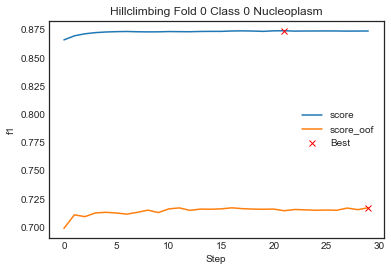

    step  midx     score  score_oof             mod      f1_0
0      0     0  0.865808   0.698776         air_g68  0.865808
1      1     3  0.869421   0.710817        cbam_h67  0.861839
2      2     6  0.871219   0.709200   preresnet_g67  0.864127
3      3     8  0.872267   0.712500  se_resnext_g30  0.860187
4      4     7  0.872815   0.713057   preresnet_h67  0.863235
5      5     3  0.873121   0.712422        cbam_h67  0.861839
6      6     5  0.873266   0.711424         iv3_h11  0.851569
7      7     4  0.873019   0.713043         iv3_g11  0.855522
8      8     9  0.872922   0.714971  se_resnext_h30  0.862937
9      9     3  0.872962   0.712819        cbam_h67  0.861839
10    10     0  0.873202   0.716095         air_g68  0.865808
11    11     4  0.873119   0.716951         iv3_g11  0.855522
12    12     6  0.873052   0.714782   preresnet_g67  0.864127
13    13     1  0.873275   0.715887         air_h68  0.863851
14    14     9  0.873363   0.715767  se_resnext_h30  0.862937
15    15

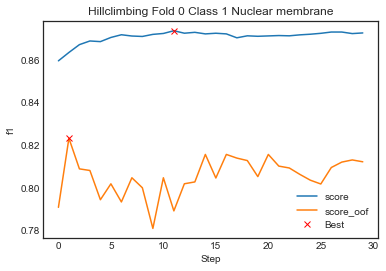

   step  midx     score  score_oof             mod      f1_0
0     0     7  0.859641   0.790805   preresnet_h67  0.859641
1     1     8  0.863570   0.823276  se_resnext_g30  0.840716

      weight             mod      f1_0
midx                                  
7          1   preresnet_h67  0.859641
8          1  se_resnext_g30  0.840716


hillclimbing f1 fold 0 class 2 Nucleoli

model 0 f1 0.8050 0.811 0.7989 0.826 air_g68
model 1 f1 0.8085 0.759 0.7888 0.835 air_h68
model 2 f1 0.8022 0.732 0.7904 0.756 airx_h67
model 3 f1 0.7972 0.803 0.7810 0.677 cbam_h67
model 4 f1 0.7677 0.951 0.7691 0.933 iv3_g11
model 5 f1 0.7664 0.825 0.7483 0.837 iv3_h11
model 6 f1 0.8011 0.738 0.7933 0.803 preresnet_g67
model 7 f1 0.7981 0.739 0.7917 0.808 preresnet_h67
model 8 f1 0.7830 0.613 0.7710 0.709 se_resnext_g30
model 9 f1 0.7978 0.628 0.7803 0.649 se_resnext_h30
0  train 0.8085  val 0.7888*   air_h68
1  train 0.8149  val 0.7949*   preresnet_g67
2  train 0.8153  val 0.7984*   airx_h67
3  train 0.8163

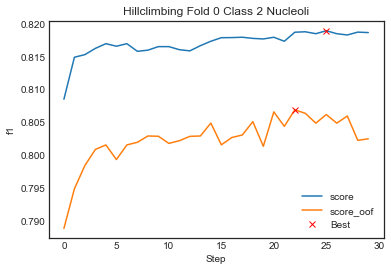

    step  midx     score  score_oof             mod      f1_0
0      0     1  0.808543   0.788845         air_h68  0.808543
1      1     6  0.814941   0.794887   preresnet_g67  0.801057
2      2     2  0.815341   0.798445        airx_h67  0.802219
3      3     0  0.816295   0.800890         air_g68  0.805010
4      4     3  0.817010   0.801574        cbam_h67  0.797192
5      5     6  0.816622   0.799346   preresnet_g67  0.801057
6      6     3  0.817010   0.801574        cbam_h67  0.797192
7      7     8  0.815845   0.801975  se_resnext_g30  0.783014
8      8     6  0.816021   0.802936   preresnet_g67  0.801057
9      9     6  0.816561   0.802895   preresnet_g67  0.801057
10    10     3  0.816561   0.801807        cbam_h67  0.797192
11    11     2  0.816094   0.802216        airx_h67  0.802219
12    12     6  0.815915   0.802879   preresnet_g67  0.801057
13    13     0  0.816702   0.802936         air_g68  0.805010
14    14     9  0.817381   0.804905  se_resnext_h30  0.797781
15    15

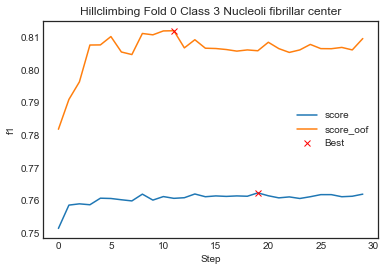

    step  midx     score  score_oof            mod      f1_0
0      0     1  0.751410   0.781784        air_h68  0.751410
1      1     7  0.758549   0.790918  preresnet_h67  0.749634
2      2     0  0.758938   0.796296        air_g68  0.721984
3      3     3  0.758656   0.807583       cbam_h67  0.731707
4      4     1  0.760666   0.807619        air_h68  0.751410
5      5     6  0.760578   0.810176  preresnet_g67  0.718704
6      6     1  0.760186   0.805447        air_h68  0.751410
7      7     1  0.759834   0.804665        air_h68  0.751410
8      8     3  0.761905   0.811122       cbam_h67  0.731707
9      9     3  0.760083   0.810707       cbam_h67  0.731707
10    10     1  0.761163   0.811900        air_h68  0.751410
11    11     0  0.760622   0.811958        air_g68  0.721984

      weight            mod      f1_0
midx                                 
0          2        air_g68  0.721984
1          5        air_h68  0.751410
3          3       cbam_h67  0.731707
6          1  pr

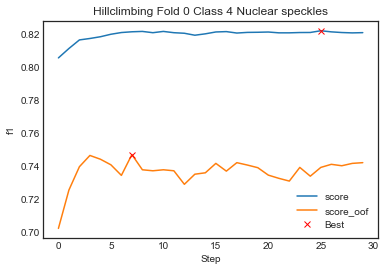

   step  midx     score  score_oof             mod      f1_0
0     0     1  0.805795   0.702259         air_h68  0.805795
1     1     8  0.811502   0.725564  se_resnext_g30  0.786510
2     2     7  0.816710   0.739726   preresnet_h67  0.804328
3     3     7  0.817587   0.746562   preresnet_h67  0.804328
4     4     2  0.818643   0.744275        airx_h67  0.800251
5     5     1  0.820153   0.740883         air_h68  0.805795
6     6     7  0.821201   0.734463   preresnet_h67  0.804328
7     7     4  0.821656   0.747082         iv3_g11  0.779672

      weight             mod      f1_0
midx                                  
1          2         air_h68  0.805795
2          1        airx_h67  0.800251
4          1         iv3_g11  0.779672
7          3   preresnet_h67  0.804328
8          1  se_resnext_g30  0.786510


hillclimbing f1 fold 0 class 5 Nuclear bodies

model 0 f1 0.6422 0.922 0.7513 0.842 air_g68
model 1 f1 0.6704 0.847 0.7270 0.777 air_h68
model 2 f1 0.6533 0.810 0.7275 0.757 a

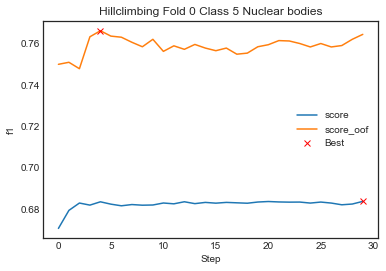

   step  midx     score  score_oof            mod      f1_0
0     0     3  0.670596   0.749827       cbam_h67  0.670596
1     1     7  0.679306   0.750809  preresnet_h67  0.670489
2     2     1  0.682850   0.747712        air_h68  0.670426
3     3     0  0.681847   0.763124        air_g68  0.642208
4     4     3  0.683446   0.766040       cbam_h67  0.670596

      weight            mod      f1_0
midx                                 
0          1        air_g68  0.642208
1          1        air_h68  0.670426
3          2       cbam_h67  0.670596
7          1  preresnet_h67  0.670489


hillclimbing f1 fold 0 class 6 Endoplasmic reticulum

model 0 f1 0.5745 0.847 0.5982 0.948 air_g68
model 1 f1 0.5724 0.862 0.6073 0.939 air_h68
model 2 f1 0.5637 0.820 0.5796 0.761 airx_h67
model 3 f1 0.5518 0.865 0.5941 0.910 cbam_h67
model 4 f1 0.5461 0.968 0.5928 0.984 iv3_g11
model 5 f1 0.5746 0.875 0.5965 0.975 iv3_h11
model 6 f1 0.5522 0.918 0.5802 0.970 preresnet_g67
model 7 f1 0.5539 0.908 0.6179 0

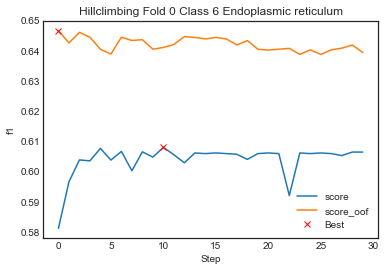

   step  midx    score  score_oof             mod     f1_0
0     0     9  0.58114   0.646604  se_resnext_h30  0.58114

      weight             mod     f1_0
midx                                 
9          1  se_resnext_h30  0.58114


hillclimbing f1 fold 0 class 7 Golgi apparatus

model 0 f1 0.7721 0.905 0.8680 0.951 air_g68
model 1 f1 0.7622 0.797 0.8464 0.775 air_h68
model 2 f1 0.7570 0.749 0.8038 0.748 airx_h67
model 3 f1 0.7533 0.679 0.8458 0.808 cbam_h67
model 4 f1 0.7392 0.929 0.8412 0.982 iv3_g11
model 5 f1 0.7261 0.746 0.8333 0.838 iv3_h11
model 6 f1 0.7598 0.797 0.8553 0.943 preresnet_g67
model 7 f1 0.7629 0.664 0.8466 0.840 preresnet_h67
model 8 f1 0.7490 0.766 0.8520 0.699 se_resnext_g30
model 9 f1 0.7510 0.671 0.8585 0.698 se_resnext_h30
0  train 0.7721  val 0.8680*   air_g68
1  train 0.7766  val 0.8624    preresnet_h67
2  train 0.7812  val 0.8652    se_resnext_g30
3  train 0.7835  val 0.8665    preresnet_g67
4  train 0.7827  val 0.8677    cbam_h67
    try dropping 0 air_g

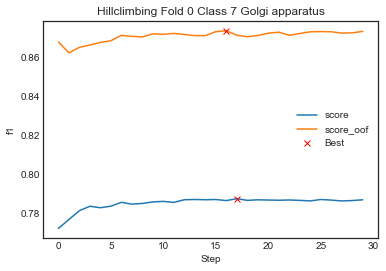

    step  midx     score  score_oof             mod      f1_0
0      0     0  0.772056   0.867998         air_g68  0.772056
1      1     7  0.776632   0.862414   preresnet_h67  0.762948
2      2     8  0.781207   0.865248  se_resnext_g30  0.748960
3      3     6  0.783462   0.866485   preresnet_g67  0.759822
4      4     3  0.782698   0.867749        cbam_h67  0.753283
5      5     0  0.783512   0.868649         air_g68  0.772056
6      6     0  0.785490   0.871401         air_g68  0.772056
7      7     0  0.784546   0.870907         air_g68  0.772056
8      8     3  0.784898   0.870588        cbam_h67  0.753283
9      9     0  0.785714   0.872180         air_g68  0.772056
10    10     9  0.785962   0.871930  se_resnext_h30  0.750958
11    11     0  0.785442   0.872397         air_g68  0.772056
12    12     3  0.786828   0.871854        cbam_h67  0.753283
13    13     4  0.786931   0.871272         iv3_g11  0.739191
14    14     0  0.786806   0.871264         air_g68  0.772056
15    15

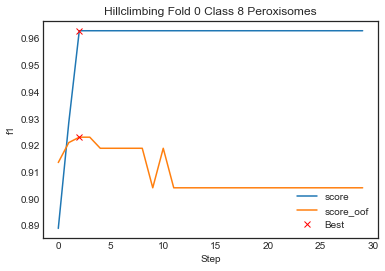

   step  midx     score  score_oof             mod      f1_0
0     0     9  0.888889   0.913580  se_resnext_h30  0.888889
1     1     6  0.928571   0.921053   preresnet_g67  0.857143
2     2     2  0.962963   0.923077        airx_h67  0.787879

      weight             mod      f1_0
midx                                  
2          1        airx_h67  0.787879
6          1   preresnet_g67  0.857143
9          1  se_resnext_h30  0.888889


hillclimbing f1 fold 0 class 9 Endosomes

model 0 f1 0.8000 0.616 0.8608 0.616 air_g68
model 1 f1 0.7692 0.616 0.9000 0.874 air_h68
model 2 f1 0.6667 0.384 0.7463 0.916 airx_h67
model 3 f1 0.4706 0.483 0.8451 0.854 cbam_h67
model 4 f1 0.8333 0.963 0.7955 0.956 iv3_g11
model 5 f1 0.9231 0.884 0.7333 0.889 iv3_h11
model 6 f1 0.8571 0.616 0.8857 0.809 preresnet_g67
model 7 f1 0.6667 0.494 0.8732 0.814 preresnet_h67
model 8 f1 1.0000 0.564 0.9091 0.241 se_resnext_g30
model 9 f1 0.9091 0.759 0.9367 0.296 se_resnext_h30
0  train 1.0000  val 0.9091*   se_resn

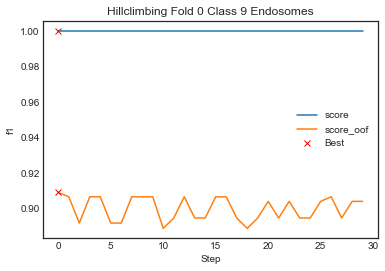

   step  midx  score  score_oof             mod  f1_0
0     0     8    1.0   0.909091  se_resnext_g30   1.0

      weight             mod  f1_0
midx                              
8          1  se_resnext_g30   1.0


hillclimbing f1 fold 0 class 10 Lysosomes

model 0 f1 0.5000 0.759 0.8235 0.847 air_g68
model 1 f1 1.0000 0.902 0.8364 0.829 air_h68
model 2 f1 0.6667 0.759 0.8679 0.847 airx_h67
model 3 f1 0.6667 0.759 0.8462 0.815 cbam_h67
model 4 f1 0.4000 0.946 0.8333 0.985 iv3_g11
model 5 f1 0.6667 0.902 0.7586 0.956 iv3_h11
model 6 f1 0.5000 0.902 0.8148 0.532 preresnet_g67
model 7 f1 0.4000 0.616 0.9020 0.847 preresnet_h67
model 8 f1 1.0000 0.616 0.8627 0.204 se_resnext_g30
model 9 f1 1.0000 0.759 0.9020 0.384 se_resnext_h30
0  train 1.0000  val 0.8364*   air_h68
1  train 1.0000  val 0.8364    air_h68
2  train 1.0000  val 0.8364    air_h68
3  train 1.0000  val 0.8276    air_g68
4  train 1.0000  val 0.8421*   air_h68
    try dropping 1 air_h68 1.0000 0.8421
    try dropping 1 air_h68 

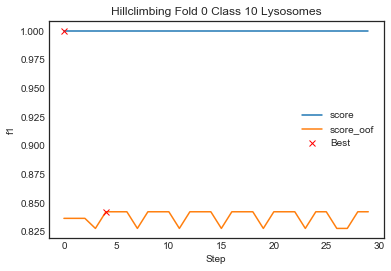

   step  midx  score  score_oof      mod  f1_0
0     0     1    1.0   0.836364  air_h68   1.0
1     1     1    1.0   0.836364  air_h68   1.0
2     2     1    1.0   0.836364  air_h68   1.0
3     3     0    1.0   0.827586  air_g68   0.5
4     4     1    1.0   0.842105  air_h68   1.0

      weight      mod  f1_0
midx                       
0          1  air_g68   0.5
1          4  air_h68   1.0


hillclimbing f1 fold 0 class 11 Intermediate filaments

model 0 f1 0.6979 0.800 0.8170 0.945 air_g68
model 1 f1 0.7154 0.748 0.8098 0.864 air_h68
model 2 f1 0.7026 0.849 0.7058 0.949 airx_h67
model 3 f1 0.7048 0.759 0.7936 0.875 cbam_h67
model 4 f1 0.6961 0.957 0.7969 0.989 iv3_g11
model 5 f1 0.6859 0.895 0.8077 0.869 iv3_h11
model 6 f1 0.6911 0.823 0.8086 0.936 preresnet_g67
model 7 f1 0.7106 0.757 0.8229 0.869 preresnet_h67
model 8 f1 0.7281 0.581 0.8301 0.663 se_resnext_g30
model 9 f1 0.7327 0.638 0.8257 0.620 se_resnext_h30
0  train 0.7327  val 0.8257*   se_resnext_h30
1  train 0.7465  val 0.

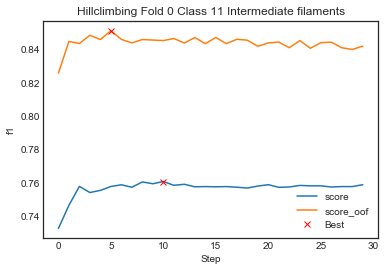

   step  midx     score  score_oof             mod      f1_0
0     0     9  0.732673   0.825706  se_resnext_h30  0.732673
1     1     8  0.746518   0.844708  se_resnext_g30  0.728078
2     2     2  0.757856   0.843496        airx_h67  0.702602
3     3     0  0.754159   0.848361         air_g68  0.697917
4     4     8  0.755474   0.845842  se_resnext_g30  0.728078
5     5     9  0.757798   0.851107  se_resnext_h30  0.732673

      weight             mod      f1_0
midx                                  
0          1         air_g68  0.697917
2          1        airx_h67  0.702602
8          2  se_resnext_g30  0.728078
9          2  se_resnext_h30  0.732673


hillclimbing f1 fold 0 class 12 Actin filaments

model 0 f1 0.6158 0.953 0.7620 0.949 air_g68
model 1 f1 0.6626 0.948 0.8094 0.933 air_h68
model 2 f1 0.5847 0.842 0.7660 0.808 airx_h67
model 3 f1 0.6407 0.860 0.7555 0.935 cbam_h67
model 4 f1 0.6133 0.988 0.7256 0.990 iv3_g11
model 5 f1 0.6103 0.956 0.7578 0.970 iv3_h11
model 6 f1 0.61

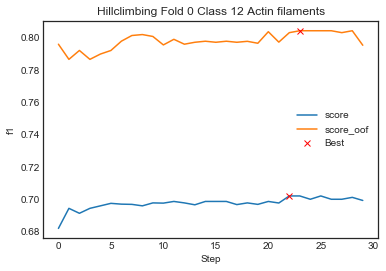

    step  midx     score  score_oof             mod      f1_0
0      0     9  0.681818   0.795796  se_resnext_h30  0.681818
1      1     6  0.694239   0.786421   preresnet_g67  0.619824
2      2     9  0.691176   0.791925  se_resnext_h30  0.681818
3      3     6  0.694239   0.786421   preresnet_g67  0.619824
4      4     8  0.695779   0.789700  se_resnext_g30  0.652661
5      5     9  0.697329   0.791908  se_resnext_h30  0.681818
6      6     5  0.696833   0.797671         iv3_h11  0.610329
7      7     4  0.696697   0.801178         iv3_g11  0.613333
8      8     9  0.695783   0.801762  se_resnext_h30  0.681818
9      9     4  0.697605   0.800587         iv3_g11  0.613333
10    10     4  0.697466   0.795356         iv3_g11  0.613333
11    11     4  0.698507   0.798825         iv3_g11  0.613333
12    12     9  0.697605   0.795796  se_resnext_h30  0.681818
13    13     6  0.696429   0.796992   preresnet_g67  0.619824
14    14     4  0.698507   0.797637         iv3_g11  0.613333
15    15

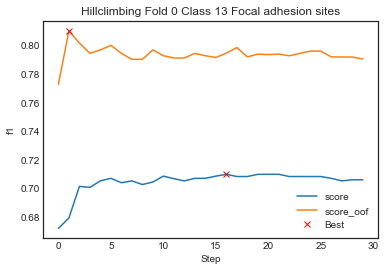

   step  midx     score  score_oof             mod      f1_0
0     0     1  0.672199   0.772816         air_h68  0.672199
1     1     8  0.679487   0.810176  se_resnext_g30  0.636364

      weight             mod      f1_0
midx                                  
1          1         air_h68  0.672199
8          1  se_resnext_g30  0.636364


hillclimbing f1 fold 0 class 14 Microtubules

model 0 f1 0.7851 0.900 0.8992 0.954 air_g68
model 1 f1 0.7932 0.902 0.9034 0.956 air_h68
model 2 f1 0.7624 0.842 0.8961 0.885 airx_h67
model 3 f1 0.7993 0.902 0.9070 0.954 cbam_h67
model 4 f1 0.7663 0.969 0.8934 0.983 iv3_g11
model 5 f1 0.7847 0.964 0.8996 0.963 iv3_h11
model 6 f1 0.7399 0.894 0.9006 0.868 preresnet_g67
model 7 f1 0.7904 0.935 0.8990 0.925 preresnet_h67
model 8 f1 0.7467 0.809 0.9042 0.683 se_resnext_g30
model 9 f1 0.7647 0.783 0.9074 0.889 se_resnext_h30
0  train 0.7993  val 0.9070*   cbam_h67
1  train 0.8140  val 0.9074*   air_h68
2  train 0.8172  val 0.9123*   se_resnext_h30
3  train 

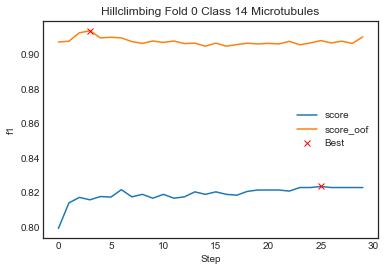

   step  midx     score  score_oof             mod      f1_0
0     0     3  0.799308   0.906962        cbam_h67  0.799308
1     1     1  0.814035   0.907432         air_h68  0.793162
2     2     9  0.817241   0.912281  se_resnext_h30  0.764706
3     3     7  0.815835   0.913468   preresnet_h67  0.790378

      weight             mod      f1_0
midx                                  
1          1         air_h68  0.793162
3          1        cbam_h67  0.799308
7          1   preresnet_h67  0.790378
9          1  se_resnext_h30  0.764706


hillclimbing f1 fold 0 class 15 Microtubule ends

model 0 f1 0.5000 0.232 0.8571 0.616 air_g68
model 1 f1 0.5185 0.902 0.6667 0.616 air_h68
model 2 f1 0.4667 0.384 0.8571 0.759 airx_h67
model 3 f1 0.5185 0.759 0.8571 0.731 cbam_h67
model 4 f1 0.4348 0.935 0.7500 0.759 iv3_g11
model 5 f1 0.3871 0.902 0.7273 0.429 iv3_h11
model 6 f1 0.4167 0.759 0.8571 0.759 preresnet_g67
model 7 f1 0.5185 0.616 0.8571 0.759 preresnet_h67
model 8 f1 0.3704 0.241 0.6667 0.9

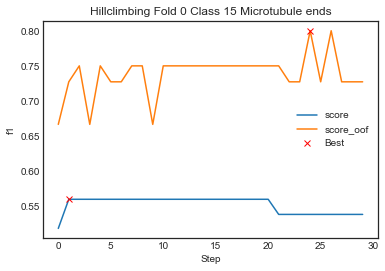

    step  midx     score  score_oof       mod      f1_0
0      0     1  0.518519   0.666667   air_h68  0.518519
1      1     3  0.560000   0.727273  cbam_h67  0.518519
2      2     1  0.560000   0.750000   air_h68  0.518519
3      3     1  0.560000   0.666667   air_h68  0.518519
4      4     2  0.560000   0.750000  airx_h67  0.466667
5      5     3  0.560000   0.727273  cbam_h67  0.518519
6      6     1  0.560000   0.727273   air_h68  0.518519
7      7     1  0.560000   0.750000   air_h68  0.518519
8      8     1  0.560000   0.750000   air_h68  0.518519
9      9     1  0.560000   0.666667   air_h68  0.518519
10    10     0  0.560000   0.750000   air_g68  0.500000
11    11     1  0.560000   0.750000   air_h68  0.518519
12    12     1  0.560000   0.750000   air_h68  0.518519
13    13     2  0.560000   0.750000  airx_h67  0.466667
14    14     2  0.560000   0.750000  airx_h67  0.466667
15    15     3  0.560000   0.750000  cbam_h67  0.518519
16    16     1  0.560000   0.750000   air_h68  0

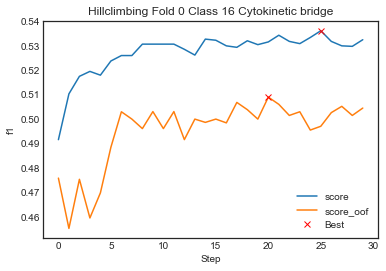

    step  midx     score  score_oof             mod      f1_0
0      0     6  0.491603   0.475904   preresnet_g67  0.491603
1      1     0  0.510301   0.455357         air_g68  0.484490
2      2     6  0.517460   0.475410   preresnet_g67  0.491603
3      3     6  0.519481   0.459627   preresnet_g67  0.491603
4      4     0  0.517941   0.469880         air_g68  0.484490
5      5     4  0.523732   0.488506         iv3_g11  0.355301
6      6     8  0.525952   0.502994  se_resnext_g30  0.464223
7      7     0  0.525952   0.500000         air_g68  0.484490
8      8     0  0.530612   0.496124         air_g68  0.484490
9      9     0  0.530612   0.503067         air_g68  0.484490
10    10     6  0.530612   0.496124   preresnet_g67  0.491603
11    11     0  0.530612   0.503067         air_g68  0.484490
12    12     6  0.528497   0.491620   preresnet_g67  0.491603
13    13     8  0.526138   0.500000  se_resnext_g30  0.464223
14    14     0  0.532663   0.498660         air_g68  0.484490
15    15

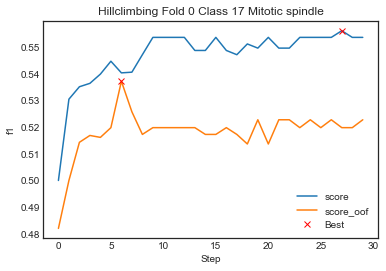

   step  midx     score  score_oof             mod      f1_0
0     0     8  0.500000   0.482051  se_resnext_g30  0.500000
1     1     4  0.530435   0.500000         iv3_g11  0.428094
2     2     4  0.535088   0.514286         iv3_g11  0.428094
3     3     4  0.536364   0.516854         iv3_g11  0.428094
4     4     4  0.539823   0.516129         iv3_g11  0.428094
5     5     4  0.544643   0.519774         iv3_g11  0.428094
6     6     5  0.540284   0.537143         iv3_h11  0.439024

      weight             mod      f1_0
midx                                  
4          5         iv3_g11  0.428094
5          1         iv3_h11  0.439024
8          1  se_resnext_g30  0.500000


hillclimbing f1 fold 0 class 18 Microtubule organizing center

model 0 f1 0.5080 0.847 0.6036 0.902 air_g68
model 1 f1 0.4626 0.834 0.5170 0.910 air_h68
model 2 f1 0.4274 0.640 0.4922 0.906 airx_h67
model 3 f1 0.4206 0.741 0.4975 0.876 cbam_h67
model 4 f1 0.4384 0.934 0.5150 0.944 iv3_g11
model 5 f1 0.3798 0.780 

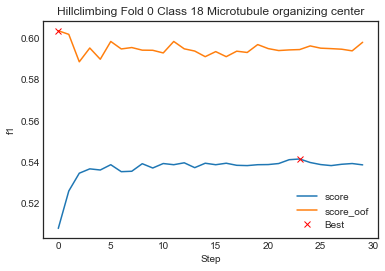

   step  midx     score  score_oof      mod      f1_0
0     0     0  0.507993   0.603645  air_g68  0.507993

      weight      mod      f1_0
midx                           
0          1  air_g68  0.507993


hillclimbing f1 fold 0 class 19 Centrosome

model 0 f1 0.5942 0.914 0.7110 0.963 air_g68
model 1 f1 0.5612 0.837 0.6759 0.854 air_h68
model 2 f1 0.5730 0.618 0.6682 0.704 airx_h67
model 3 f1 0.5614 0.637 0.6621 0.765 cbam_h67
model 4 f1 0.5210 0.925 0.6465 0.939 iv3_g11
model 5 f1 0.4935 0.829 0.6080 0.854 iv3_h11
model 6 f1 0.5721 0.874 0.6835 0.915 preresnet_g67
model 7 f1 0.5470 0.738 0.6727 0.817 preresnet_h67
model 8 f1 0.5293 0.720 0.6447 0.801 se_resnext_g30
model 9 f1 0.5046 0.625 0.6515 0.747 se_resnext_h30
0  train 0.5942  val 0.7110*   air_g68
1  train 0.6026  val 0.6899    cbam_h67
2  train 0.6061  val 0.6922    air_g68
3  train 0.6082  val 0.7023    air_h68
4  train 0.6095  val 0.6994    preresnet_g67
    try dropping 0 air_g68 0.6043 0.7011
    try dropping 3 cbam_h67 

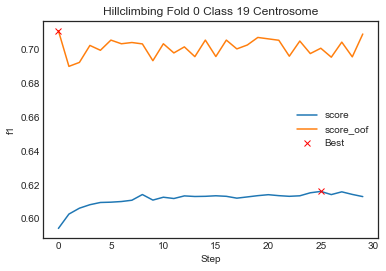

   step  midx     score  score_oof      mod      f1_0
0     0     0  0.594177   0.710952  air_g68  0.594177

      weight      mod      f1_0
midx                           
0          1  air_g68  0.594177


hillclimbing f1 fold 0 class 20 Lipid droplets

model 0 f1 0.5273 0.822 0.6789 0.899 air_g68
model 1 f1 0.4000 0.815 0.6371 0.928 air_h68
model 2 f1 0.4706 0.797 0.6141 0.625 airx_h67
model 3 f1 0.3118 0.762 0.6759 0.899 cbam_h67
model 4 f1 0.3256 0.935 0.6260 0.972 iv3_g11
model 5 f1 0.2346 0.608 0.5952 0.832 iv3_h11
model 6 f1 0.3229 0.616 0.6699 0.902 preresnet_g67
model 7 f1 0.2727 0.756 0.7212 0.902 preresnet_h67
model 8 f1 0.4400 0.703 0.6769 0.831 se_resnext_g30
model 9 f1 0.4531 0.632 0.7097 0.616 se_resnext_h30
0  train 0.5273  val 0.6789*   air_g68
1  train 0.5688  val 0.7308*   se_resnext_h30
2  train 0.5760  val 0.7489*   airx_h67
3  train 0.5714  val 0.7232    air_g68
4  train 0.5688  val 0.7358    se_resnext_h30
    try dropping 0 air_g68 0.5155 0.7404
    try dropping

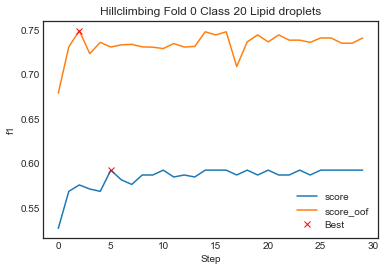

   step  midx     score  score_oof             mod      f1_0
0     0     0  0.527273   0.678899         air_g68  0.527273
1     1     9  0.568807   0.730769  se_resnext_h30  0.453125
2     2     2  0.576000   0.748858        airx_h67  0.470588

      weight             mod      f1_0
midx                                  
0          1         air_g68  0.527273
2          1        airx_h67  0.470588
9          1  se_resnext_h30  0.453125


hillclimbing f1 fold 0 class 21 Plasma membrane

model 0 f1 0.6420 0.739 0.7239 0.849 air_g68
model 1 f1 0.6676 0.701 0.7272 0.759 air_h68
model 2 f1 0.6391 0.761 0.6986 0.810 airx_h67
model 3 f1 0.6289 0.741 0.7112 0.710 cbam_h67
model 4 f1 0.6317 0.930 0.7168 0.942 iv3_g11
model 5 f1 0.6457 0.827 0.7105 0.833 iv3_h11
model 6 f1 0.6480 0.731 0.7208 0.709 preresnet_g67
model 7 f1 0.6544 0.778 0.7342 0.786 preresnet_h67
model 8 f1 0.6460 0.664 0.7120 0.725 se_resnext_g30
model 9 f1 0.6489 0.759 0.7348 0.733 se_resnext_h30
0  train 0.6676  val 0.7272*   

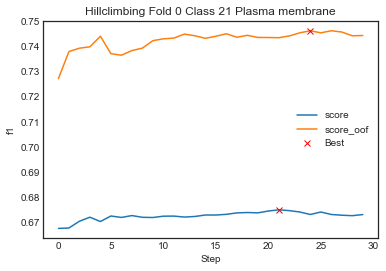

    step  midx     score  score_oof             mod      f1_0
0      0     1  0.667612   0.727154         air_h68  0.667612
1      1     8  0.667780   0.737877  se_resnext_g30  0.646047
2      2     2  0.670459   0.739218        airx_h67  0.639137
3      3     1  0.672068   0.739779         air_h68  0.667612
4      4     6  0.670346   0.743977   preresnet_g67  0.648035
5      5     8  0.672544   0.737044  se_resnext_g30  0.646047
6      6     1  0.671977   0.736432         air_h68  0.667612
7      7     1  0.672716   0.738276         air_h68  0.667612
8      8     9  0.672030   0.739249  se_resnext_h30  0.648885
9      9     8  0.671947   0.742213  se_resnext_g30  0.646047
10    10     2  0.672472   0.742936        airx_h67  0.639137
11    11     8  0.672510   0.743239  se_resnext_g30  0.646047
12    12     9  0.672124   0.744818  se_resnext_h30  0.648885
13    13     1  0.672355   0.744170         air_h68  0.667612
14    14     1  0.672941   0.743151         air_h68  0.667612
15    15

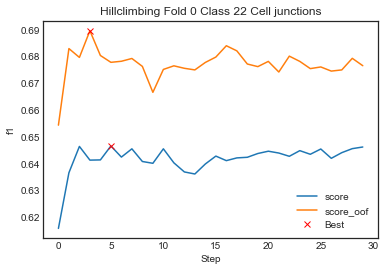

   step  midx     score  score_oof             mod      f1_0
0     0     0  0.615854   0.654402         air_g68  0.615854
1     1     9  0.636631   0.682997  se_resnext_h30  0.610097
2     2     4  0.646465   0.679699         iv3_g11  0.580205
3     3     8  0.641350   0.689655  se_resnext_g30  0.612472

      weight             mod      f1_0
midx                                  
0          1         air_g68  0.615854
4          1         iv3_g11  0.580205
8          1  se_resnext_g30  0.612472
9          1  se_resnext_h30  0.610097


hillclimbing f1 fold 0 class 23 Mitochondria

model 0 f1 0.7335 0.814 0.8795 0.803 air_g68
model 1 f1 0.7346 0.634 0.8719 0.798 air_h68
model 2 f1 0.7249 0.759 0.8457 0.502 airx_h67
model 3 f1 0.7380 0.735 0.8650 0.765 cbam_h67
model 4 f1 0.7235 0.954 0.8726 0.951 iv3_g11
model 5 f1 0.7283 0.816 0.8718 0.849 iv3_h11
model 6 f1 0.7211 0.892 0.8718 0.797 preresnet_g67
model 7 f1 0.7306 0.698 0.8729 0.777 preresnet_h67
model 8 f1 0.7342 0.602 0.8773 0.817 s

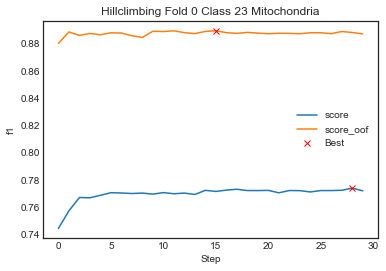

    step  midx     score  score_oof             mod      f1_0
0      0     9  0.744243   0.880116  se_resnext_h30  0.744243
1      1     0  0.757161   0.888437         air_g68  0.733503
2      2     3  0.766930   0.885891        cbam_h67  0.738026
3      3     9  0.766722   0.887364  se_resnext_h30  0.744243
4      4     3  0.768548   0.886370        cbam_h67  0.738026
5      5     8  0.770451   0.887799  se_resnext_g30  0.734208
6      6     5  0.770248   0.887673         iv3_h11  0.728338
7      7     3  0.769864   0.885666        cbam_h67  0.738026
8      8     2  0.770181   0.884460        airx_h67  0.724880
9      9     8  0.769421   0.888953  se_resnext_g30  0.734208
10    10     3  0.770526   0.888759        cbam_h67  0.738026
11    11     9  0.769682   0.889276  se_resnext_h30  0.744243
12    12     3  0.770192   0.887938        cbam_h67  0.738026
13    13     0  0.769167   0.887240         air_g68  0.733503
14    14     5  0.772178   0.888825         iv3_h11  0.728338
15    15

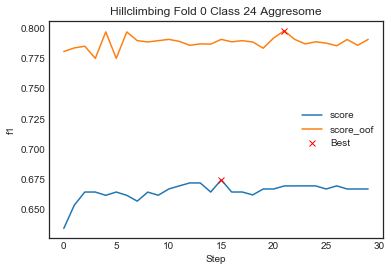

    step  midx     score  score_oof             mod      f1_0
0      0     6  0.633962   0.780749   preresnet_g67  0.633962
1      1     0  0.653226   0.783715         air_g68  0.612613
2      2     3  0.664151   0.785146        cbam_h67  0.601695
3      3     4  0.664151   0.775068         iv3_g11  0.572438
4      4     8  0.661417   0.796992  se_resnext_g30  0.585034
5      5     3  0.664151   0.775068        cbam_h67  0.601695
6      6     8  0.661417   0.796992  se_resnext_g30  0.585034
7      7     3  0.656604   0.789744        cbam_h67  0.601695
8      8     0  0.664093   0.788660         air_g68  0.612613
9      9     6  0.661479   0.789744   preresnet_g67  0.633962
10    10     9  0.666667   0.790816  se_resnext_h30  0.524715
11    11     0  0.669231   0.789189         air_g68  0.612613
12    12     3  0.671698   0.785894        cbam_h67  0.601695
13    13     0  0.671698   0.787062         air_g68  0.612613
14    14     6  0.664151   0.786885   preresnet_g67  0.633962
15    15

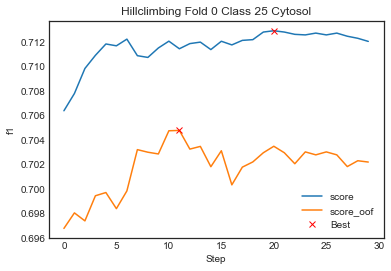

    step  midx     score  score_oof             mod      f1_0
0      0     1  0.706371   0.696774         air_h68  0.706371
1      1     3  0.707778   0.698041        cbam_h67  0.700603
2      2     0  0.709821   0.697389         air_g68  0.699836
3      3     4  0.710893   0.699438         iv3_g11  0.694333
4      4     1  0.711820   0.699701         air_h68  0.706371
5      5     3  0.711670   0.698386        cbam_h67  0.700603
6      6     2  0.712215   0.699835        airx_h67  0.692314
7      7     8  0.710865   0.703201  se_resnext_g30  0.689957
8      8     3  0.710723   0.702990        cbam_h67  0.700603
9      9     1  0.711494   0.702848         air_h68  0.706371
10    10     1  0.712049   0.704740         air_h68  0.706371
11    11     4  0.711430   0.704768         iv3_g11  0.694333

      weight             mod      f1_0
midx                                  
0          1         air_g68  0.699836
1          4         air_h68  0.706371
2          1        airx_h67  0.69231

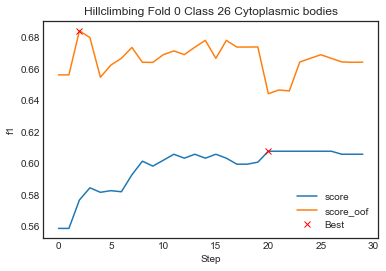

   step  midx     score  score_oof      mod      f1_0
0     0     1  0.558511   0.656151  air_h68  0.558511
1     1     1  0.558511   0.656151  air_h68  0.558511
2     2     0  0.576577   0.684211  air_g68  0.501362

      weight      mod      f1_0
midx                           
0          1  air_g68  0.501362
1          2  air_h68  0.558511


hillclimbing f1 fold 0 class 27 Rods & rings

model 0 f1 0.4000 0.503 0.6000 0.847 air_g68
model 1 f1 0.2857 0.759 0.8571 0.943 air_h68
model 2 f1 0.2857 0.813 0.7500 0.847 airx_h67
model 3 f1 0.3846 0.868 0.7500 0.847 cbam_h67
model 4 f1 0.1739 0.792 0.3529 0.983 iv3_g11
model 5 f1 0.1471 0.454 0.6667 0.975 iv3_h11
model 6 f1 0.3333 0.421 0.4286 0.616 preresnet_g67
model 7 f1 0.6250 0.752 0.8571 0.935 preresnet_h67
model 8 f1 0.4762 0.178 0.6667 0.616 se_resnext_g30
model 9 f1 0.6250 0.616 0.5000 0.616 se_resnext_h30
0  train 0.6250  val 0.8571*   preresnet_h67
1  train 0.7143  val 0.7500    se_resnext_g30
2  train 0.7143  val 0.8571    preresn

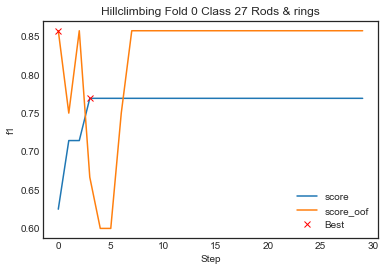

   step  midx  score  score_oof            mod   f1_0
0     0     7  0.625   0.857143  preresnet_h67  0.625

      weight            mod   f1_0
midx                              
7          1  preresnet_h67  0.625

overall mean f1 0.7303969431823896  mean cut 0.7775222257276084   mean steps 16.071428571428573
mean f1 0.7687410230780973  mean cut 0.7686534267627868   mean steps 9.142857142857142


<Figure size 432x288 with 0 Axes>

In [80]:
# oof = small

# hillclimbing
# vp = oof.copy()
# offset = 5
# nm = vp.shape[1] - offset
nr = vp.shape[0]
y = np.array([y for y in vp.y])
# y = np.array(list(vp['masks'].values))

yt = y[folds != fold]
yf = y[folds == fold]

nstep = 30
back_check = 5
back_num = 2

step0fix = -1
# step0fix = 5
step1fix = -1

intercept = 0
metric = 'f1'
# metric = 'iou'

# threshold = 0.
# threshold = 0.36
threshold = 0.49
# threshold = 0.5
# print('using ' + metric + ' threshold',threshold)
# print('optimizing ' + metric + ' by hillclimbing on fold ' + str(fold))

# metric = "mcc"
# metric = "corr"
# metric = "rmse"
# metric = "mse"
# metric = "mae"
# metric = "winsorized_mae"
# metric = "auc"

cut_mets = ['mcc','f1']

num_classes = 28
th = np.zeros(num_classes)
threshold_best = threshold


rez_all = []
tb_all = []

bestEnsemble_all = []
bestStep_all = []
bestScore_all = []
bestCut_all = []

bestEnsemble_oof_all = []
bestStep_oof_all = []
bestScore_oof_all = []
bestCut_oof_all = []

for c in range(num_classes):
    
    print()
    print()
    print('hillclimbing',metric,'fold',fold,'class',c,LABEL_MAP[c])
    print()

    rez = pd.DataFrame({'step':np.zeros(nstep).astype(int),'midx':np.zeros(nstep).astype(int),
                        'score':np.zeros(nstep),'score_oof':np.zeros(nstep)})
    currEnsemble = 0 * np.array(list(vp.iloc[:,offset].values))
    currMods = []
    size = 0

    # maximizing
    bestScore = -9999999
    bestScore_oof = -9999999
    single = pd.DataFrame({'mod':np.repeat("",nm)})
    start = 0
    for step in range(start,nstep):
        single[metric+'_'+str(step)] = np.nan

    single_oof = single.copy()

    for step in range(start,nstep):
        
        currIndex = 0
        currScore = -9999999
        currScore_oof = -9999999

        # forward selection
        for i in range(nm):

            mn = vp.columns[i+offset]

            tv = np.array(list(vp.iloc[:,offset+i].values))

            # mean-center
    #         tv = tv - np.mean(tv)

            # adjust by model-specific threshold
    #         tv = tv - mthresh[mn]

            # adjust by model-class-specific thresholds
    #         for j in range(tv.shape[1]):
    #             tv[:,j] = tv[:,j] - cthresh[mn][j]

            if np.sum(np.isnan(tv)) > 0: continue

            if size==0:
                tryEnsemble = tv
            else:
                # running mean
                tryEnsemble = (size * currEnsemble + tv)/(size+1)
                # full matrix
                # choose median or mean here
                # tryEnsemble = rowMedians(cbind(currEnsemble,tv))
                # tryEnsemble = rowMeans(cbind(currEnsemble,tv))
                # quantiles are a lot slower
                # tryEnsemble = rowQuantiles(cbind(currEnsemble,tv),probs=0.6)

            if metric=="f1":
    #             # estimate new class-specific thresholds by least squares, very slow
    #             th = fit_val(tryEnsemble,y)
    #             th[th<0.1] = 0.1
    #             tryScore = f1_score(y, np.int32(tryEnsemble > th),
    #                                 average='macro')

                # estimate new class-specific thresholds by line search, slow
                et = tryEnsemble[folds != fold]
                cutt = fit_val1(et[:,c],yt[:,c])
                tryScore = f1_score(yt[:,c], np.int32(et[:,c] > cutt))

                ef = tryEnsemble[folds == fold]
                cutf = fit_val1(ef[:,c],yf[:,c])
                tryScore_oof = f1_score(yf[:,c], np.int32(ef[:,c] > cutf))

    #             # estimate new class-specific thresholds to match proportions, medium
    #             for j in range(num_classes):
    #                 th[j] = fit_val2(tryEnsemble[:,j],y[:,j])
    #             tryScore = f1_score(y, np.int32(tryEnsemble > th),
    #                                 average='macro')

    #             # fixed threshold, fast
    #             tryScore = f1_score(y, np.int32(tryEnsemble > threshold),
    #                                 average='macro')

#                 if step > 0: print('    try',i,mn,"%6.4f" % tryScore,"%6.4f" % tryScore_oof)
            elif metric=="iou":
                tryScore = iou_metric_batch(y, np.int32(tryEnsemble > threshold),
                                            pred_eps=pred_eps)
                if step > 0: print('    try',i,mn,"%6.4f" % tryScore)
            elif metric=="mse":
                tryScore = -mse(y,tryEnsemble)
            elif metric=="mae": 
                tryScore = -mae(y,tryEnsemble)
            elif metric=="winsorized_mae": 
                tryScore = -winsorized_mae(y,tryEnsemble+intercept)
            elif metric=="rmse":
                tryScore = -rmse(y,tryEnsemble)
            elif metric=="corr":
                tryScore = cor(y,tryEnsemble)
            elif metric=="mcc":
                opt = eval_mcc3(y,tryEnsemble,cut=T)
                tryScore = opt[1]
                cut = opt[2]
                # opt = optimize(mcc,c(0.1,0.3),tryEnsemble,vp$y,maximum=T)
                # tryScore = opt$objective
            elif metric=="logloss":
                # tryScore = -logLoss(vp$y,tryEnsemble,)
                tryScore = -eval_logloss2(tryEnsemble,y)
            elif metric=="auc":
                tryScore = auc2(y,tryEnsemble)
            elif metric=="auprc":
                tryScore = auprc(tryEnsemble, y)
                # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
                # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.davis.goadrich
            elif metric=="aurocpr":
                auroc = auc(y,tryEnsemble)
                # auprc = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
                tryScore = (auroc + auprc)/2
            elif metric=="sqwk":
                tryScore = sqwk(y,tryEnsemble,1,8)

            ok = 1
            if (step==0) and (step0fix>-1) and (i!=step0fix): ok = 0 
            if (step==1) and (step1fix>-1) and (i!=step1fix): ok = 0 

            if (tryScore > currScore) and (ok==1):
                currIndex = i
                currScore = tryScore
                currScore_oof = tryScore_oof
                if (step==0):
                    saveEnsemble = tv.copy()
                else:
                    # running mean
                    saveEnsemble = tryEnsemble.copy()
                    # save whole matrix
                    # saveEnsemble = np.concatenate((currEnsemble,tv),axis=1)
                if metric in cut_mets: 
                    currCut = cutt
                    currCut_oof = cutf

            # if (step==0) or ((step==1) and (step0fix>-1)) or ((step==2) and (step1fix>-1)):
            if (step==0):
                if metric in cut_mets:
                    print("model",i,metric, "%6.4f %5.3f %6.4f %5.3f" % \
                          (tryScore,cutt,tryScore_oof,cutf), vp.columns[i+offset])
                else:
                    print("model",i,metric,"for",vp.columns[i+offset],"= %6.4f" % tryScore,
                         " oof = %6.4f" % tryScore_oof)

            if step==0:
                single.loc[i,'mod'] = vp.columns[i+offset]  
                single_oof.loc[i,'mod'] = vp.columns[i+offset]  
            single.iloc[i,step+1] = tryScore
            single_oof.iloc[i,step+1] = tryScore_oof
            
        currMods.append(currIndex)
        size += 1
        # print('   ',currMods,size)
        assert size == len(currMods)

        # backwards elimination
        if (step > 0) and (step % back_check) == 0:
            
            for b in range(back_num):
                
                dropped1 = False
                for ixi, i in enumerate(currMods):

                    mn = vp.columns[i+offset]

                    tv = np.array(list(vp.iloc[:,offset+i].values))

                    # mean-center
            #         tv = tv - np.mean(tv)

                    # adjust by model-specific threshold
            #         tv = tv - mthresh[mn]

                    # adjust by model-class-specific thresholds
            #         for j in range(tv.shape[1]):
            #             tv[:,j] = tv[:,j] - cthresh[mn][j]

                    if np.sum(np.isnan(tv)) > 0: continue

                    if size==0:
                        tryEnsemble = tv
                    else:
                        # running mean
                        tryEnsemble = (size * currEnsemble - tv)/(size-1)
                        # full matrix
                        # choose median or mean here
                        # tryEnsemble = rowMedians(cbind(currEnsemble,tv))
                        # tryEnsemble = rowMeans(cbind(currEnsemble,tv))
                        # quantiles are a lot slower
                        # tryEnsemble = rowQuantiles(cbind(currEnsemble,tv),probs=0.6)

                    if metric=="f1":
            #             # estimate new class-specific thresholds by least squares, very slow
            #             th = fit_val(tryEnsemble,y)
            #             th[th<0.1] = 0.1
            #             tryScore = f1_score(y, np.int32(tryEnsemble > th),
            #                                 average='macro')

                        # estimate new class-specific thresholds by line search, slow
                        et = tryEnsemble[folds != fold]
                        cutt = fit_val1(et[:,c],yt[:,c])
                        tryScore = f1_score(yt[:,c], np.int32(et[:,c] > cutt))

                        ef = tryEnsemble[folds == fold]
                        cutf = fit_val1(ef[:,c],yf[:,c])
                        tryScore_oof = f1_score(yf[:,c], np.int32(ef[:,c] > cutf))

            #             # estimate new class-specific thresholds to match proportions, medium
            #             for j in range(num_classes):
            #                 th[j] = fit_val2(tryEnsemble[:,j],y[:,j])
            #             tryScore = f1_score(y, np.int32(tryEnsemble > th),
            #                                 average='macro')

            #             # fixed threshold, fast
            #             tryScore = f1_score(y, np.int32(tryEnsemble > threshold),
            #                                 average='macro')

                        if step > 0: print('    try dropping',i,mn,"%6.4f" % tryScore,"%6.4f" % tryScore_oof)
                    elif metric=="iou":
                        tryScore = iou_metric_batch(y, np.int32(tryEnsemble > threshold),
                                                    pred_eps=pred_eps)
                        if step > 0: print('    try',i,mn,"%6.4f" % tryScore)
                    elif metric=="mse":
                        tryScore = -mse(y,tryEnsemble)
                    elif metric=="mae": 
                        tryScore = -mae(y,tryEnsemble)
                    elif metric=="winsorized_mae": 
                        tryScore = -winsorized_mae(y,tryEnsemble+intercept)
                    elif metric=="rmse":
                        tryScore = -rmse(y,tryEnsemble)
                    elif metric=="corr":
                        tryScore = cor(y,tryEnsemble)
                    elif metric=="mcc":
                        opt = eval_mcc3(y,tryEnsemble,cut=T)
                        tryScore = opt[1]
                        cut = opt[2]
                        # opt = optimize(mcc,c(0.1,0.3),tryEnsemble,vp$y,maximum=T)
                        # tryScore = opt$objective
                    elif metric=="logloss":
                        # tryScore = -logLoss(vp$y,tryEnsemble,)
                        tryScore = -eval_logloss2(tryEnsemble,y)
                    elif metric=="auc":
                        tryScore = auc2(y,tryEnsemble)
                    elif metric=="auprc":
                        tryScore = auprc(tryEnsemble, y)
                        # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
                        # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.davis.goadrich
                    elif metric=="aurocpr":
                        auroc = auc(y,tryEnsemble)
                        # auprc = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
                        tryScore = (auroc + auprc)/2
                    elif metric=="sqwk":
                        tryScore = sqwk(y,tryEnsemble,1,8)

                    ok = 1
                    if (step==0) and (step0fix>-1) and (i!=step0fix): ok = 0 
                    if (step==1) and (step1fix>-1) and (i!=step1fix): ok = 0 

                    if (tryScore > currScore) and (ok==1):
                        currIxi = ixi
                        currScore = tryScore
                        currScore_oof = tryScore_oof
                        if (step==0):
                            saveEnsemble = tv.copy()
                        else:
                            # running mean
                            saveEnsemble = tryEnsemble.copy()
                            # save whole matrix
                            # saveEnsemble = np.concatenate((currEnsemble,tv),axis=1)
                        if metric in cut_mets: 
                            currCut = cutt
                            currCut_oof = cutf
                        dropped1 = True

                # adjust model list or break out of loop if nothing dropped
                if dropped1: 
                    size -= 1
                    di = currMods[currIxi]
                    print('    dropping',di,vp.columns[di+offset])
                    del currMods[currIxi]
                    assert size == len(currMods)
                else:
                    break


        currEnsemble = saveEnsemble.copy()
        if currScore > bestScore:
            bestScore = currScore
            bestStep = step
            bestEnsemble = currEnsemble.copy()
            if metric in cut_mets: 
                bestCut = currCut
        if currScore_oof > bestScore_oof:
            bestScore_oof = currScore_oof
            bestStep_oof = step
            bestEnsemble_oof = currEnsemble.copy()
            if metric in cut_mets: 
                bestCut_oof = currCut_oof
            star = '*'
        else:
            star = ' '

        if metric=="mcc":
            print("step =",step,"  index =",currIndex,"  name =", vp.columns[currIndex+offset],"  ",
                metric,"= %6.4f" % currScore,"  cut =",currCut)
        else:
            print(step," train %6.4f" % currScore,
                  " val %6.4f%s" % (currScore_oof,star),
                  " ",vp.columns[currIndex+offset])

        rez.iloc[step,0] = step
        rez.iloc[step,1] = currIndex
        rez.iloc[step,2] = currScore
        rez.iloc[step,3] = currScore_oof

    if (metric=="mcc"):
        print("best step =",bestStep,"  best",metric,"=",bestScore,"  best cut =",bestCut)
    else:
        print("best step =",bestStep,"  best",metric,"=",bestScore)
        print("best step oof =",bestStep_oof,"  best",metric,"=",bestScore_oof)

    rez0 = rez.copy()

    # tb = table(rez$index[1:bestStep])
    # names(tb) = names(vp)[(offset+1):ncol(vp)][as.integer(names(table(rez$index[1:bestStep])))]

    # if (intercept!=0) {
    #   tb["Intercept"] = intercept
    # }

    # print(tb[order(-tb)])
    # print(single[order(-single[,2]),][1:min(nrow(single),40),])

    # plot hillclimbing
    print('')
    plt.plot(rez0.step, rez0.score)
    plt.plot(rez0.step, rez0.score_oof)
    plt.plot(bestStep, bestScore, "xr", label="Best")
    plt.plot(bestStep_oof, bestScore_oof, "xr")
    plt.xlabel("Step")
    plt.ylabel(metric)
#     plt.title("Hillclimbing ({}, {})".format(bestStep, bestScore))
    plt.title("Hillclimbing Fold %d Class %d %s" % (fold,c,LABEL_MAP[c]))
    plt.legend()
    plt.show()
    plt.gcf().clear()
    
    # display the weights
    rez = rez.iloc[:(bestStep_oof+1)]
    # print(rez)

    single0 = single.iloc[:,:2]

    rez['midx'] = rez['midx'].astype(int)
    rez = rez.join(single0,how='left',on='midx')
    print(rez)
    print('')

    rez['weight'] = 1
    tb = rez.loc[:,['midx','weight']].groupby('midx').count()
    # print(tb)
    # print(single)

    tb = tb.join(single0,how='left')
    print(tb)
    
    rez_all.append(rez)
    tb_all.append(tb)
    bestEnsemble_all.append(bestEnsemble)
    bestStep_all.append(bestStep)
    bestScore_all.append(bestScore)
    bestCut_all.append(bestCut)
    bestEnsemble_oof_all.append(bestEnsemble_oof)
    bestStep_oof_all.append(bestStep_oof)
    bestScore_oof_all.append(bestScore_oof)
    bestCut_oof_all.append(bestCut_oof)

print()
print('overall mean f1',np.mean(bestScore_all),' mean cut',np.mean(bestCut_all),
      '  mean steps',np.mean(bestStep_all))  

print('mean f1',np.mean(bestScore_oof_all),' mean cut',np.mean(bestCut_oof_all),
      '  mean steps',np.mean(bestStep_oof_all))

In [81]:
print('mean f1',np.mean(bestScore_oof_all),' mean cut',np.mean(bestCut_oof_all),
      '  mean steps',np.mean(bestStep_oof_all))

mean f1 0.7687410230780973  mean cut 0.7686534267627868   mean steps 9.142857142857142


In [82]:
# tb_all

In [83]:
# save weights and thresholds
print('')
os.makedirs('weights',exist_ok=True)
fname = 'weights/'+mname+'_'+str(fold)+'.pkl'
pickle.dump(tb_all,open(fname,'wb'))
print(fname)

print('')
os.makedirs('thresholds',exist_ok=True)
fname = 'thresholds/'+mname+'_'+str(fold)+'.pkl'
pickle.dump(bestCut_all,open(fname,'wb'))
print(fname)


weights/hill_g100_0.pkl

thresholds/hill_g100_0.pkl


In [84]:
for i in range(28):
    tb_all[i]['class'] = i
tba = pd.concat(tb_all).reset_index()
print(tba.shape)

(112, 5)


In [85]:
tba.head()

midx  weight       mod      f1_0  class
0     0       4   air_g68  0.865808      0
1     1       2   air_h68  0.863851      0
2     3       6  cbam_h67  0.861839      0
3     4       4   iv3_g11  0.855522      0
4     5       1   iv3_h11  0.851569      0

In [86]:
# show most popular models
tbag = tba.groupby('mod')
ws = pd.DataFrame(tbag['weight'].sum())
ws.columns = ['ws']
ws.sort_values(['ws'],ascending=False,inplace=True)
print(ws)

                ws
mod               
air_g68         48
air_h68         47
preresnet_g67   36
cbam_h67        35
se_resnext_h30  30
se_resnext_g30  28
iv3_g11         26
airx_h67        16
preresnet_h67   11
iv3_h11          7


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


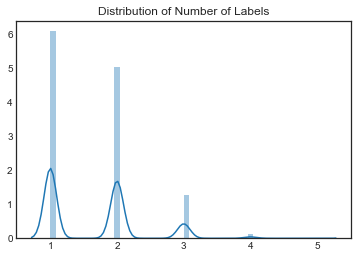

<Figure size 432x288 with 0 Axes>

In [87]:
ysum = y.sum(axis=1)
sns.distplot(np.array(ysum))
plt.title("Distribution of Number of Labels")
plt.show()
plt.gcf().clear()

In [88]:
bestens = np.zeros_like(y)
bestens_oof = np.zeros_like(y)
for j in range(num_classes):
    bestens[:,j] = bestEnsemble_all[j][:,j]
    bestens_oof[:,j] = bestEnsemble_oof_all[j][:,j]
    
bet = bestens[folds!=fold]
bev = bestens_oof[folds==fold]
yt = y[folds!=fold]
yv = y[folds==fold]
print(bet.shape,yt.shape,bev.shape,yv.shape)

(19527, 28) (19527, 28) (11545, 28) (11545, 28)


In [89]:
# breakdown by number of labels
st = np.zeros(num_classes)
sv = np.zeros(num_classes)
st1 = np.zeros(num_classes)
sv1 = np.zeros(num_classes)
st2 = np.zeros(num_classes)
sv2 = np.zeros(num_classes)
st3 = np.zeros(num_classes)
sv3 = np.zeros(num_classes)

yts1 = yt.sum(axis=1)==1
yvs1 = yv.sum(axis=1)==1

yts2 = yt.sum(axis=1)==2
yvs2 = yv.sum(axis=1)==2

yts3 = yt.sum(axis=1)>=3
yvs3 = yv.sum(axis=1)>=3

for j in range(num_classes):
    cut = fit_val1(bet[:,j],yt[:,j])
    st[j] = f1_score(yt[:,j],np.int32(bet[:,j] > cut))
    cut = fit_val1(bev[:,j],yv[:,j])
    sv[j] = f1_score(yv[:,j],np.int32(bev[:,j] > cut))
    
    s = yts1
    cut = fit_val1(bet[s,j],yt[s,j])
    st1[j] = f1_score(yt[s,j],np.int32(bet[s,j] > cut))
    s = yvs1
    cut = fit_val1(bev[s,j],yv[s,j])
    sv1[j] = f1_score(yv[s,j],np.int32(bev[s,j] > cut))
    
    s = yts2
    cut = fit_val1(bet[s,j],yt[s,j])
    st2[j] = f1_score(yt[s,j],np.int32(bet[s,j] > cut))
    s = yvs2
    cut = fit_val1(bev[s,j],yv[s,j])
    sv2[j] = f1_score(yv[s,j],np.int32(bev[s,j] > cut))
    
    s = yts3
    cut = fit_val1(bet[s,j],yt[s,j])
    st3[j] = f1_score(yt[s,j],np.int32(bet[s,j] > cut))
    s = yvs3
    cut = fit_val1(bev[s,j],yv[s,j])
    sv3[j] = f1_score(yv[s,j],np.int32(bev[s,j] > cut))
      
print(st.mean(),sv.mean())
print(st1.mean(),sv1.mean())
print(st2.mean(),sv2.mean())
print(st3.mean(),sv3.mean())

0.7303969431823896 0.7687410230780973
0.6297187968650022 0.6896930893391103
0.6557146521433543 0.7325746339803089
0.7013774511220501 0.7493031629712722


In [90]:
# mask1 = [all(tup) for tup in zip(a, b, c)]

/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


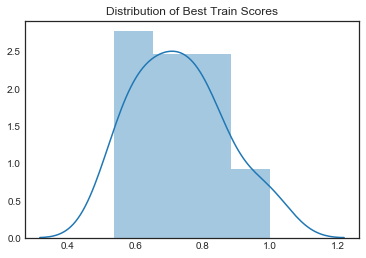

/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


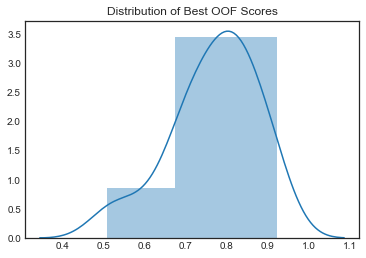

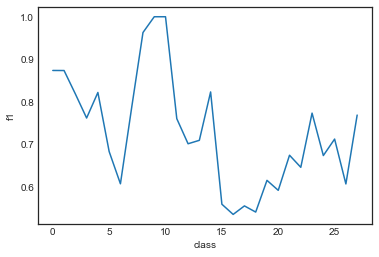

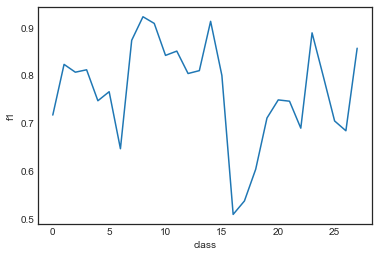

<Figure size 432x288 with 0 Axes>

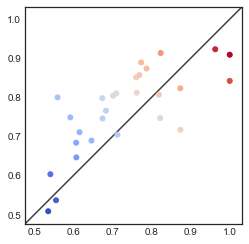

0 0.8739258689239452 0.7171052631578946
1 0.8737769080234835 0.8232758620689656
2 0.8189820130118638 0.8069196428571428
3 0.7622993267736924 0.8119575699132111
4 0.8222862632084533 0.7470817120622568
5 0.6836409929980904 0.7660401814646791
6 0.6079613992762365 0.6466036113499569
7 0.7873523280055594 0.8737864077669902
8 0.962962962962963 0.9230769230769231
9 1.0 0.9090909090909091
10 1.0 0.8421052631578948
11 0.76076993583868 0.8511066398390341
12 0.7019089574155654 0.8041237113402061
13 0.7099567099567099 0.8101761252446184
14 0.823529411764706 0.9134677944046845
15 0.56 0.8
16 0.5360824742268041 0.5089820359281438
17 0.5560538116591929 0.5371428571428571
18 0.5415896487985212 0.6036446469248292
19 0.6160293347302253 0.710951526032316
20 0.5925925925925926 0.7488584474885844
21 0.6749946155502908 0.7461564742056713
22 0.6466321243523316 0.689655172413793
23 0.7738193869096934 0.8893383415197921
24 0.6742424242424242 0.797979797979798
25 0.712899211945251 0.7047683462969225
26 0.607594

<Figure size 432x288 with 0 Axes>

In [91]:
sns.distplot(np.array(bestScore_all))
plt.title("Distribution of Best Train Scores")
plt.show()
plt.gcf().clear()

sns.distplot(np.array(bestScore_oof_all))
plt.title("Distribution of Best OOF Scores")
plt.show()
plt.gcf().clear()

plt.plot(range(num_classes), np.array(bestScore_all))
plt.xlabel("class")
plt.ylabel("f1")
# plt.title(LABEL_MAP[c] + " " + metric + " hillclimbing (%d, %6.4f)" % (bestStep, bestScore))
# plt.legend()
plt.show()
plt.gcf().clear()

plt.plot(range(num_classes), np.array(bestScore_oof_all))
plt.xlabel("class")
plt.ylabel("f1")
# plt.title(LABEL_MAP[c] + " " + metric + " hillclimbing (%d, %6.4f)" % (bestStep, bestScore))
# plt.legend()
plt.show()
plt.gcf().clear()

c = np.array(bestScore_all)**2 + np.array(bestScore_oof_all)**2

fig, ax = plt.subplots()
ax.scatter( np.array(bestScore_all),  np.array(bestScore_oof_all), 
           s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()
plt.gcf().clear()

for i in range(num_classes):
    print(i,bestScore_all[i],bestScore_oof_all[i])

/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


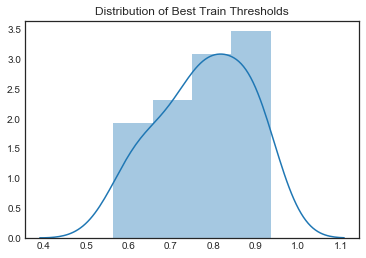

/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


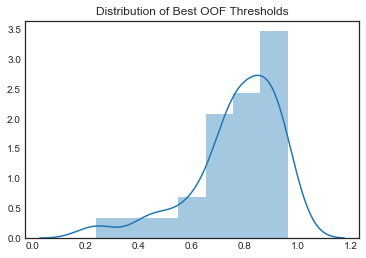

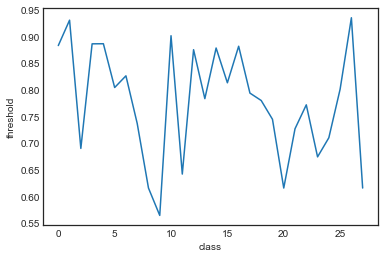

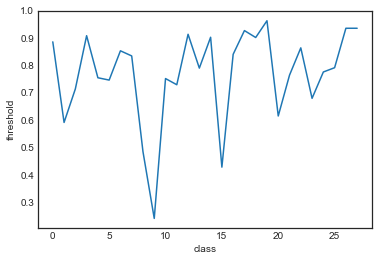

<Figure size 432x288 with 0 Axes>

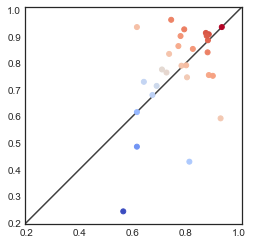

0 0.8831560367958772 0.885771004012079
1 0.9308401775804748 0.5916193926037977
2 0.690056772301972 0.7138814048121983
3 0.8864166310722201 0.9082378657784652
4 0.8865856723670661 0.7547472001988362
5 0.8043710314630855 0.7462216956915372
6 0.8263711302348615 0.853111918022514
7 0.7369748479294065 0.83437280230916
8 0.6156790920431628 0.4849857073496406
9 0.5642720834885754 0.24135190192556155
10 0.901637755229649 0.7518234786448725
11 0.6418880750463443 0.7292381301789251
12 0.8754092385032848 0.9134077572115559
13 0.7835010071984657 0.7899222278598991
14 0.8785684053717762 0.902558943600361
15 0.8132712116658518 0.4284989781180551
16 0.8818937716058153 0.84030451401761
17 0.79391459637131 0.9268900370869001
18 0.7800230039186947 0.9016400087044524
19 0.7447413940820282 0.9628147604452995
20 0.6156791497143052 0.615208934693204
21 0.7269935722288178 0.7642265756417596
22 0.7718787777060081 0.8638582302675983
23 0.674177184305243 0.679636831801297
24 0.7100657493607097 0.775766617663320

<Figure size 432x288 with 0 Axes>

In [92]:
sns.distplot(np.array(bestCut_all))
plt.title("Distribution of Best Train Thresholds")
plt.show()
plt.gcf().clear()

sns.distplot(np.array(bestCut_oof_all))
plt.title("Distribution of Best OOF Thresholds")
plt.show()
plt.gcf().clear()

plt.plot(range(num_classes), np.array(bestCut_all))
plt.xlabel("class")
plt.ylabel("threshold")
# plt.title(LABEL_MAP[c] + " " + metric + " hillclimbing (%d, %6.4f)" % (bestStep, bestScore))
# plt.legend()
plt.show()
plt.gcf().clear()

plt.plot(range(num_classes), np.array(bestCut_oof_all))
plt.xlabel("class")
plt.ylabel("threshold")
# plt.title(LABEL_MAP[c] + " " + metric + " hillclimbing (%d, %6.4f)" % (bestStep, bestScore))
# plt.legend()
plt.show()
plt.gcf().clear()

c = np.array(bestCut_all)**2 + np.array(bestCut_oof_all)**2

fig, ax = plt.subplots()
ax.scatter( np.array(bestCut_all),  np.array(bestCut_oof_all), 
           s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()
plt.gcf().clear()

for i in range(num_classes):
    print(i,bestCut_all[i],bestCut_oof_all[i])

In [93]:
bestEnsemble_all0 = bestEnsemble_oof.copy()

In [94]:
# save out-of-fold predictions
nf = np.sum(folds==fold)
print(nf)
ens = np.zeros((nf,num_classes))
for j in range(num_classes):
    ens[:,j] = bestEnsemble_oof_all[j][folds==fold,j]
     
oof_ids = oof.index.values[folds==fold]
poof = ens.copy()
yoof = y[folds==fold]

oof = [oof_ids, poof, yoof]
fname = 'oof/'+mname+'_'+str(fold)+'.pkl'
pickle.dump(oof,open(fname,'wb'))
print(fname)
    
# p = pd.DataFrame(ens)
# p.columns = ['p'+str(i) for i in range(ens.shape[1])]
# yd = pd.DataFrame(y)
# yd.names = ['y'+str(i) for i in range(ens.shape[1])]
# subp = pd.DataFrame({'id':vp.index.values[folds==fold],'data':'oof'})
# subp = pd.concat((subp,yd,p),axis=1)
# print(subp.shape)
# fname = 'oof/' + mname + '_' + str(fold) + '.csv'
# subp.to_csv(fname, index=False)
# print(fname)

11545
oof/hill_g100_0.pkl


In [95]:
pred = ens.copy()
num_classes = x.shape[1]
print(pred.shape,pred.min(),pred.mean(),pred.max(),num_classes)
name_label_dict = LABEL_MAP
th = np.zeros(num_classes)
for i in range(num_classes):
    th[i] = fit_val1(pred[:,i],y[folds==fold,i])
# th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y[folds==fold], pred>th, average='macro'))
print('F1 micro: ',f1_score(y[folds==fold], pred>th, average='micro'))

(11545, 28) -0.008752120103547712 0.10860863885646857 0.9999801719676146 28
Thresholds:  [0.886 0.592 0.714 0.908 0.755 0.746 0.853 0.834 0.485 0.241 0.752 0.729 0.913 0.79  0.903 0.428 0.84  0.927 0.902 0.963 0.615 0.764 0.864 0.68  0.776 0.791 0.935 0.935]
F1 macro:  0.7687410230780973
F1 micro:  0.7689191232048375



f1_best 0.7239900531657633
threshold_best 0.86



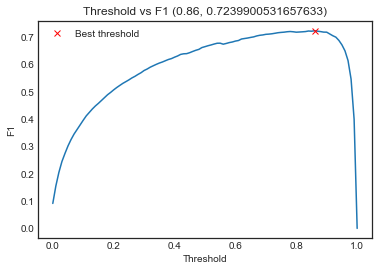

<Figure size 432x288 with 0 Axes>

In [96]:
# grid search for single best threshold
vlsp = pred.copy()

thresholds = np.linspace(0, 1., 101)
scores = np.array([f1_score(yoof, (vlsp > t).astype(int), average='macro') \
                 for t in thresholds])

threshold_best_index = np.argmax(scores)
score_best = scores[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
print('')
print('f1_best',score_best)
print('threshold_best',threshold_best)
print('')

plt.plot(thresholds, scores)
plt.plot(threshold_best, score_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title("Threshold vs F1 ({}, {})".format(threshold_best, score_best))
plt.legend()
plt.show()
plt.gcf().clear()

-0.008752120103547712 0.10860863885646857 0.9999801719676146 (323260,)


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


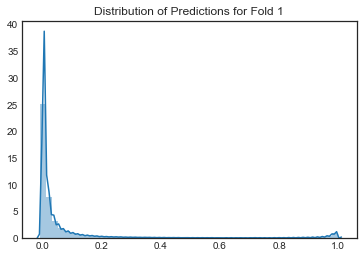

<Figure size 432x288 with 0 Axes>

In [97]:
vf = vlsp.flatten()
print(vf.min(),vf.mean(),vf.max(),vf.shape)
sns.distplot(vf)
plt.title("Distribution of Predictions for Fold " + str(fold+1))
plt.show()
plt.gcf().clear()

In [98]:
# num_rows = x.shape[0]
# c = np.zeros(num_rows)
# for i in range(num_rows):
#     c[i] = np.corrcoef(pred[i],yoof[i])[0,1]
# o = oof.iloc[:,:1]
# o['corr'] = c

# fname = 'corrs'+midx+'_'+str(fold)+'.csv'
# o.to_csv(fname)
# print(fname)

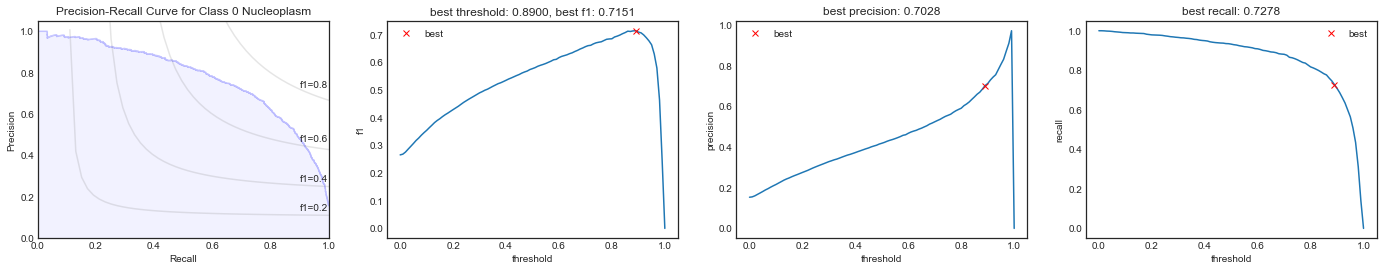

<Figure size 432x288 with 0 Axes>

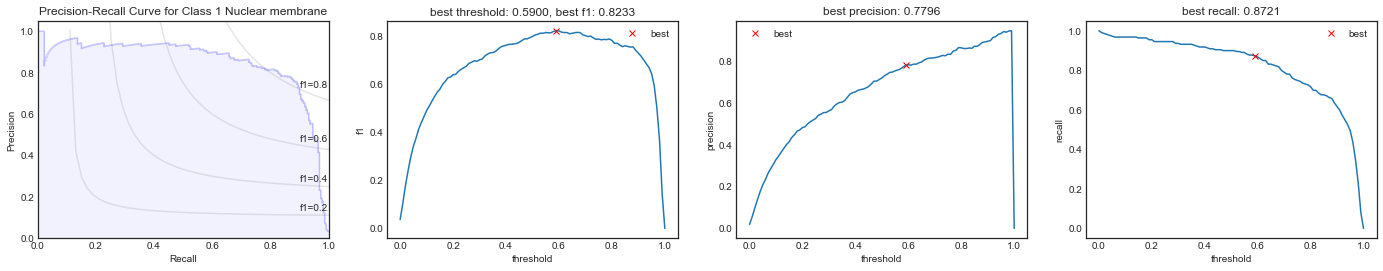

<Figure size 432x288 with 0 Axes>

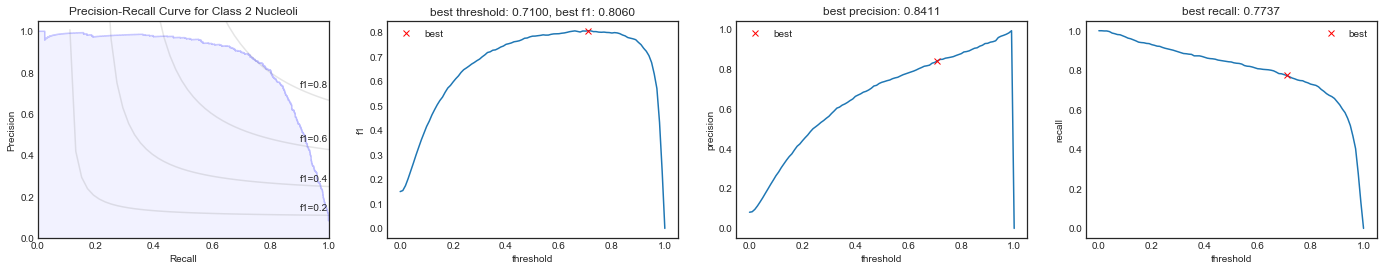

<Figure size 432x288 with 0 Axes>

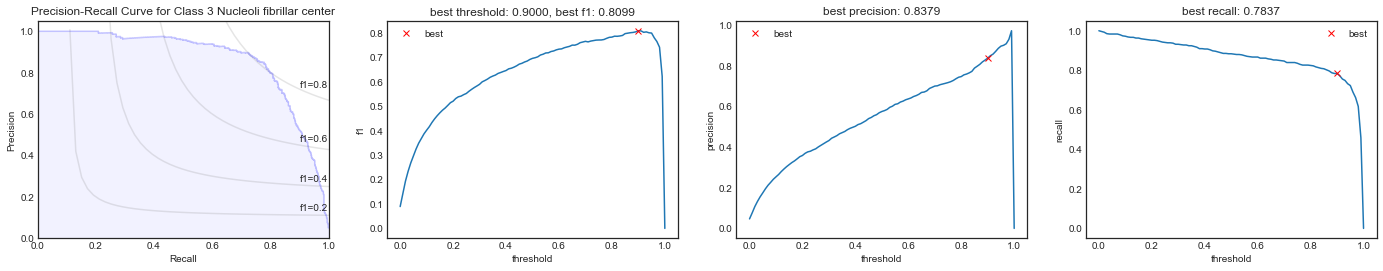

<Figure size 432x288 with 0 Axes>

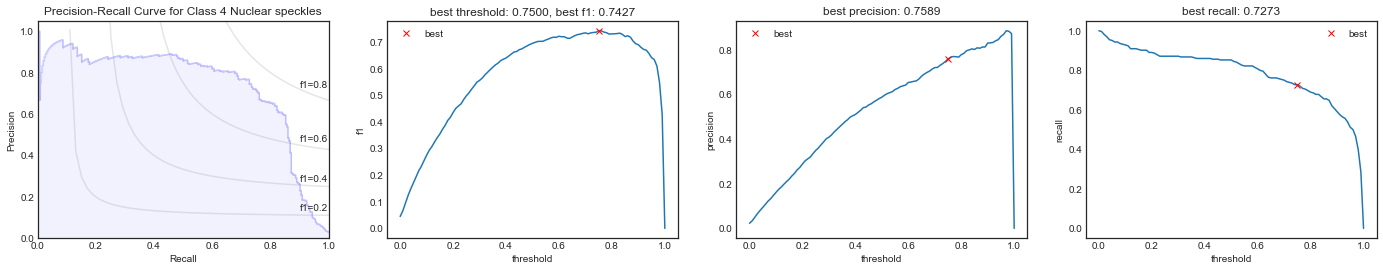

<Figure size 432x288 with 0 Axes>

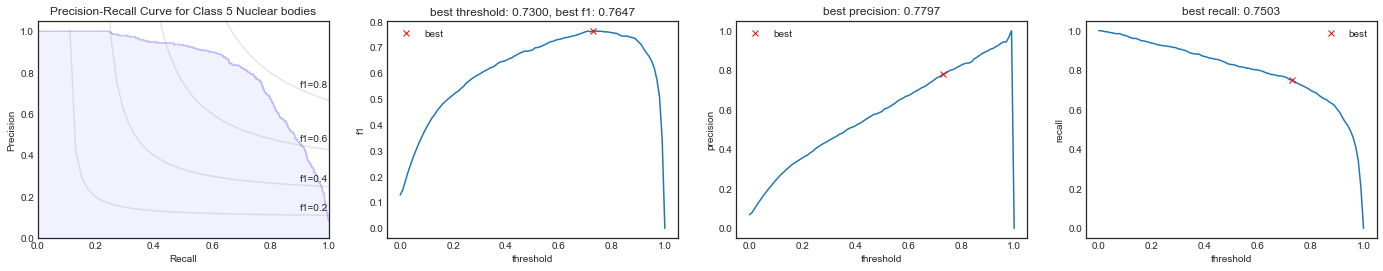

<Figure size 432x288 with 0 Axes>

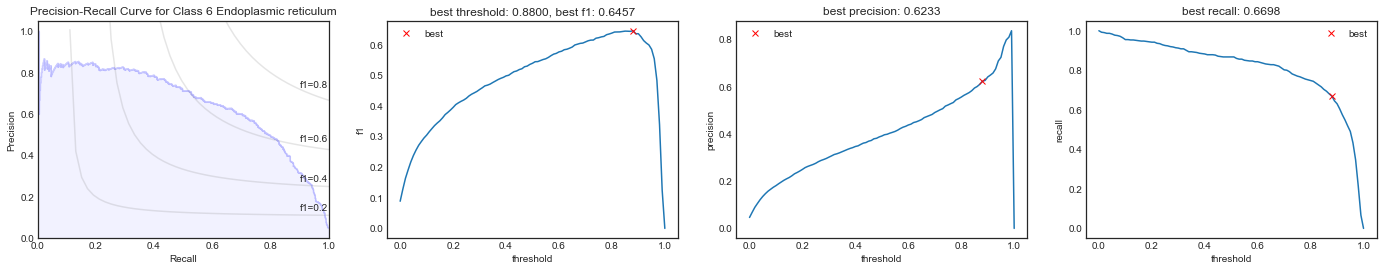

<Figure size 432x288 with 0 Axes>

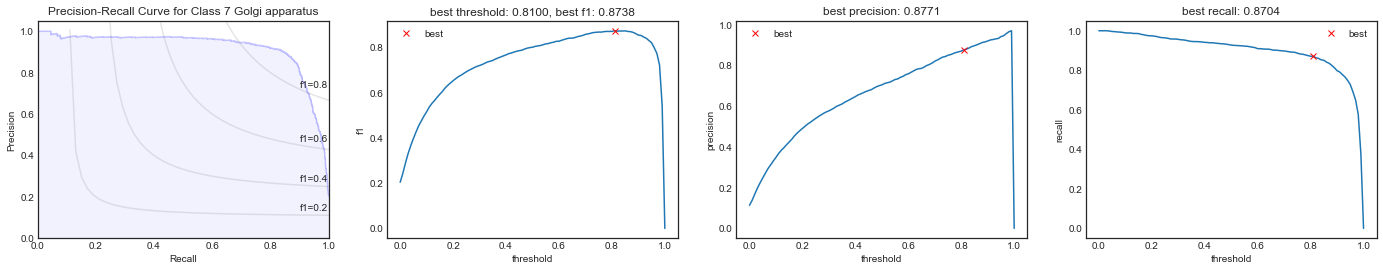

<Figure size 432x288 with 0 Axes>

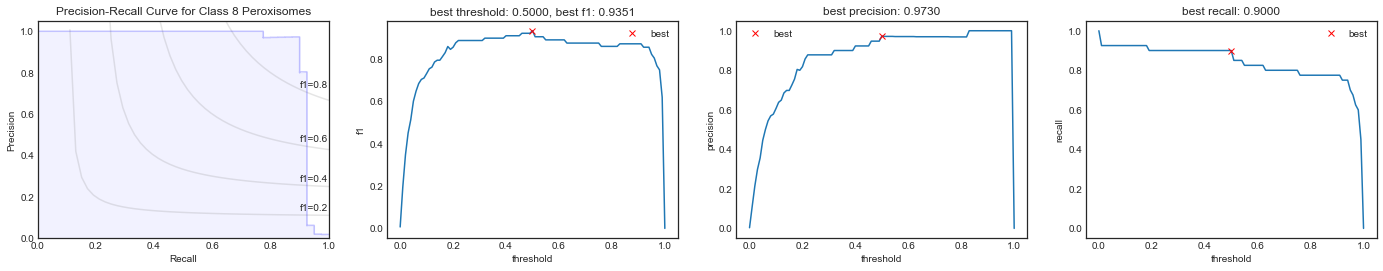

<Figure size 432x288 with 0 Axes>

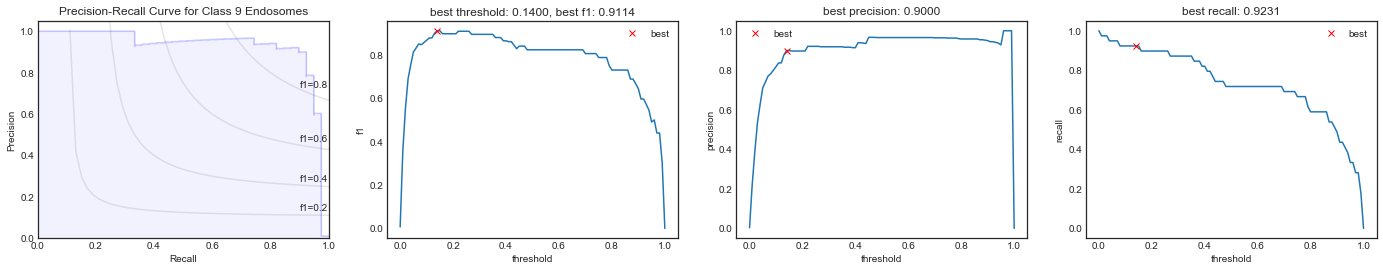

<Figure size 432x288 with 0 Axes>

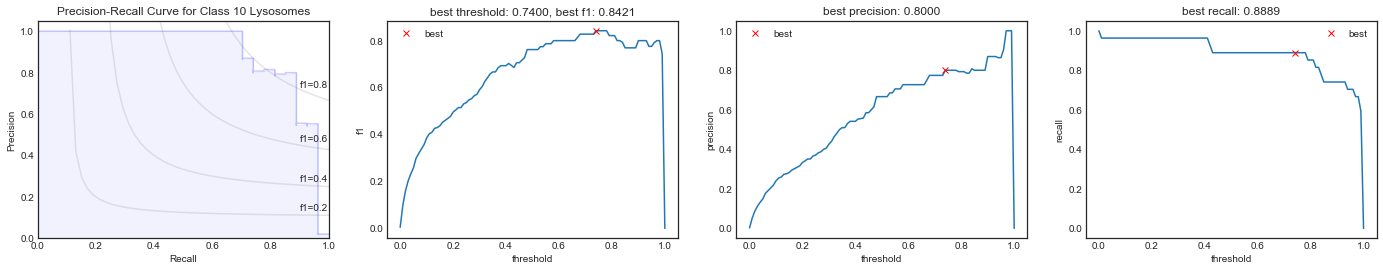

<Figure size 432x288 with 0 Axes>

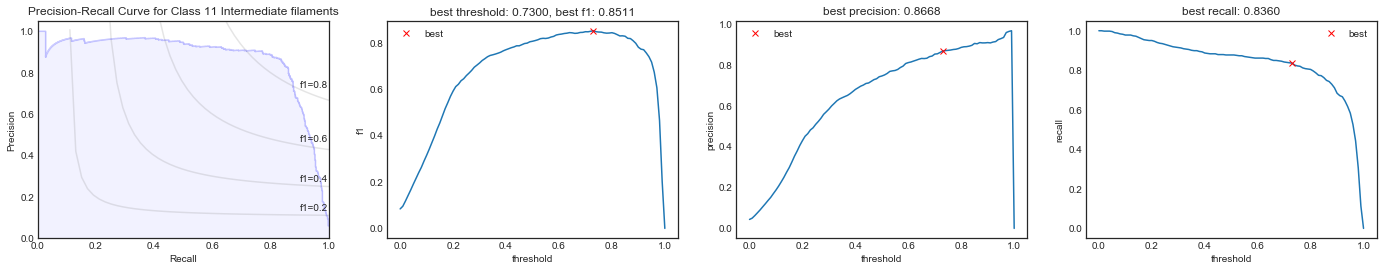

<Figure size 432x288 with 0 Axes>

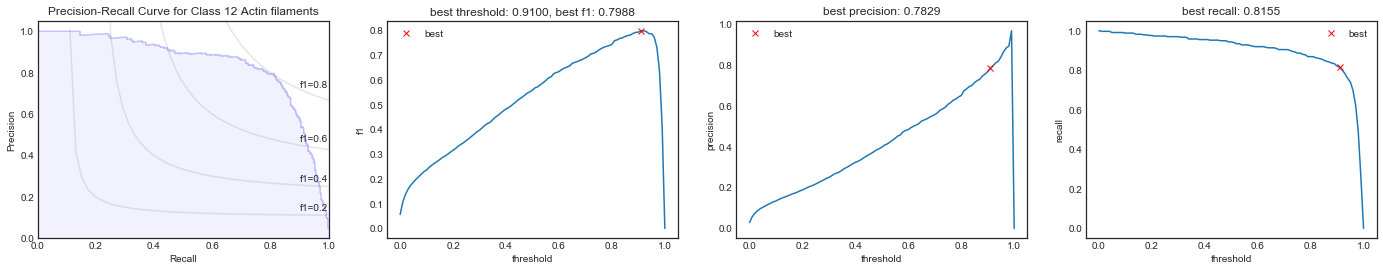

<Figure size 432x288 with 0 Axes>

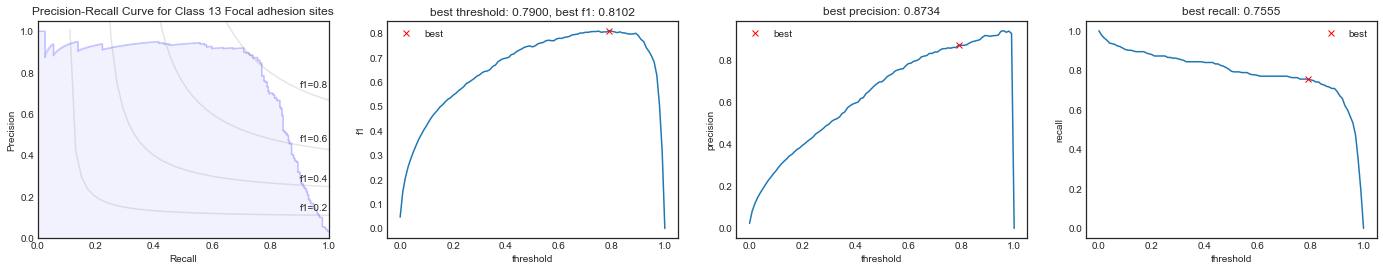

<Figure size 432x288 with 0 Axes>

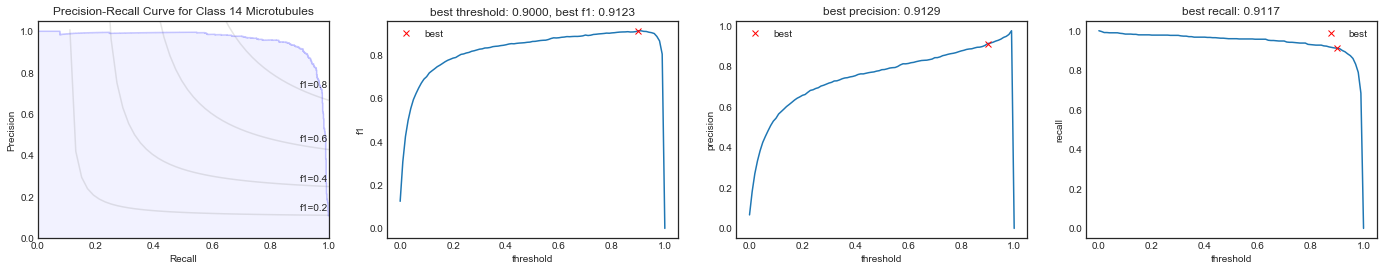

<Figure size 432x288 with 0 Axes>

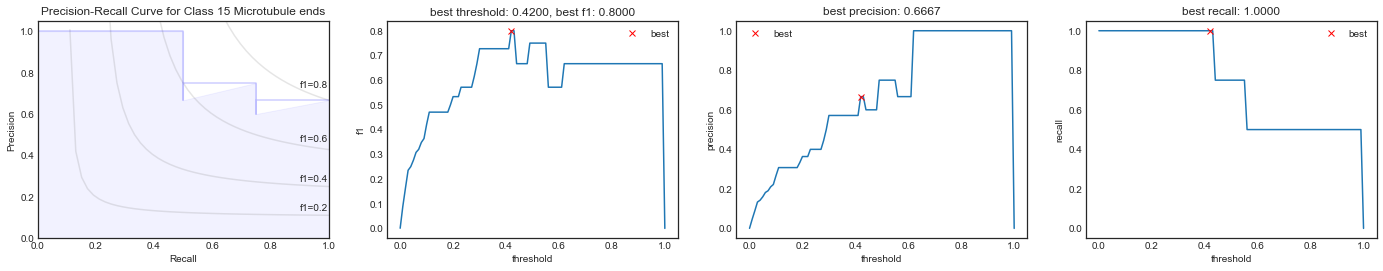

<Figure size 432x288 with 0 Axes>

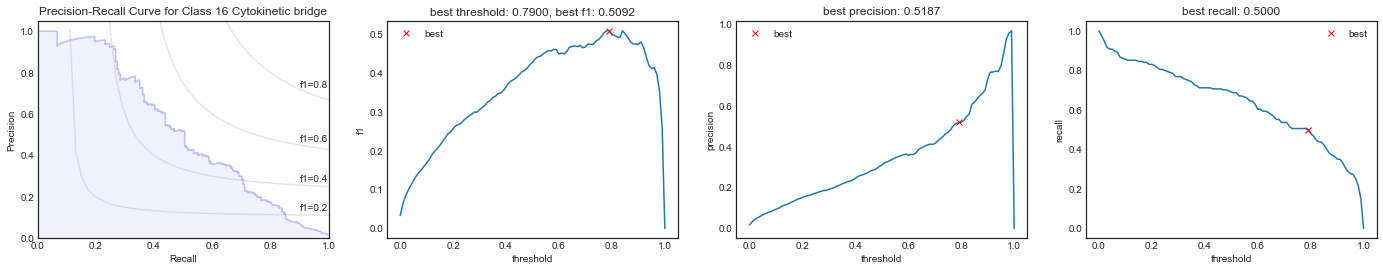

<Figure size 432x288 with 0 Axes>

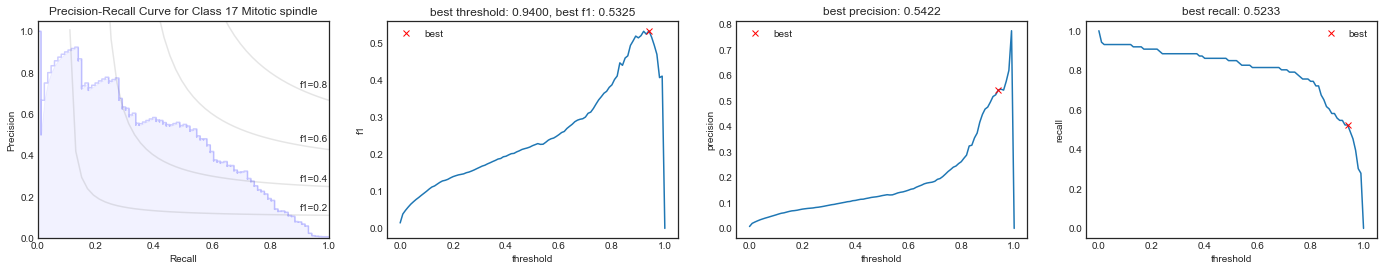

<Figure size 432x288 with 0 Axes>

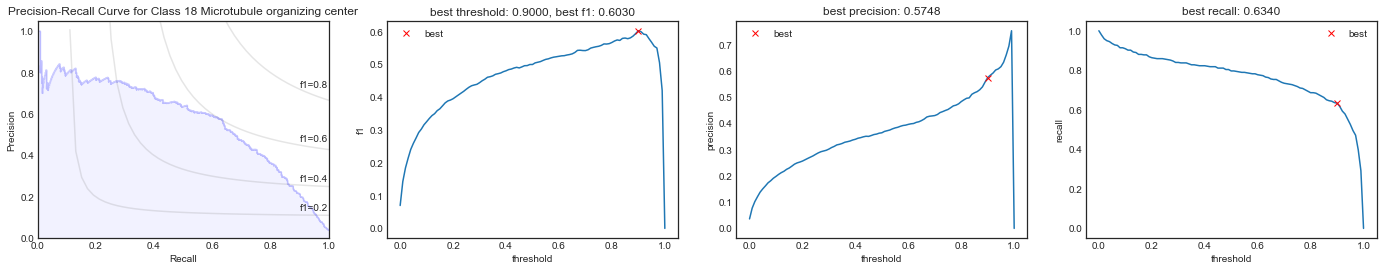

<Figure size 432x288 with 0 Axes>

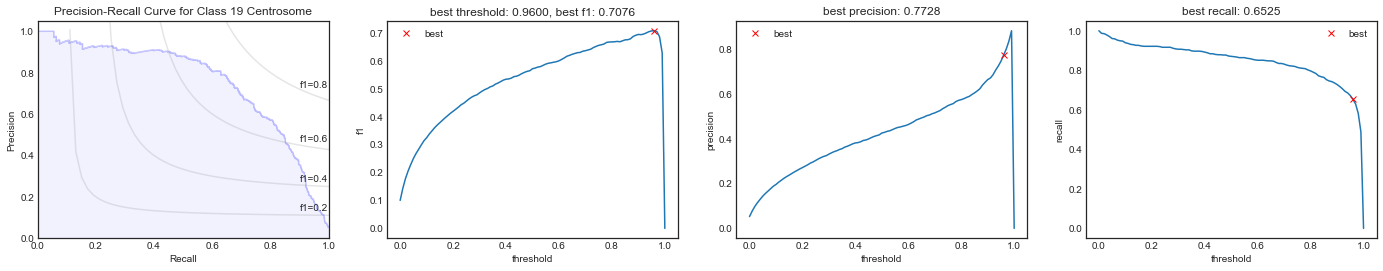

<Figure size 432x288 with 0 Axes>

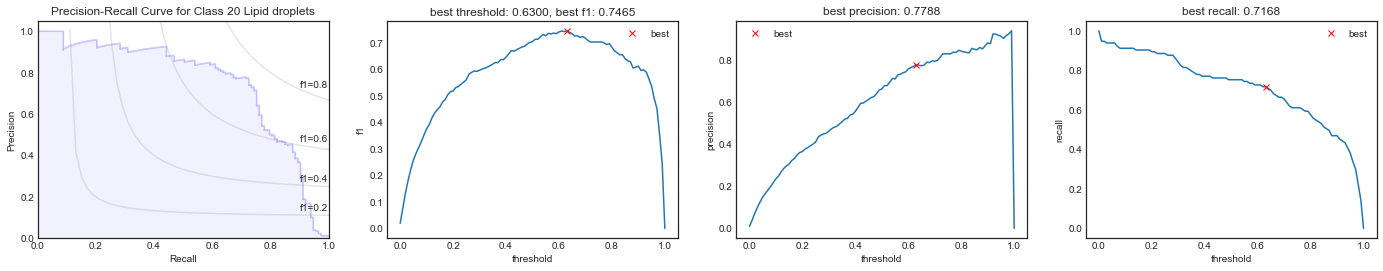

<Figure size 432x288 with 0 Axes>

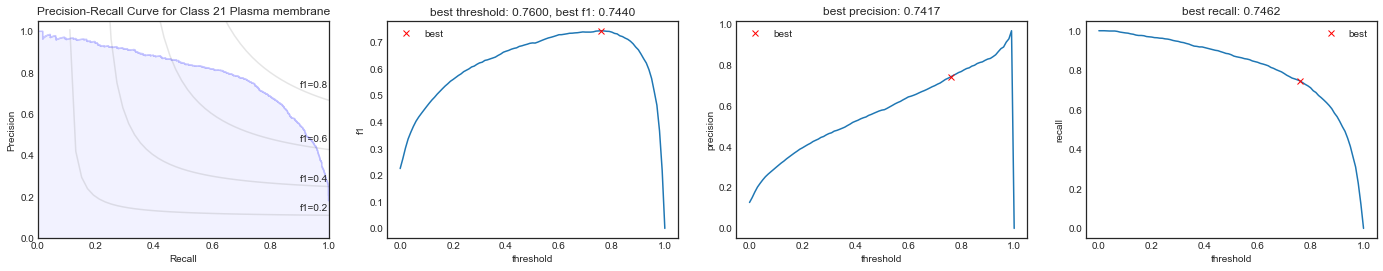

<Figure size 432x288 with 0 Axes>

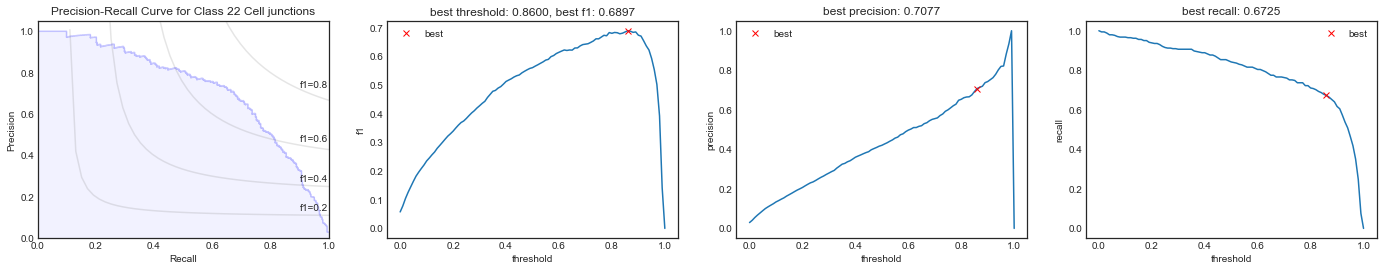

<Figure size 432x288 with 0 Axes>

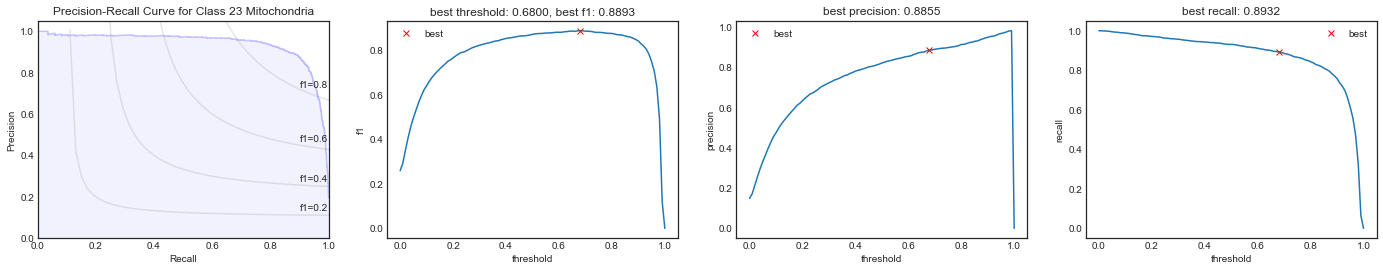

<Figure size 432x288 with 0 Axes>

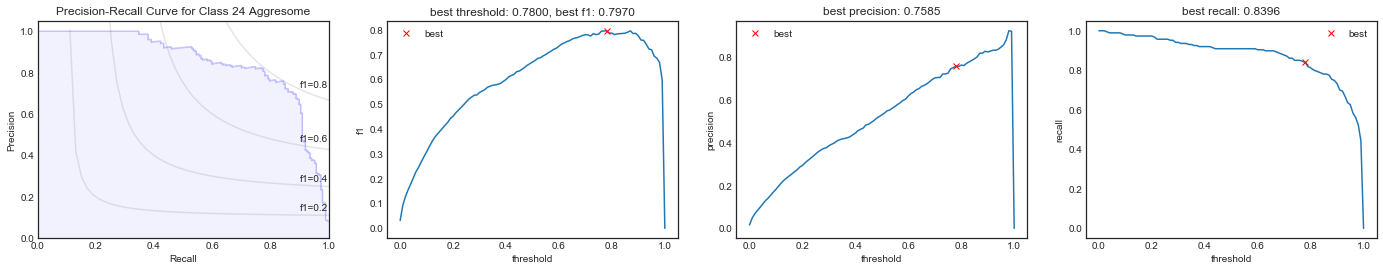

<Figure size 432x288 with 0 Axes>

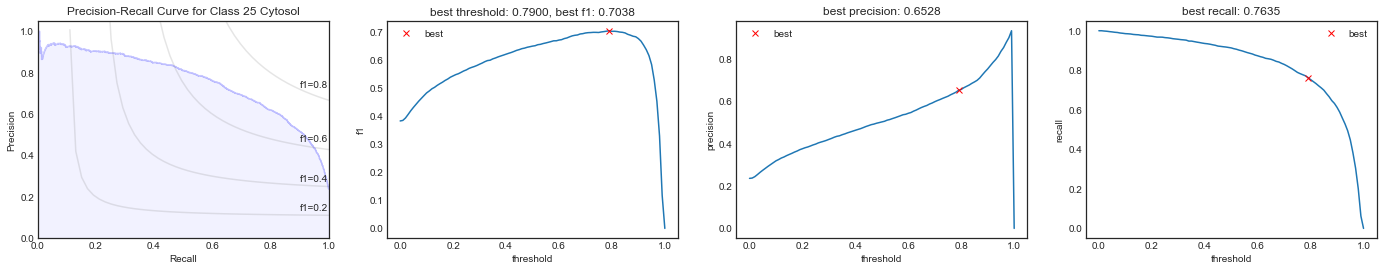

<Figure size 432x288 with 0 Axes>

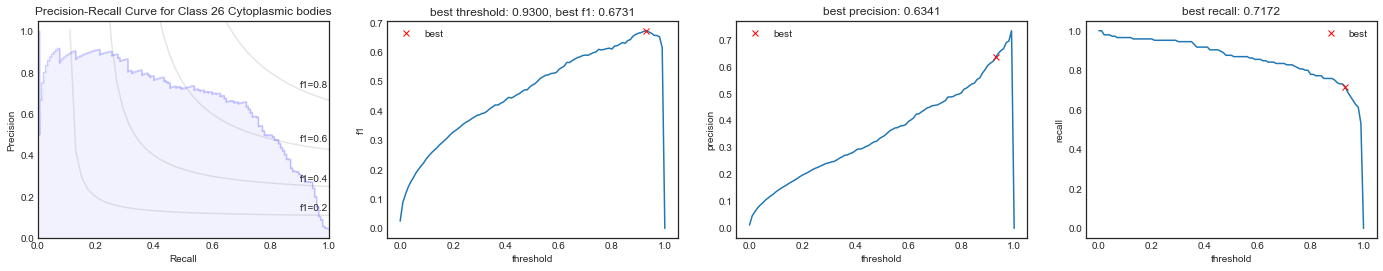

<Figure size 432x288 with 0 Axes>

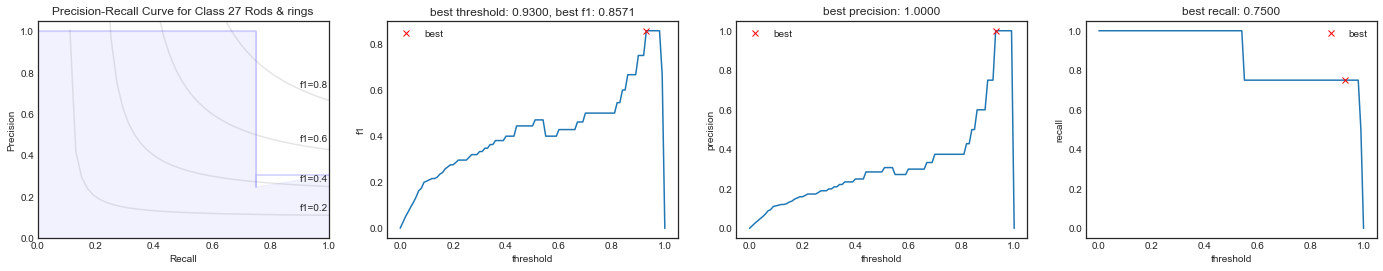

<Figure size 432x288 with 0 Axes>

In [99]:
n_classes = 28
thresholds = np.linspace(0.0, 1.0, 101)

# plot precision-recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()
f_scores = np.linspace(0.2, 0.8, num=4)
ta = []
fma = []

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(yoof[:, i], pred[:, i])
    average_precision[i] = average_precision_score(yoof[:, i], pred[:, i])
    
#     plt.figure()
    
#     for f_score in f_scores:
#         xf = np.linspace(0.01, 1)
#         yf = f_score * xf / (2 * xf - f_score)
#         l, = plt.plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
#         plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

#     plt.step(recall[i], precision[i], color='b', alpha=0.2, where='post')
#     plt.fill_between(recall[i], precision[i], alpha=0.05, color='b')

#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
#     plt.title(LABEL_MAP[i])
    
    
    fig, axs = plt.subplots(1, 4, figsize=(24, 4))
    
    for f_score in f_scores:
        xf = np.linspace(0.01, 1)
        yf = f_score * xf / (2 * xf - f_score)
        l, = axs[0].plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
        axs[0].annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

    axs[0].step(recall[i], precision[i], color='b', alpha=0.2, where='post')
    axs[0].fill_between(recall[i], precision[i], alpha=0.05, color='b')

    axs[0].set_xlabel('Recall')
    axs[0].set_ylabel('Precision')
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_title('Precision-Recall Curve for Class ' + str(i) + ' ' + LABEL_MAP[i])
    
    
    # for ranks
    # thresholds = np.linspace(0.8, 1.0, 101)
    fm = [f1_score(yoof[:,i], (pred[:,i] > t).astype(int)) for t in thresholds] 

    besti = np.argmax(fm)
    bestt = thresholds[besti]
    ta.append(bestt)
    bests = fm[besti] 
    fma.append(bests)
        
    axs[1].plot(thresholds, fm)
    axs[1].plot(bestt, bests, "xr", label="best")
    axs[1].set_xlabel("threshold")
    axs[1].set_ylabel("f1")
    axs[1].set_title("best threshold: %6.4f, best f1: %6.4f" % (bestt, bests))
    axs[1].legend()

    pm = [precision_score(yoof[:,i], (pred[:,i] > t).astype(int)) for t in thresholds] 
    bestsp = pm[besti] 
        
    axs[2].plot(thresholds, pm)
    axs[2].plot(bestt, bestsp, "xr", label="best")
    axs[2].set_xlabel("threshold")
    axs[2].set_ylabel("precision")
    axs[2].set_title("best precision: %6.4f" % (bestsp))
    axs[2].legend()
    
    rm = [recall_score(yoof[:,i], (pred[:,i] > t).astype(int)) for t in thresholds] 
    bestsr = rm[besti] 
        
    axs[3].plot(thresholds, rm)
    axs[3].plot(bestt, bestsr, "xr", label="best")
    axs[3].set_xlabel("threshold")
    axs[3].set_ylabel("recall")
    axs[3].set_title("best recall: %6.4f" % (bestsr))
    axs[3].legend()
    
    plt.show()
    plt.gcf().clear()

In [100]:
np.mean(fma)

0.7676772388652706

In [101]:
# error analysis
from sklearn.metrics import confusion_matrix

cm = [confusion_matrix(yoof[:,i], (pred[:,i]  > th[i]).astype(int)) \
       for i in range(yoof.shape[1])]
pma = [precision_score(yoof[:,i], (pred[:,i]  > th[i]).astype(int)) \
       for i in range(yoof.shape[1])]
rma = [recall_score(yoof[:,i], (pred[:,i]  > th[i]).astype(int)) \
       for i in range(yoof.shape[1])]

print('macro f1','%6.4f' % np.mean(fma))
print()

# sort from worst to best
order = np.array(fma).argsort()
ymean = np.mean(yoof,axis=0)

for i in range(y.shape[1]):
    oi = order[i]
    print('class', '%2d' % oi,'  prop', '%6.4f' % ymean[oi], 
                     '  f1', '%6.4f' % fma[oi],
                     '  precision', '%6.4f' % pma[oi],
                     '  recall', '%6.4f' % rma[oi],
                     '  ', LABEL_MAP[oi])
    print(cm[oi])
    print()

macro f1 0.7677

class 16   prop 0.0168   f1 0.5092   precision 0.6071   recall 0.4381    Cytokinetic bridge
[[11296    55]
 [  109    85]]

class 17   prop 0.0074   f1 0.5325   precision 0.5281   recall 0.5465    Mitotic spindle
[[11417    42]
 [   39    47]]

class 18   prop 0.0362   f1 0.6030   precision 0.5761   recall 0.6340    Microtubule organizing center
[[10932   195]
 [  153   265]]

class  6   prop 0.0464   f1 0.6457   precision 0.5997   recall 0.7015    Endoplasmic reticulum
[[10758   251]
 [  160   376]]

class 26   prop 0.0126   f1 0.6731   precision 0.6541   recall 0.7172    Cytoplasmic bodies
[[11345    55]
 [   41   104]]

class 22   prop 0.0296   f1 0.6897   precision 0.7077   recall 0.6725    Cell junctions
[[11108    95]
 [  112   230]]

class 25   prop 0.2366   f1 0.7038   precision 0.6547   recall 0.7631    Cytosol
[[7715 1099]
 [ 647 2084]]

class 19   prop 0.0528   f1 0.7076   precision 0.7857   recall 0.6492    Centrosome
[[10827   108]
 [  214   396]]

class  

In [102]:
# confusion matrix of true val with single label
true_list = []
pred_list = []
for i, yi in enumerate(yoof):
#     img, y = db_val[i]

    true = np.nonzero(yi)[0]
    if len(true) > 1: continue
    
    predi = np.nonzero((pred[i] > threshold_best).astype(int))[0]
    if len(predi)==0: predi = np.array([28])
    # replace empty with max prob
    # if len(pred)==0: pred = [np.argmax(vlsp[i])]
    for j in range(len(predi)):
        true_list.append(true[0])
        pred_list.append(predi[j])
    
print(y.shape[0],len(true_list),len(pred_list))

true = np.array(true_list)
predc = np.array(pred_list)
print(true.shape,true[:5])

np.set_printoptions(linewidth=250)
cm = confusion_matrix(true,predc)
print(cm)

31072 9129 9129
(9129,) [18  7 21 23 25]
[[ 290    2    5    0    4   22    0    3    0    0    0    2    0    1    0    3    2    7   20    0    1    3    1    1   27    8    0   16]
 [   7   67    1    0    0    0    3    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    5    0    0    2]
 [  55    0  218   39    3    1    0    1    0    0    0    1    0    0    1    0    3    7    4    0    4    0    1    0   23    0    0   14]
 [  25    1    9  301    3   10    0    0    0    0    0    0    0    0    0    1    0    0    1    0    0    1    3    1    6    0    0   11]
 [  18    0    2    5   93    6    0    2    0    0    0    0    0    1    0    0    0    0    1    0    0    1    0    0    7    2    0    5]
 [  81    9    0   13    4  375    0    1    0    0    0    0    0    0    1    0    0    1   12    0    2    2    2    3   15    0    0   46]
 [   1    2    1    0    0    0  284    2    0    0    0    3    0    0    6    0    1    0    1    0

In [103]:
# compute test predictions
weights = pickle.load(open('weights/'+mname+'_'+str(fold)+'.pkl','rb'))
print(len(weights))

28


In [104]:
weights

[      weight             mod      f1_0
 midx                                  
 0          4         air_g68  0.865808
 1          2         air_h68  0.863851
 3          6        cbam_h67  0.861839
 4          4         iv3_g11  0.855522
 5          1         iv3_h11  0.851569
 6          6   preresnet_g67  0.864127
 7          1   preresnet_h67  0.863235
 8          1  se_resnext_g30  0.860187
 9          5  se_resnext_h30  0.862937,       weight             mod      f1_0
 midx                                  
 7          1   preresnet_h67  0.859641
 8          1  se_resnext_g30  0.840716,       weight             mod      f1_0
 midx                                  
 0          3         air_g68  0.805010
 1          1         air_h68  0.808543
 2          4        airx_h67  0.802219
 3          4        cbam_h67  0.797192
 6          7   preresnet_g67  0.801057
 8          1  se_resnext_g30  0.783014
 9          3  se_resnext_h30  0.797781,       weight            mod      f1_0
 

In [105]:
# list of unique model names

# allm = weights['mod'].values
# mnames = list(allm)

allm = [weights[i]['mod'].values for i in range(len(weights))]
mnames = list(set().union(*allm))

print(mnames)
print(len(mnames))

['iv3_h11', 'cbam_h67', 'se_resnext_g30', 'air_g68', 'iv3_g11', 'preresnet_g67', 'airx_h67', 'air_h68', 'se_resnext_h30', 'preresnet_h67']
10


In [106]:
blist = ['blend_0459']
tlist = ['iv3_a4','se_resnext_d10','se_resnext_d11']
klist = ['resnet34_46','resnet50','resnet34']
print(glist)
print(clist)
print(dlist)
print(blist)
print(tlist)
print(klist)

['air_g68', 'air_h68', 'airx_h67', 'cbam_h67', 'iv3_g11', 'iv3_h11', 'preresnet_g67', 'preresnet_h67', 'se_resnext_g30', 'se_resnext_h30']
[]
[]
['blend_0459']
['iv3_a4', 'se_resnext_d10', 'se_resnext_d11']
['resnet34_46', 'resnet50', 'resnet34']


In [107]:
clist

[]

In [108]:
name_label_dict = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}
LABEL_MAP = name_label_dict
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [113]:
test_df = pd.read_csv("sample_submission.csv", index_col="Id")
print(test_df.head())
print(test_df.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [114]:
test_df.columns

Index(['Predicted'], dtype='object')

In [115]:
# save a base copy for reuse below
test_df0 = test_df.copy()
sub_dir = './sub/'

In [116]:
# build blend as weighted average
test_df = test_df0.copy()
idx = test_df.index.values
num_classes = 28
firstm = True
sumw = 0.
c = 0
d = 0
for m in mnames:

    firstf = True
    navg = 0
    if m in blist+clist: suffix = '.npy'
    elif m in klist+slist: suffix = '.pkl'
    else: suffix = '_mm.pkl'
    if True:
#     for fold in range(nfold):
#         print('')
#         print(m+'_'+str(fold))
        first = True
        nr = 0
        for rep in ['']:
            if m in blist:
                fname = sub_dir + m + rep + suffix
                if fold > 0: fname = fname + '_' + str(fold)
            elif m in clist:
                fname = 'oof/'+clist0[c]+'_ext_russ4/pred'+str(fold)+suffix
            elif m in dlist:
                if dlist0[d] in dlist0s: s = '_' + dfold
                else: s = '_extra_' + dfold
                fname = 'oof/Dmytro/'+dlist0[d]+s+'__fold_'+ \
                                str(fold)+'_'+dlist1[d]+'_test.csv'
            else:
                fname = sub_dir + m + rep + '_' + str(fold) + suffix
            if os.path.exists(fname):
                print()
                print(fname)
                if m in blist+clist:
                    ptestb = np.load(fname)
                    idb = idb0
                elif m in dlist:
                    o = pd.read_csv(fname)
                    idb = list(o['Id'])
                    ptestb = np.array(o.iloc[:,:num_classes])
                    ptestb = expit(ptestb)
                elif m in slist:
                    a = pickle.load(open(fname,'rb'))
                    idb = list(a[:,0])
                    ptestb = np.zeros((len(idb),num_classes))
                    for i in range(len(idb)):
                        ptestb[i,:] = a[i,1:].astype(float)
                elif m in klist: 
                    idb, ptestb = pickle.load(open(fname,'rb'))
                    # ptestb = logit(ptestb)
                elif m in tlist:
                    idb, ptestba, ptestb, ptestbb = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                elif m in flist+glist:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = np.percentile(ptestb, gpct, axis=(2,3))
                    ptestb = 1./(1. + np.exp(-ptestb/gscale))
                else:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                
                # ptestb = np.clip(ptestb,-20.0,20.0)
                # ptestb[ptestb==-inf] = -6.0
                # ptestb[ptestb==inf] = 6.0
                
                print(ptestb.min(),ptestb.mean(),ptestb.max())
                
                if first:
                    ptestf = ptestb.copy()
                    idb0 = idb
                    first = False
                else:
                    checki = [i0 != i1 for i0,i1 in zip(idb0,idb)]
                    si = np.array(checki).sum()
                    # print(si)
                    assert si == 0
                    print(np.corrcoef(np.array(ptestf).flatten(),
                                      np.array(ptestb).flatten()))

                    ptestf += ptestb
                nr += 1
                
        if nr > 0:
            ptestf /= nr
            print(ptestf.shape,ptestf.min(),ptestf.mean(),ptestf.max())

            if firstf:
                id = idb
                ptest = ptestf.copy()
                firstf = False
            else:
                print(np.corrcoef(np.array(ptest).flatten(),
                                  np.array(ptestf).flatten()))
                ptest += ptestf
                
            navg += 1
    
    if navg != 1: raise ValueError('Found %d folds for %s instead of %d' % (navg,m,nfold))
    ptest /= navg
    pmask = (ptest > threshold).astype(int)
    print(m,navg,ptest.shape,ptest.min(),ptest.mean(),ptest.max(),pmask.mean())
    td = pd.DataFrame({'id':id})
    td[m] = [a for a in ptest]
    td.set_index('id',inplace=True)
    test_df = test_df.join(td)
    
    if m in clist: c += 1
    elif m in dlist: d += 1



./sub/iv3_h11_0_mm.pkl
2.0611536181902037e-09 0.1744555635396927 0.9999999638664336
(11702, 28) 2.0611536181902037e-09 0.1744555635396927 0.9999999638664336
iv3_h11 1 (11702, 28) 2.0611536181902037e-09 0.1744555635396927 0.9999999638664336 0.1407054960080084

./sub/cbam_h67_0_mm.pkl
4.965926339801853e-07 0.14108783540411532 0.9999488708411273
(11702, 28) 4.965926339801853e-07 0.14108783540411532 0.9999488708411273
cbam_h67 1 (11702, 28) 4.965926339801853e-07 0.14108783540411532 0.9999488708411273 0.10842774128964523

./sub/se_resnext_g30_0_mm.pkl
2.4734947389129936e-07 0.09922333713104967 0.9999825305592721
(11702, 28) 2.4734947389129936e-07 0.09922333713104967 0.9999825305592721
se_resnext_g30 1 (11702, 28) 2.4734947389129936e-07 0.09922333713104967 0.9999825305592721 0.08447579168396123

./sub/air_g68_0_mm.pkl
2.0611536181902037e-09 0.11124876605474665 0.9999993600866197
(11702, 28) 2.0611536181902037e-09 0.11124876605474665 0.9999993600866197
air_g68 1 (11702, 28) 2.061153618190203

In [117]:
test_df.columns

Index(['Predicted', 'iv3_h11', 'cbam_h67', 'se_resnext_g30', 'air_g68',
       'iv3_g11', 'preresnet_g67', 'airx_h67', 'air_h68', 'se_resnext_h30',
       'preresnet_h67'],
      dtype='object')

In [118]:
print(idx[:5])

['00008af0-bad0-11e8-b2b8-ac1f6b6435d0' '0000a892-bacf-11e8-b2b8-ac1f6b6435d0'
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0' '0008baca-bad7-11e8-b2b9-ac1f6b6435d0'
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0']


In [119]:
f = []
tclist = list(test_df.columns[1:])
for c in tclist:
    ff = np.array(list(test_df[c])).flatten()
    print(ff.shape,c)
    f.append(ff)
# print(tclist)
r = np.corrcoef(f)
print(r)

(327656,) iv3_h11
(327656,) cbam_h67
(327656,) se_resnext_g30
(327656,) air_g68
(327656,) iv3_g11
(327656,) preresnet_g67
(327656,) airx_h67
(327656,) air_h68
(327656,) se_resnext_h30
(327656,) preresnet_h67
[[1.    0.914 0.829 0.845 0.916 0.843 0.885 0.906 0.898 0.906]
 [0.914 1.    0.87  0.89  0.882 0.89  0.904 0.932 0.917 0.935]
 [0.829 0.87  1.    0.915 0.844 0.918 0.829 0.889 0.942 0.902]
 [0.845 0.89  0.915 1.    0.865 0.939 0.845 0.924 0.912 0.917]
 [0.916 0.882 0.844 0.865 1.    0.859 0.848 0.879 0.881 0.882]
 [0.843 0.89  0.918 0.939 0.859 1.    0.842 0.906 0.913 0.934]
 [0.885 0.904 0.829 0.845 0.848 0.842 1.    0.894 0.879 0.9  ]
 [0.906 0.932 0.889 0.924 0.879 0.906 0.894 1.    0.932 0.953]
 [0.898 0.917 0.942 0.912 0.881 0.913 0.879 0.932 1.    0.943]
 [0.906 0.935 0.902 0.917 0.882 0.934 0.9   0.953 0.943 1.   ]]


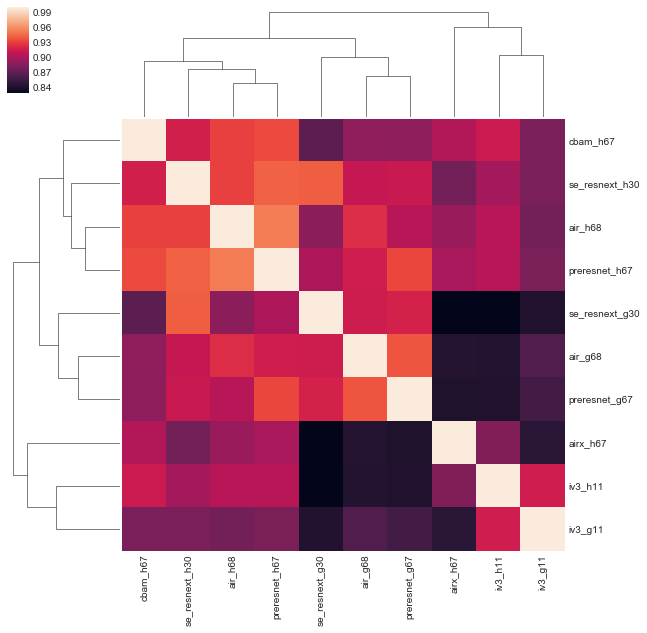

In [120]:
d = pd.DataFrame(r, columns=mnames)
d['id'] = mnames
d.set_index('id',inplace=True)
del d.index.name

sns.clustermap(d)


# import scipy.cluster.hierarchy as hc
# from matplotlib import pyplot
# link = hc.linkage(d.values, method='centroid')
# o1 = hc.leaves_list(link)

# mat = d.iloc[o1,:]
# mat = mat.iloc[:, o1[::-1]]
# pyplot.imshow(mat)

In [121]:
flat = np.transpose(np.array(f))
print(flat.shape)
fname = 'flat.csv'
fdf = pd.DataFrame(flat)
fdf.columns = tclist
fdf.to_csv(fname)
print(fname)

(327656, 10)
flat.csv


In [122]:
ens = np.zeros((test_df.shape[0],28))

# apply class-specific ensemble weights
for i in range(28):

    f = []
#     clist = weights['mod'].values
    clist = weights[i]['mod'].values
    for c in clist:
        f.append(np.array(list(test_df[c])))
    m = np.array(f)
    print(m.shape)

#     w = np.array(weights['weight'].values)
    w = np.array(weights[i]['weight'].values)
    print(i, clist, w)

    ens[:,i] = np.average(m,axis=0,weights=w)[:,i]
    
print(ens.shape)

(9, 11702, 28)
0 ['air_g68' 'air_h68' 'cbam_h67' 'iv3_g11' 'iv3_h11' 'preresnet_g67' 'preresnet_h67'
 'se_resnext_g30' 'se_resnext_h30'] [4 2 6 4 1 6 1 1 5]
(2, 11702, 28)
1 ['preresnet_h67' 'se_resnext_g30'] [1 1]
(7, 11702, 28)
2 ['air_g68' 'air_h68' 'airx_h67' 'cbam_h67' 'preresnet_g67' 'se_resnext_g30' 'se_resnext_h30'] [3 1 4 4 7 1 3]
(5, 11702, 28)
3 ['air_g68' 'air_h68' 'cbam_h67' 'preresnet_g67' 'preresnet_h67'] [2 5 3 1 1]
(5, 11702, 28)
4 ['air_h68' 'airx_h67' 'iv3_g11' 'preresnet_h67' 'se_resnext_g30'] [2 1 1 3 1]
(4, 11702, 28)
5 ['air_g68' 'air_h68' 'cbam_h67' 'preresnet_h67'] [1 1 2 1]
(1, 11702, 28)
6 ['se_resnext_h30'] [1]
(7, 11702, 28)
7 ['air_g68' 'cbam_h67' 'iv3_g11' 'preresnet_g67' 'preresnet_h67' 'se_resnext_g30' 'se_resnext_h30'] [8 3 1 2 1 1 1]
(3, 11702, 28)
8 ['airx_h67' 'preresnet_g67' 'se_resnext_h30'] [1 1 1]
(1, 11702, 28)
9 ['se_resnext_g30'] [1]
(2, 11702, 28)
10 ['air_g68' 'air_h68'] [1 4]
(4, 11702, 28)
11 ['air_g68' 'airx_h67' 'se_resnext_g30' 'se_res

In [123]:
print(ens[1])

[0.244 0.005 0.081 0.148 0.091 0.987 0.088 0.022 0.001 0.    0.007 0.073 0.012 0.018 0.008 0.004
 0.006 0.001 0.047 0.003 0.007 0.052 0.007 0.127 0.04  0.625 0.009 0.001]


In [124]:
ens.shape

(11702, 28)

In [125]:
test_ids = list(test_df.index.values)
print(len(test_ids))

11702


In [126]:
sub = [list(test_df.index.values), ens]
fname = 'sub/'+mname+'_'+str(fold)+'.pkl'
pickle.dump(sub,open(fname,'wb'))
print(fname)

sub/hill_g100_0.pkl
